In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings

warnings.filterwarnings('ignore')

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import GridSpec
from IPython.display import Image, display
from itertools import combinations, islice, takewhile
from itertools import combinations_with_replacement, permutations, product

import seaborn as sns
import json
import mpld3
import numpy as np
import pandas as pd
import scipy.sparse
import os
import sys
sys.path.append("..")
import warnings
from astropy import units as u
from astropy.coordinates import SkyCoord

import statsmodels.api as sm
sns.set_context('poster', font_scale=1.3)

from ipywidgets import interact, FloatSlider, SelectMultiple, interactive

from scipy.optimize import fmin_l_bfgs_b, basinhopping
from scipy.interpolate import LSQUnivariateSpline, splrep, splev, Akima1DInterpolator, interp1d
# "constants"
from scipy.constants import c # speed of light in m/s

In [5]:
%reload_ext autoreload
%autoreload 1
import finestructure
import finestructure.finestructure
%aimport finestructure.finestructure

In [39]:
DIP_RA = 17.3
DIP_RA_ERR = 1.0
DIP_DEC = -61.0
DIP_DEC_ERR = 10.0
DIP_AMPLITUDE = 0.97e-5
DIP_AMPLITUDE_ERR = 0.21e-5 # average of asymmetric errors
DIP_MONOPOLE = -0.178e-5
DIP_MONOPOLE_ERR  = 0.084e-5

dipole = SkyCoord(DIP_RA, DIP_DEC, unit=(u.hourangle, u.deg))

run17 = finestructure.finestructure.read_systematic(infile="../data/run.17.json")

# Data
vltqs = pd.read_csv('../data/vlt-transitions-new.tsv', sep='\t')
vltqs['trans'] = vltqs['transition'] + vltqs.four.astype(str)

keckqs = pd.read_csv("../data/keck-transitions-new.tsv", sep='\t')
keckqs['trans'] = keckqs.transition + keckqs.four.astype(str)

qvals = pd.read_csv("../data/qvalues.txt", sep=' ', index_col=0)

codes = pd.concat([keckqs.set_index('code')[['trans', 'wavelength']],
                   vltqs.set_index('code')[['trans', 'wavelength']]])

all_systems = pd.read_csv("../data/full-parse-new.tsv", sep='\t')

vlt_ccds = pd.read_csv("../data/vlt-ccd.csv", index_col='chip')

In [7]:
vlt = all_systems[all_systems.source.eq('VLT')].copy()
keck = all_systems[all_systems.source.eq('Keck')].copy()

In [8]:
df_a = finestructure.finestructure.generate_dataset(gen_dipole_alpha=True, wavelength_distortion=False)
df_w = finestructure.finestructure.generate_dataset(gen_dipole_alpha=False, wavelength_distortion=True)

In [193]:
def get_nth_group(grouped, nth):
    """Returns the dataframe of the nth group in a pandas groupby object.
    Not to be confused with the nth per group call.
    """
    return grouped.get_group(list(grouped.groups.keys())[nth])

## Analogy

Consider the following completely made-up scenario: 

There's a country that has many different companies working at many different cities within it.

We also have information of each employee working at each of these companies. All kinds of things like height, names, hair length, tenure, and so on. For each company, **each employee gets the same salary**. Because these companies are located in different cities, each company adopts a separate (unknown) cost-of-living adjustment that they apply uniformly to all of their employees. So, knowing the salary of a person a Company A should tell you about another person at Company A, but nothing about a person at Company B.

We have a method of getting the salary from the employees but, for contrived reasons, we get a measured value drawn from a Normal distribution centered on their true salary along with estimate of the error (which will be different for each salary). Again, we get 2 numbers when we get the salary information: the salary and an estimate error. The salary data is heteroskedastic (but we have a good idea of the errors for each number).

And this data was taken over the past 4 decades.

### Hypothesis

**In contrast to the assumption that each employee gets the same salary within each company, the hypothesis is that there is a linear relationship between an employee's height and the relative salary within each of these companies.**

If this turns out to be the case, then, this is a **huge deal** (Nobel prize winning deal). Let's just add that at this point, the relationship has to be a straight line in salary vs height space, in that, if this hypothesis were correct, it would appear as a straight line (of any slope/intercept) in this plot (assuming no other systematic errors).

So, a group of researchers takes the salary data for all companies in the Northern part of the country, and the employee's height data for each company, and fits a straight line to the data. They report the slope of each line and an estimated error on the fit, and they find significant non-zero slopes across the ensemble of these measurements. 

Here's an example of the kind of fit being done:

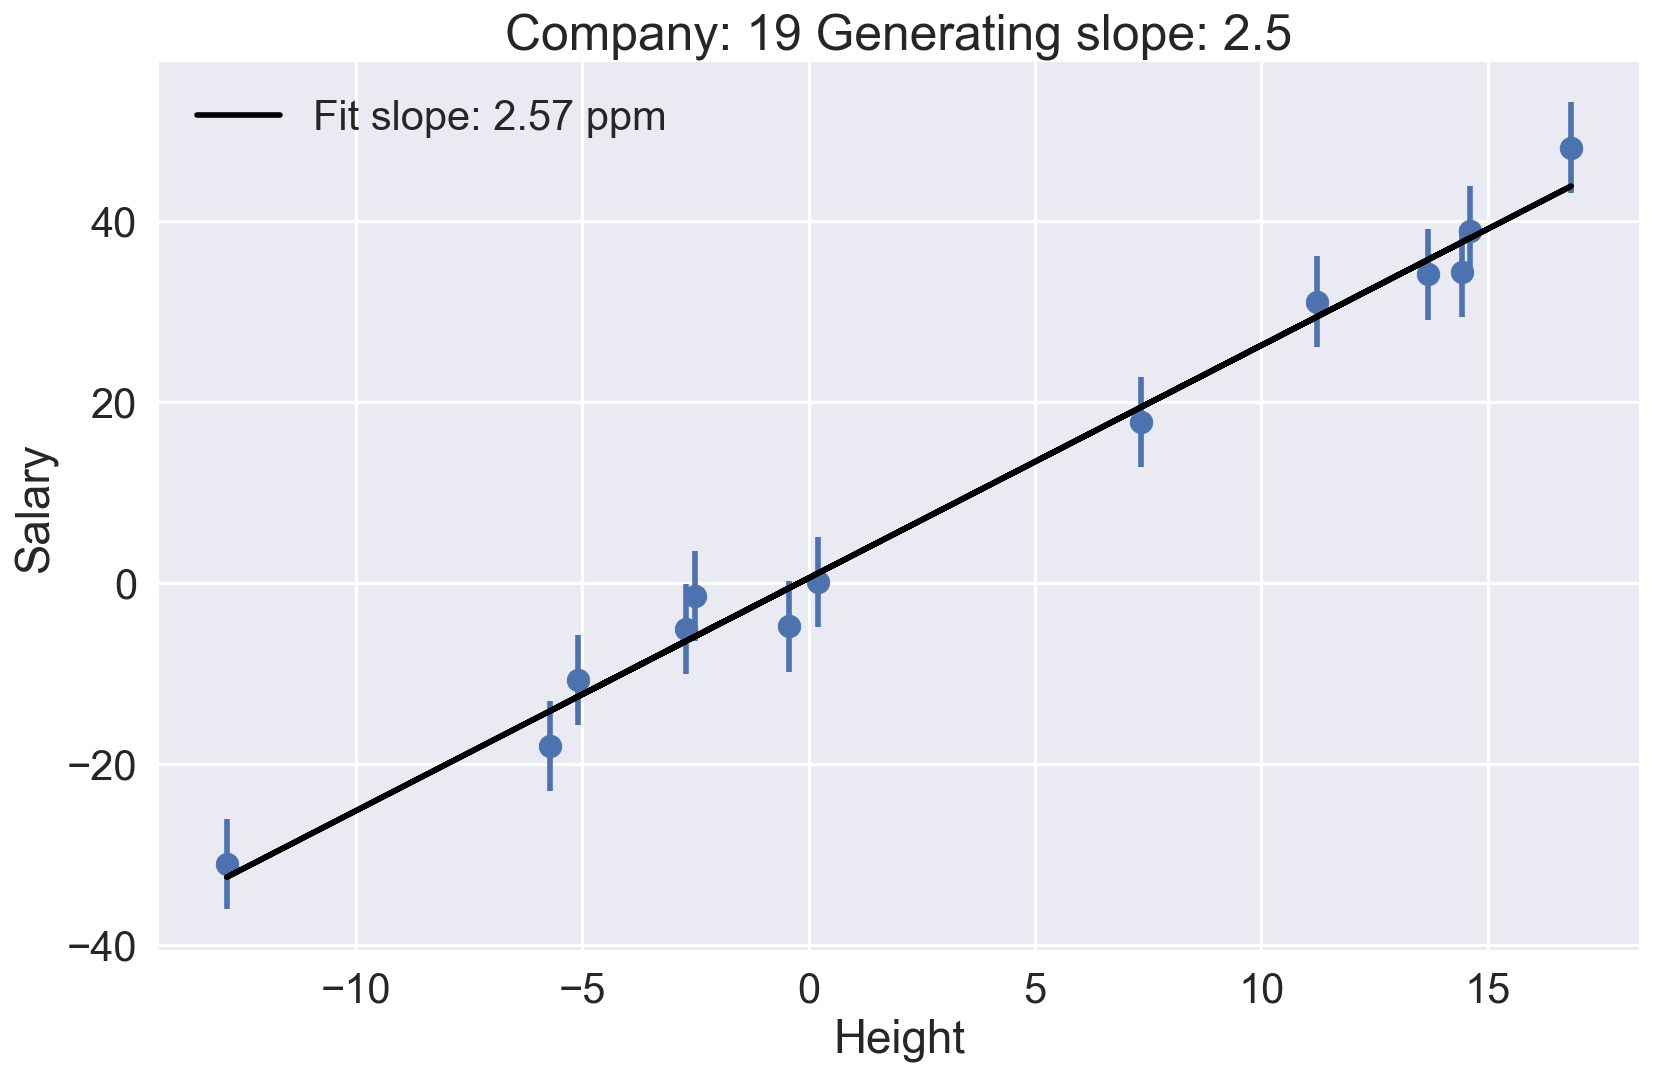

In [9]:
finestructure.finestructure.plot_example_company(19, 2.5, df_a)

The above plot was generated for company number 19, with a slope of 2.5, and a best fit line is clearly a decent fit to the data. They measured total of 888 salary measurements were made across 140 companies throughout the Northern half of the country.

They reported the slopes and error on the slope for Salary vs Height for each company. The data looks like:

In [11]:
keck[['delta_alpha', 'error_delta_alpha']].reset_index().rename(columns={'delta_alpha':'slope',
                                                                         'error_delta_alpha':'error',
                                                                         'index':'Company'
                                                                        }).head()

Company  slope  error
0        0   0.34   7.27
1        1  36.05  39.54
2        2 -12.53  11.67
3        3 -78.43  35.48
4        4 -31.05  24.33

The multipanel plot below shows how this is done for each system (company) for a different value of $\alpha$:

 - the vshifts of the system plotted as observed (top panel)
 - the same vshifts plotted in 'x' space (middle panel)
 - the slope of the line for the system, plotted as a single point (bottom panel).

The error on the slope is simply taken from the corresponding error reported in the original analysis.

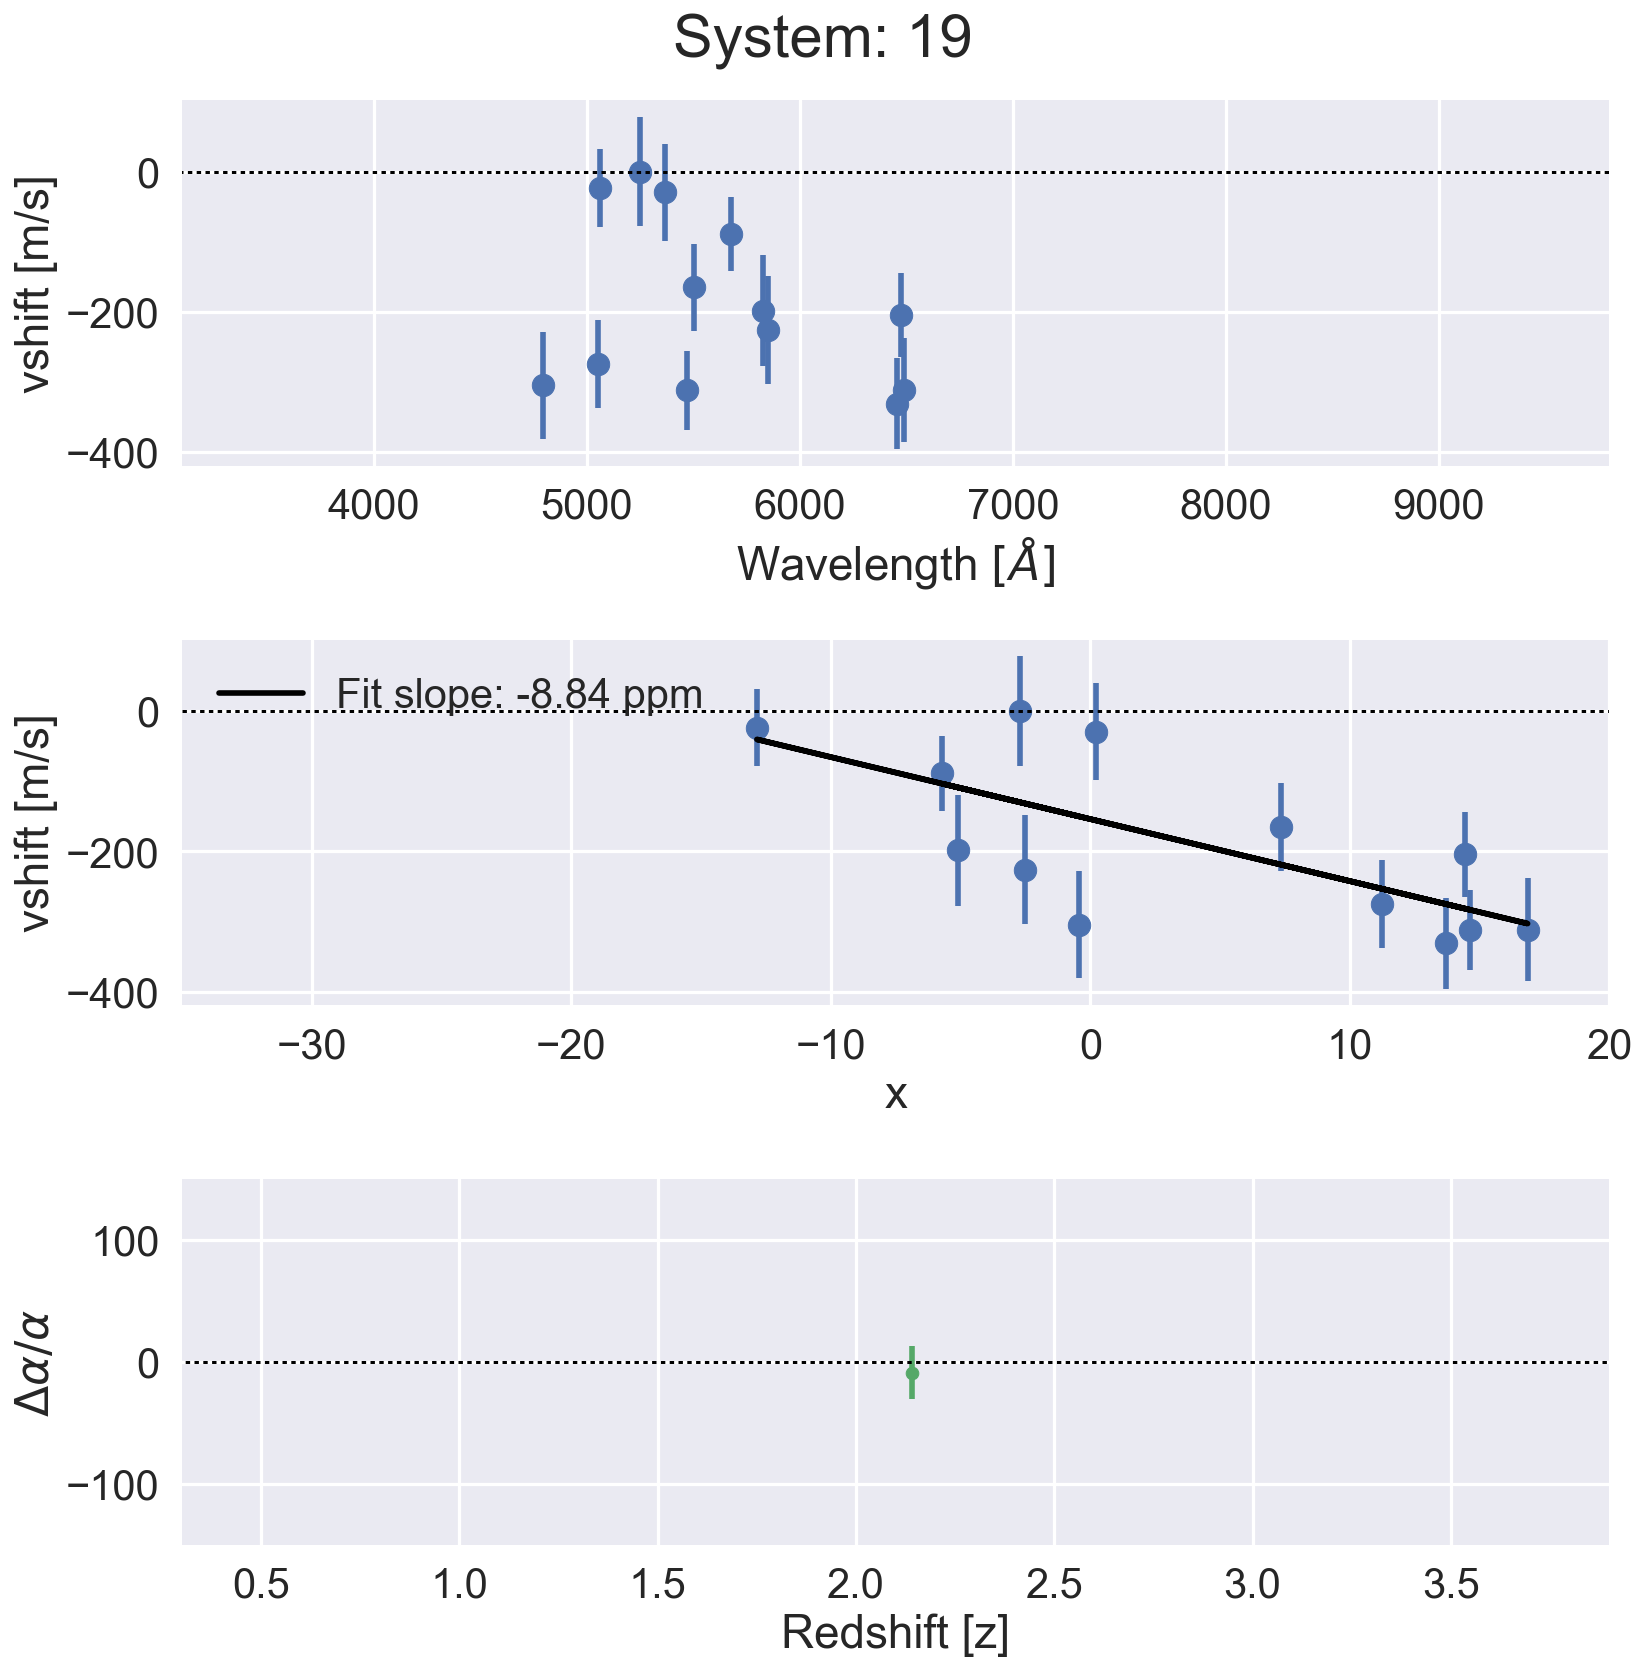

In [197]:
system_index = 19 # choose from 0 -- 292
g = df_a.groupby('system')    
finestructure.finestructure.plot_system_to_ensemble(g, system_index, all_systems=all_systems);

A bunch of other information was recorded at the same time (when the measurement was made, and so on). So they summarized the results across 140 companies by plotting the slope value vs when measurement was made (because if there were some height-bias in the different salaries, it might have changed over time). Remember the expected relationship for this plot should be a bunch of (statistical) zeros.

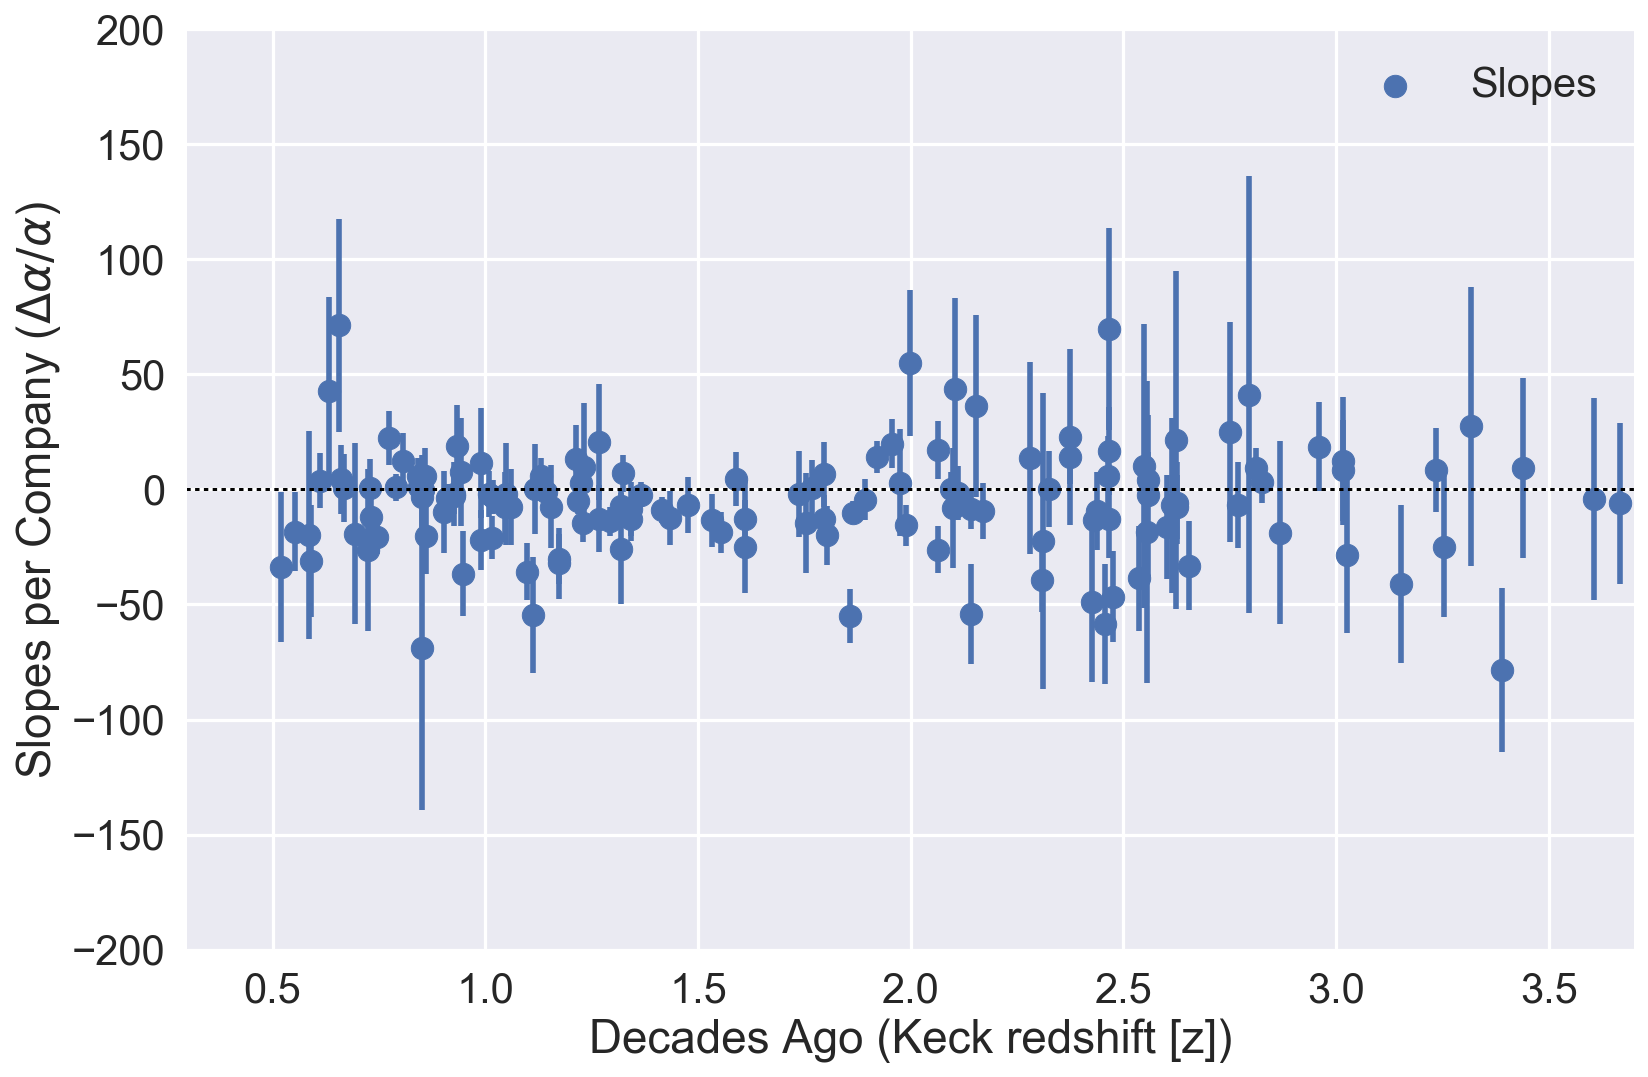

In [18]:
finestructure.finestructure.plot_example_telescope_results()

Taking a weighted mean of all slope measurements, they found a non-zero result of **-5.7 $\pm$ 1.1 ppm**.

There were a few relationships that might make sense. For example, a relationship that changed over time. They took a weighted mean of measurements in time, binned so that each bin would contain roughly an equal number of companies. The next 2-panel plot shows the individual measurements (repeated from above plot) in the upper panel colored to correspond with the color their weighted bin on the lower panel. (The horizontal lines on the upper panel denote the limits on the y-axis for the lower panel). 

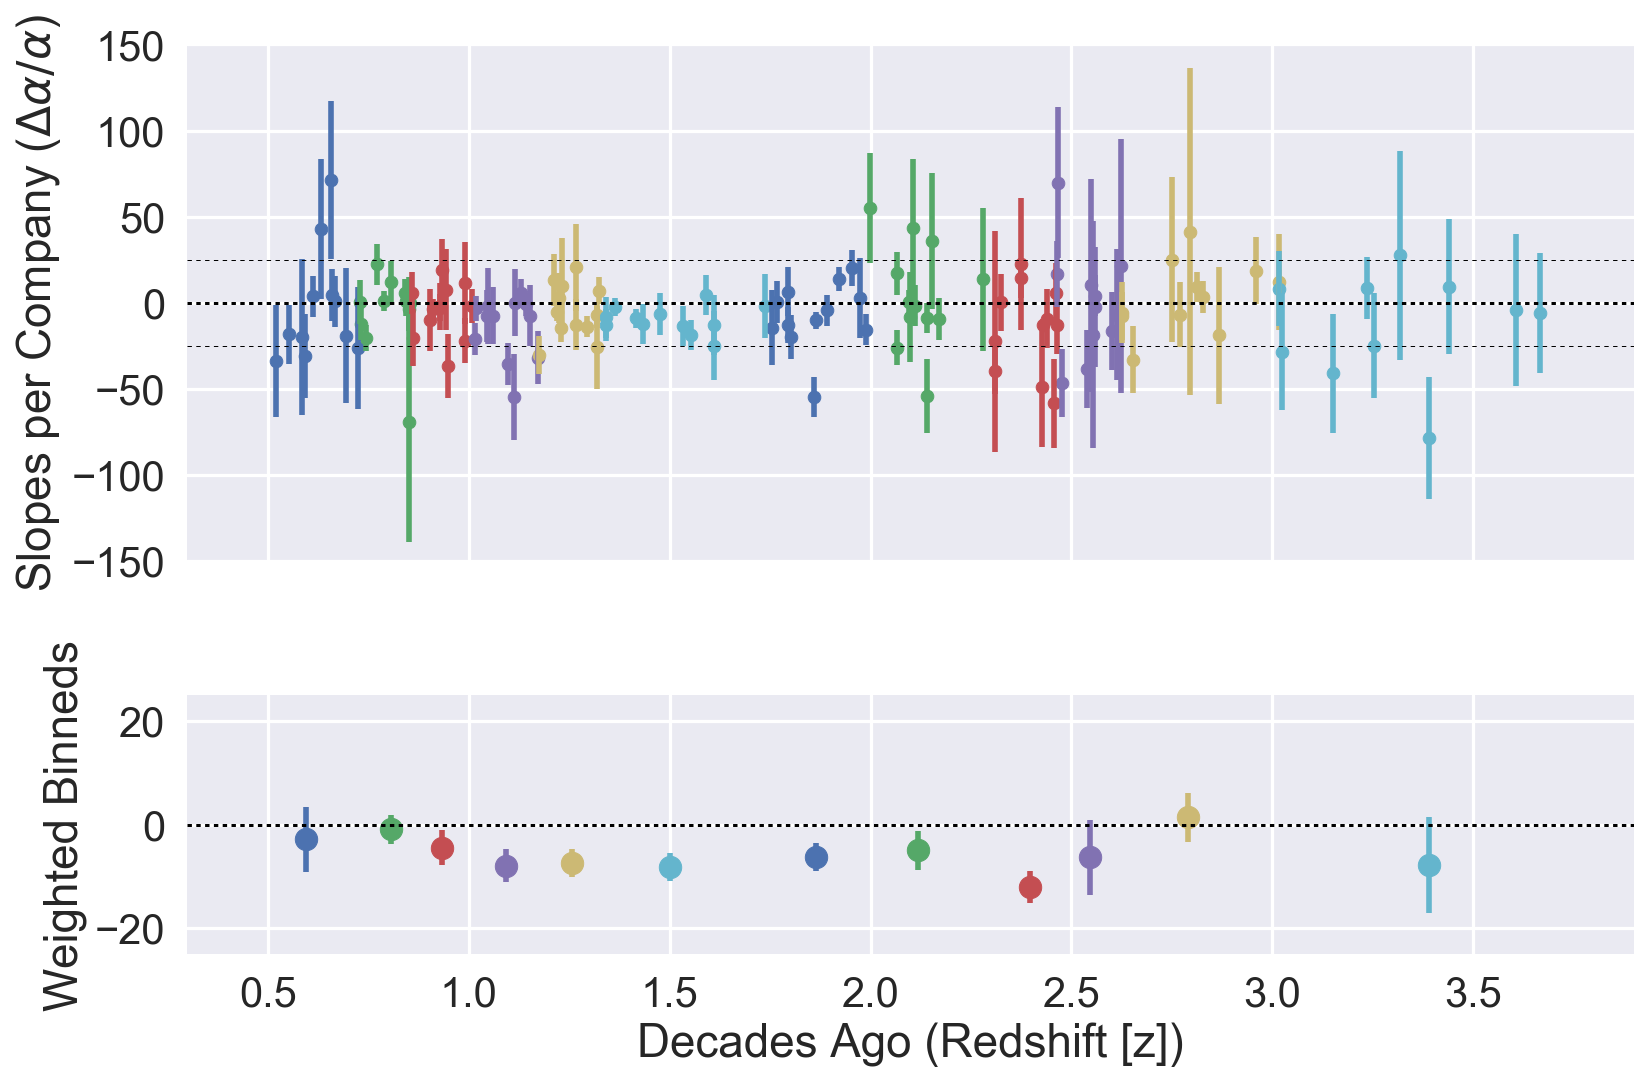

In [22]:
finestructure.finestructure.plot_example_telescope_bins(nbins=12, dataframe=keck)

This looks very interesting! But we only looked at the Northern half of the country. Another team of researchers went off to measure the Southern half using a different instrument. And they measured the following:

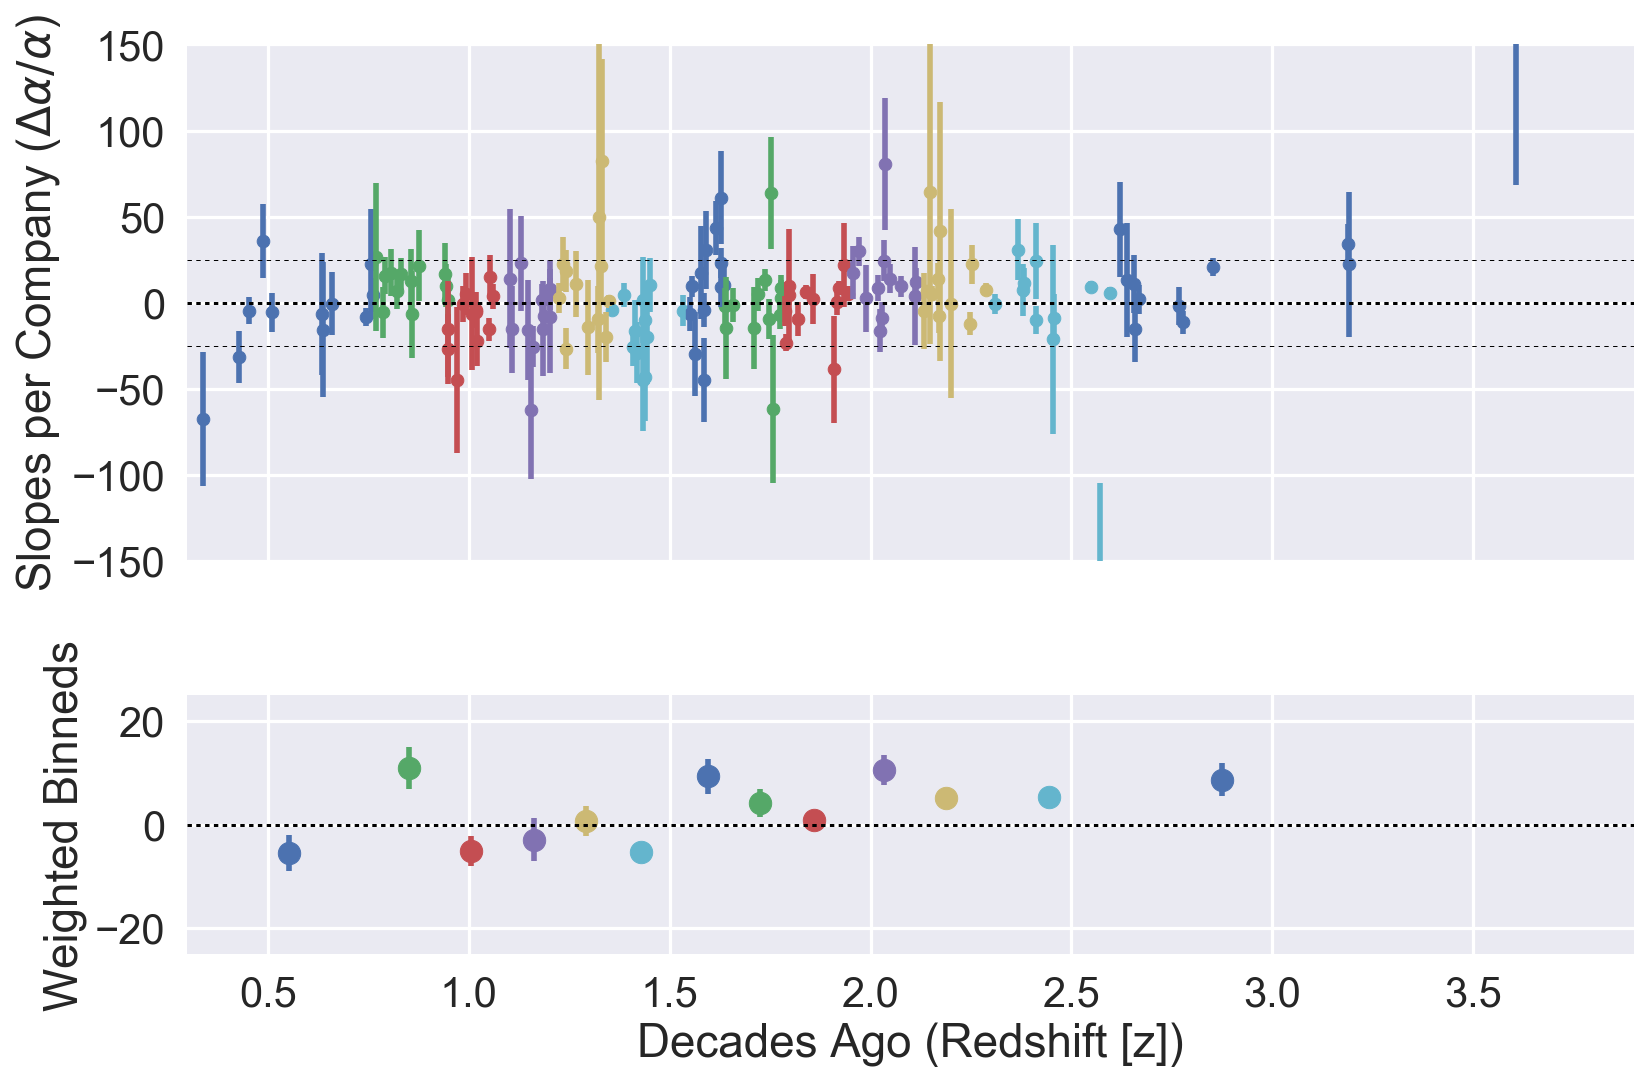

In [23]:
finestructure.finestructure.plot_example_telescope_bins(nbins=13, dataframe=vlt)

A surprising result! The weighted bins are no longer uniformly negative, but appear to switch from negative to positive around 1.5 decades ago. Because the data include the lat/longitude of each of these companies, they went to see if they could fit a model that took into account spatial differences. 

Aside: If you want to think of this semi-accurately, the country is around an entire planet, with companies appearing at specific locations. And there is a gradient across the whole planet that can be thought of in terms of Latitude alone from some "South" pole that is a free parameter. The fitting model is technically called a dipole, so I will call it a "dipole fit" and "dipole model" so that I don't confuse myself.

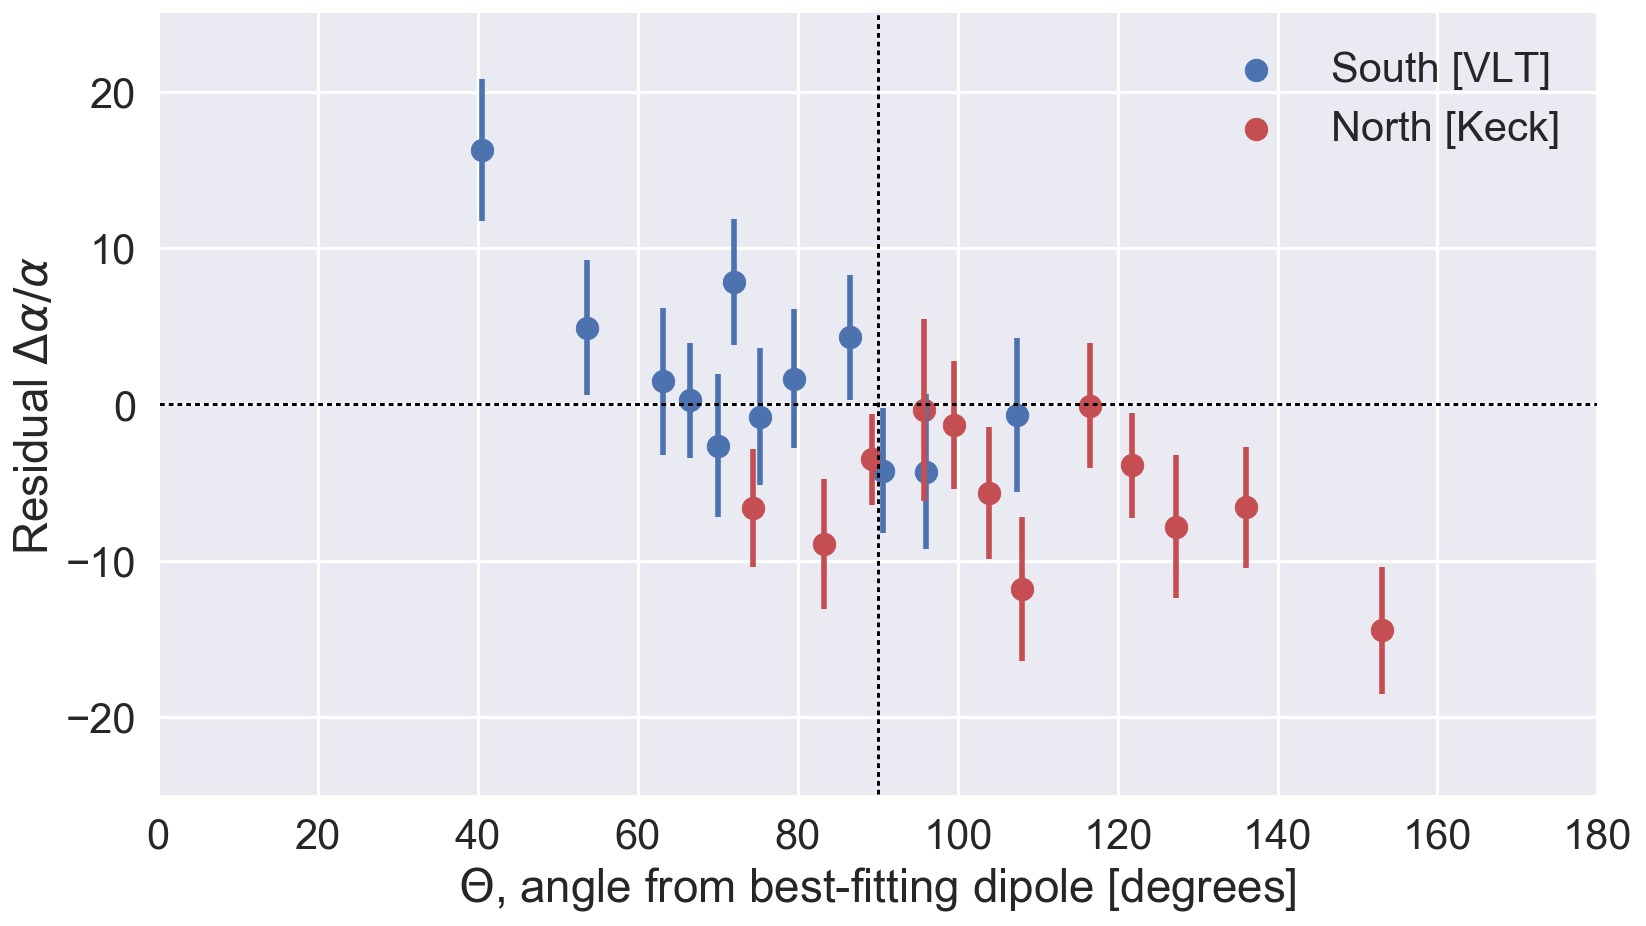

In [134]:
fig, ax = plt.subplots(figsize=(12, 7))
finestructure.finestructure.plot_a_v_theta(vlt, color=0, nbins=12, label='South [VLT]')
finestructure.finestructure.plot_a_v_theta(keck, color=2, nbins=12, label='North [Keck]')

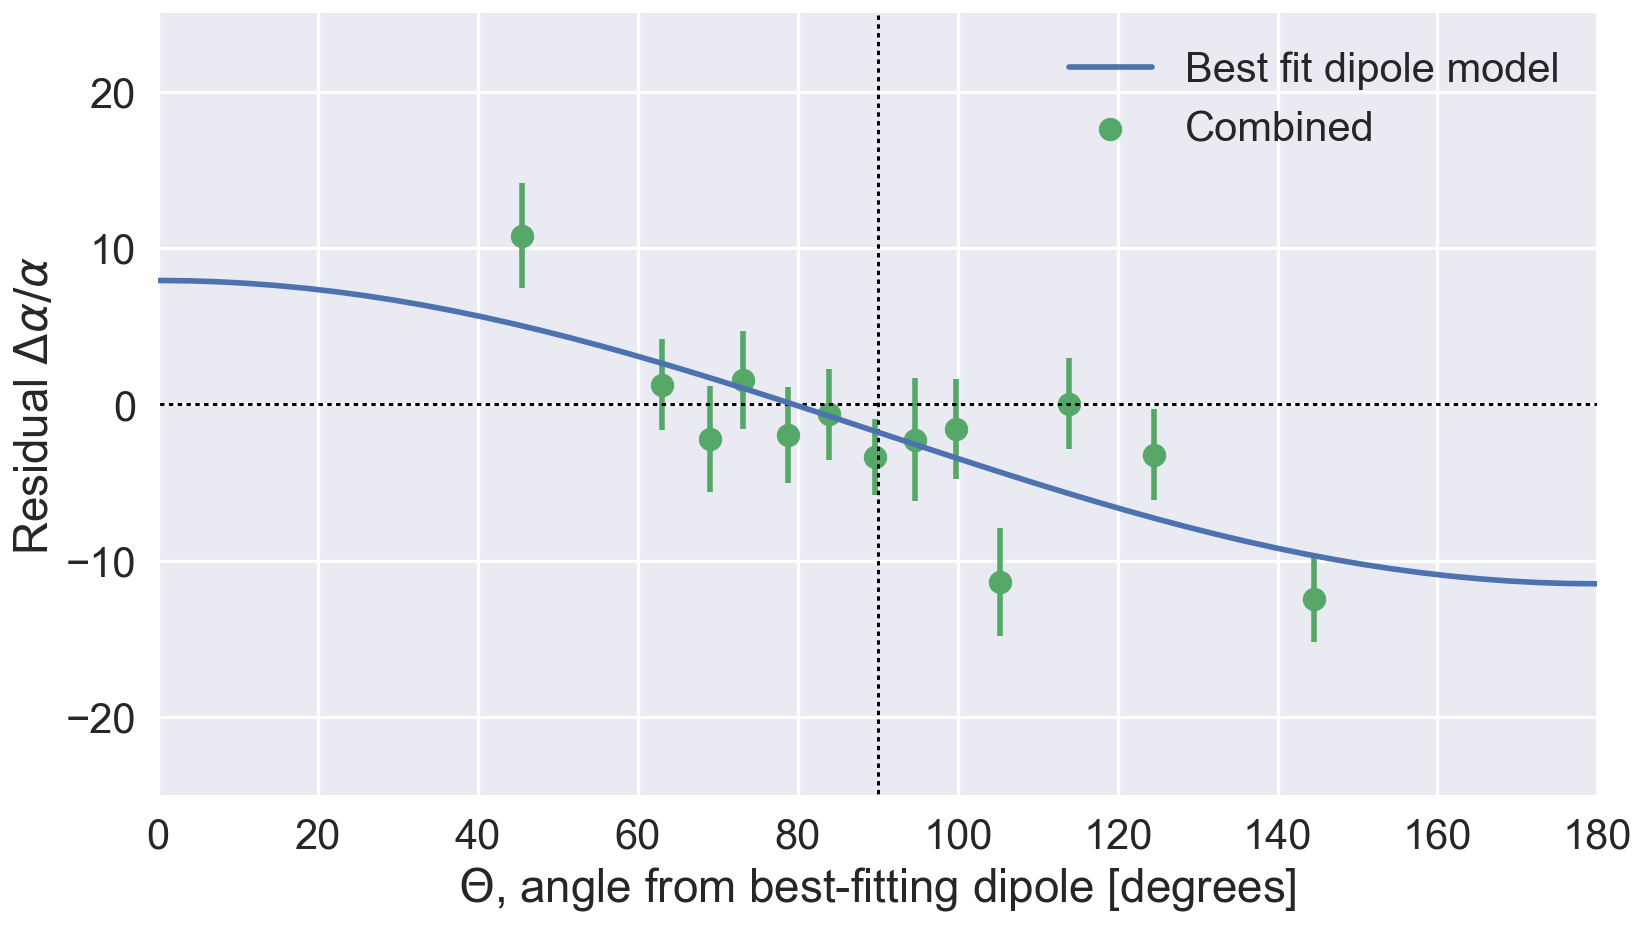

In [137]:
fig, ax = plt.subplots(figsize=(12, 7))
x = np.linspace(0, 180)
plt.plot(x, 
         DIP_AMPLITUDE * 1e6 * np.cos(np.deg2rad(x)) + DIP_MONOPOLE * 1e6,
         label="Best fit dipole model")

finestructure.finestructure.plot_a_v_theta(all_systems, color=1, nbins=13, label='Combined')

# Recap

As of this part in the story:

|Instrument| Companies (slope) measurements |Salary Measurements|
|:--|--|--|
|Keck (North)| 140| 888|
|VLT (South)| 153 | 1086|
|Total|293|1974|

With the only thing being reported is the 293 Company (or slope) measurements (plus estimated error on each measurement). In other words, we don't have the salary measurements directly.

## A small wrinkle

Another group of scientists discovers a systematic error in the way the salary measurements are being made. Not only do we have height, salary, and location data, we also have each employee's hair length. It turns out that there is no relationship between height and hair length. However, for even further contrived reasons, there is a systematic error between an employee's hair length and their measured salary! 

Just to provide a mental model of what happens, try the following example. For the Southern companies, they use 2 rulers to measure the length of an employee's hair, one for if their hair is less than say... 5 cm, and another one for if their hair is longer than 5 cm. The Northern companies use 1 ruler to measure their employee's hair.

The thing is, for all of these rulers, on a per-company basis, they might introduce a systematic error in the recorded . The good news is that if there's an error, it's reasonably well-behaved. So, for the 2-ruler system, you'd have something that might look like: 

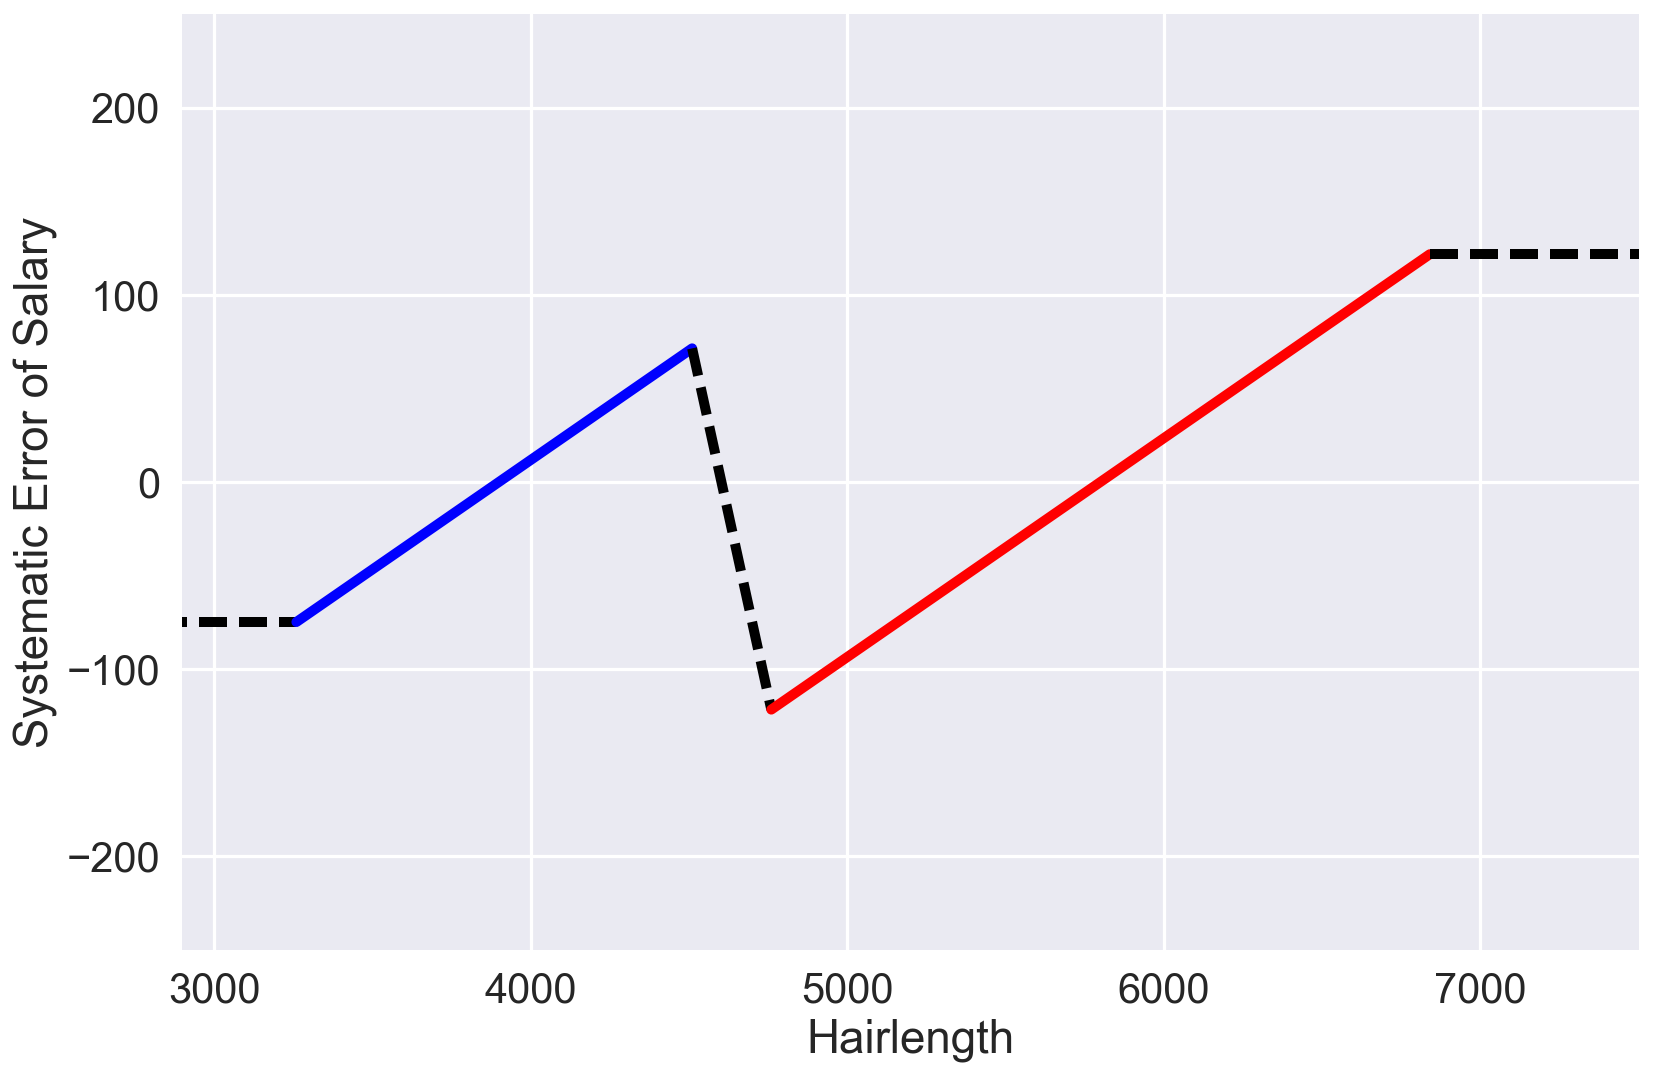

In [198]:
finestructure.finestructure.plot_example_systematic(run17)

Where the two rulers show up clearly as two lines w/ roughly the same slope. The y-intercept of this is meaningless, as we only can ever know the relative salary differences per company. 

Switching back to the actual literature again, the Dipole paper (2012 King, et al.,) shows an initial pass at uncovering a systematic velocity shift: 

<img src="../img/king-fig-29.png" alt="Fig. 29 2012 King, et al." style="width: 400px;"/>

Sidenote: I think that the way we are plotting the systematic velocities differ by a minus sign. This comes in because of how I tried to deal with `vpfit` (shifting the region did the opposite of what I expected).

# The Ask

Is there a rigorous way to analyze the data **using the salary measurements** for each company, across each instrument, to put some kind of credible interval or confidence interval on the hypothesis that there is a non-zero slope in height vs salary?

I'm hoping to show through simulations how the salary measurements could be combined in, perhaps, some kind of generalize linear modeling to show that if there is a non-zero slope in the presence of systematic errors, it can be recovered. And if there isn't that is recovered as well.

Because currently, the state-of-the-art is to retain the slope value per company (a total of 293 measurements so far) -- and combine those measurements into a larger model. I'm arguing for using the underlying salary measurements (a total of 1974) to discriminate these hypotheses.

# Further thoughts and lines of reasoning

When fitting the system, there two ways of plotting/understanding them. The observed wavelength reference frame, and the "x" reference frame. 

When fitting the ensemble of systems, there are several physically motivated ways: position across the sky (dipole angle); redshift z (decades ago); 

Because the universe is expanding, the wavelength of the observed systems are being [redshifted](https://en.wikipedia.org/wiki/Redshift), and so appear at many different wavelengths. In contrast, the "x" reference frame will always observe the species line in the same place.

The plot below shows the observed wavelengths of all of the individual lines against `qval` -- which is sensitivity to $\alpha$. The implied horizontal lines show the same transition as a function of its observed wavelength.

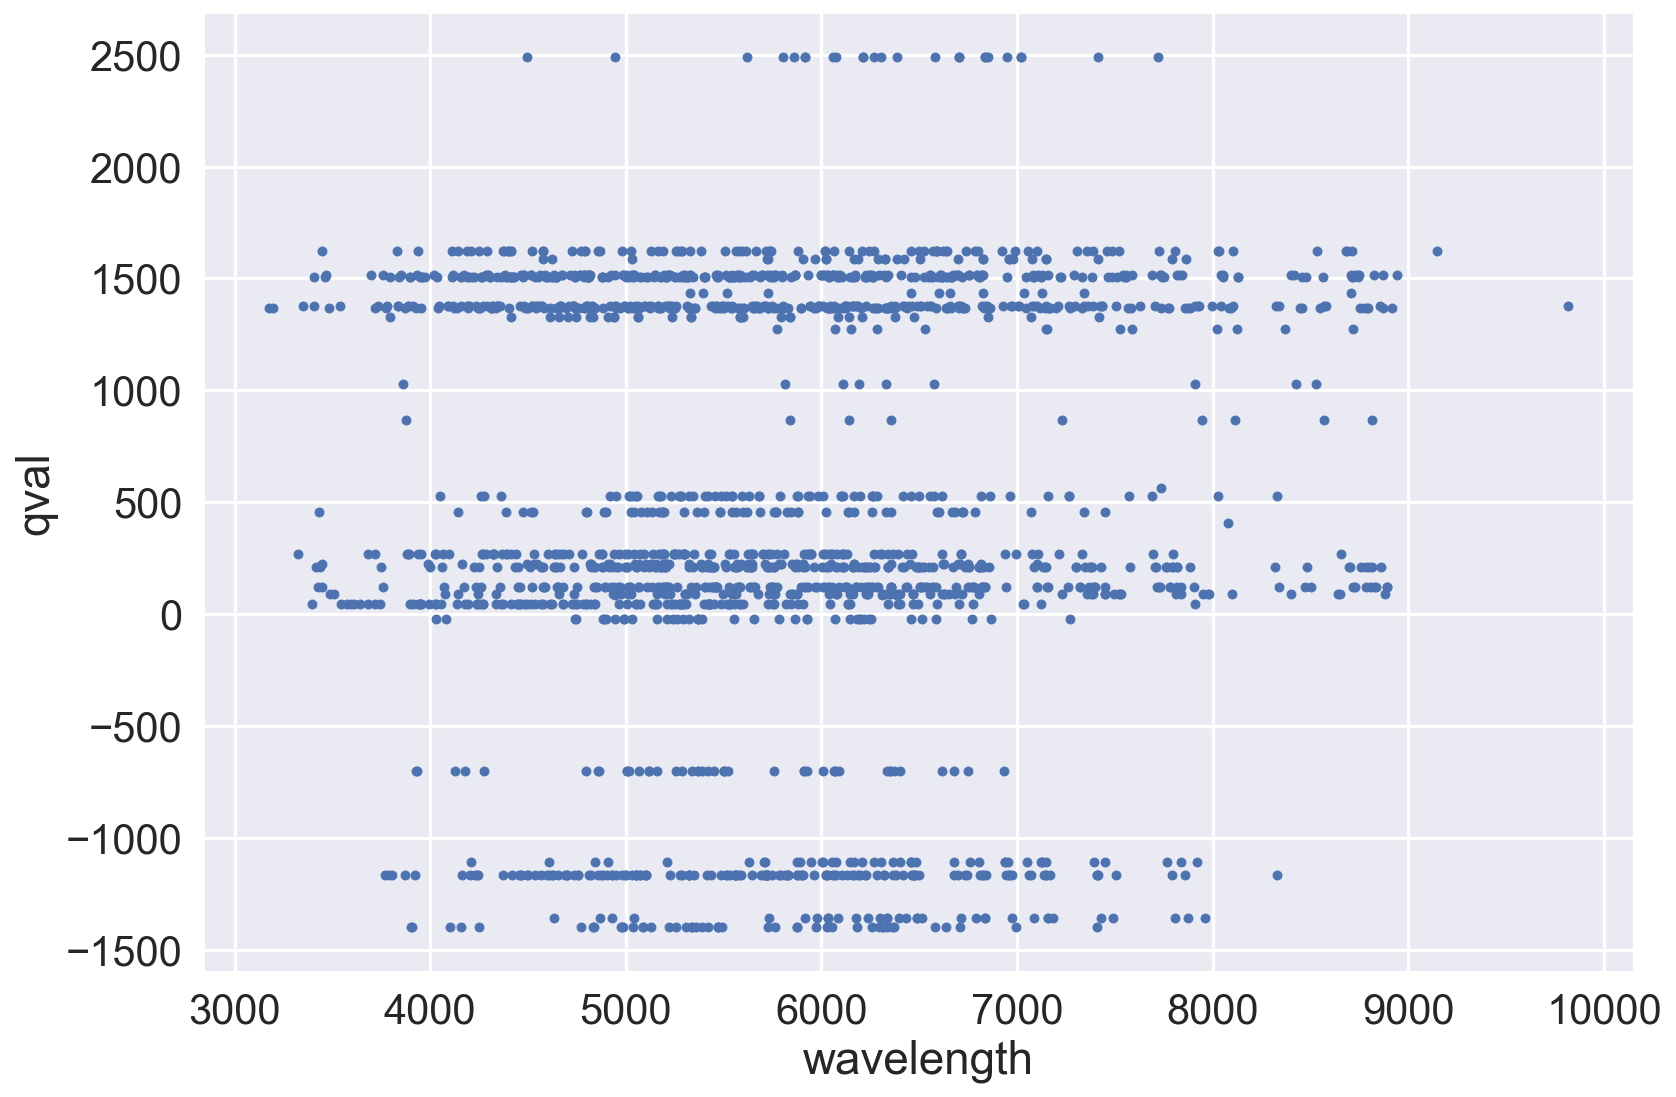

In [186]:
df_a.plot.scatter('wavelength', 'qval');

# Plot some $\chi^2$ curves

I'm going to plot the $\chi^2$ curves of the two telescopes separately because I have strong evidence that shows they have different systematic errors.

Further, I'm going to use the statistical error on each slope (alpha) measurement, and not the inflated error estimate from the Least Trimmed Squares method in King, et al., 2012. My main reason for that is that the assumption that there is a **random** systematic error is the very thing we are investigating.

In [199]:
def chisq(system=vlt,
          fit_alpha='dipole_delta_alpha',
          alpha_col='delta_alpha',
          error_col='error_delta_alpha',):
    return np.sum((system[alpha_col] - system[fit_alpha]) ** 2.0 / (system[error_col] ** 2.0))

In [220]:
simvlt = vlt.copy()
simkeck = keck.copy()

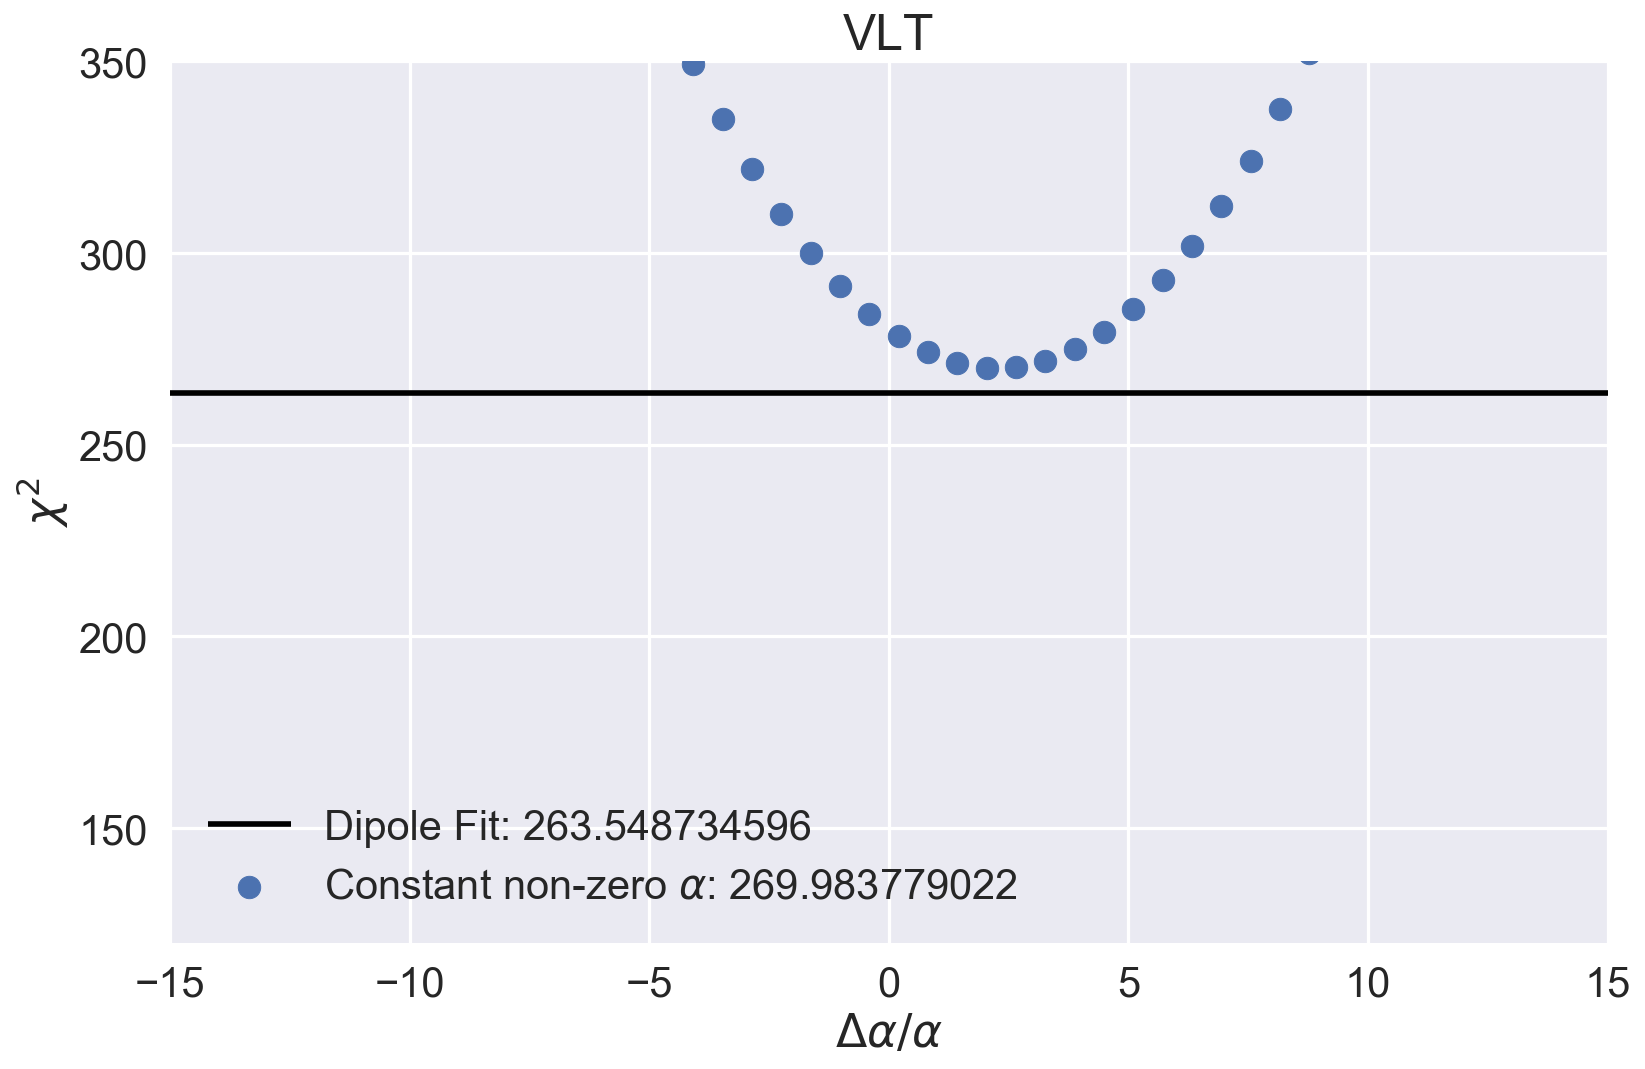

In [227]:
fig, ax = plt.subplots(figsize=(12, 8))
chisquare = chisq(system=vlt)
ax.hlines(chisquare, -30, 30, label='Dipole Fit: ' + str(chisquare))


weightav = np.average(simvlt.delta_alpha, weights=(1.0 / simvlt.error_delta_alpha**2.0))
simvlt['const-alpha'] = weightav
constchisquare = chisq(system=simvlt, fit_alpha='const-alpha')

for index, alpha in enumerate(np.linspace(-20, 10)):
    simvlt['const-alpha'] = alpha
    if index == 0:
        label = r'Constant non-zero $\alpha$: ' + str(constchisquare)
    else:
        label = ''
    ax.scatter(alpha, chisq(system=simvlt, fit_alpha='const-alpha'), c=sns.color_palette()[0], label=label)

ax.set_xlim(-15, 15)
ax.set_ylim(120, 350)
ax.set_xlabel(r"$\Delta \alpha/\alpha$")
ax.set_ylabel(r"$\chi^2$")

ax.legend()
ax.set_title("VLT")
fig.tight_layout();

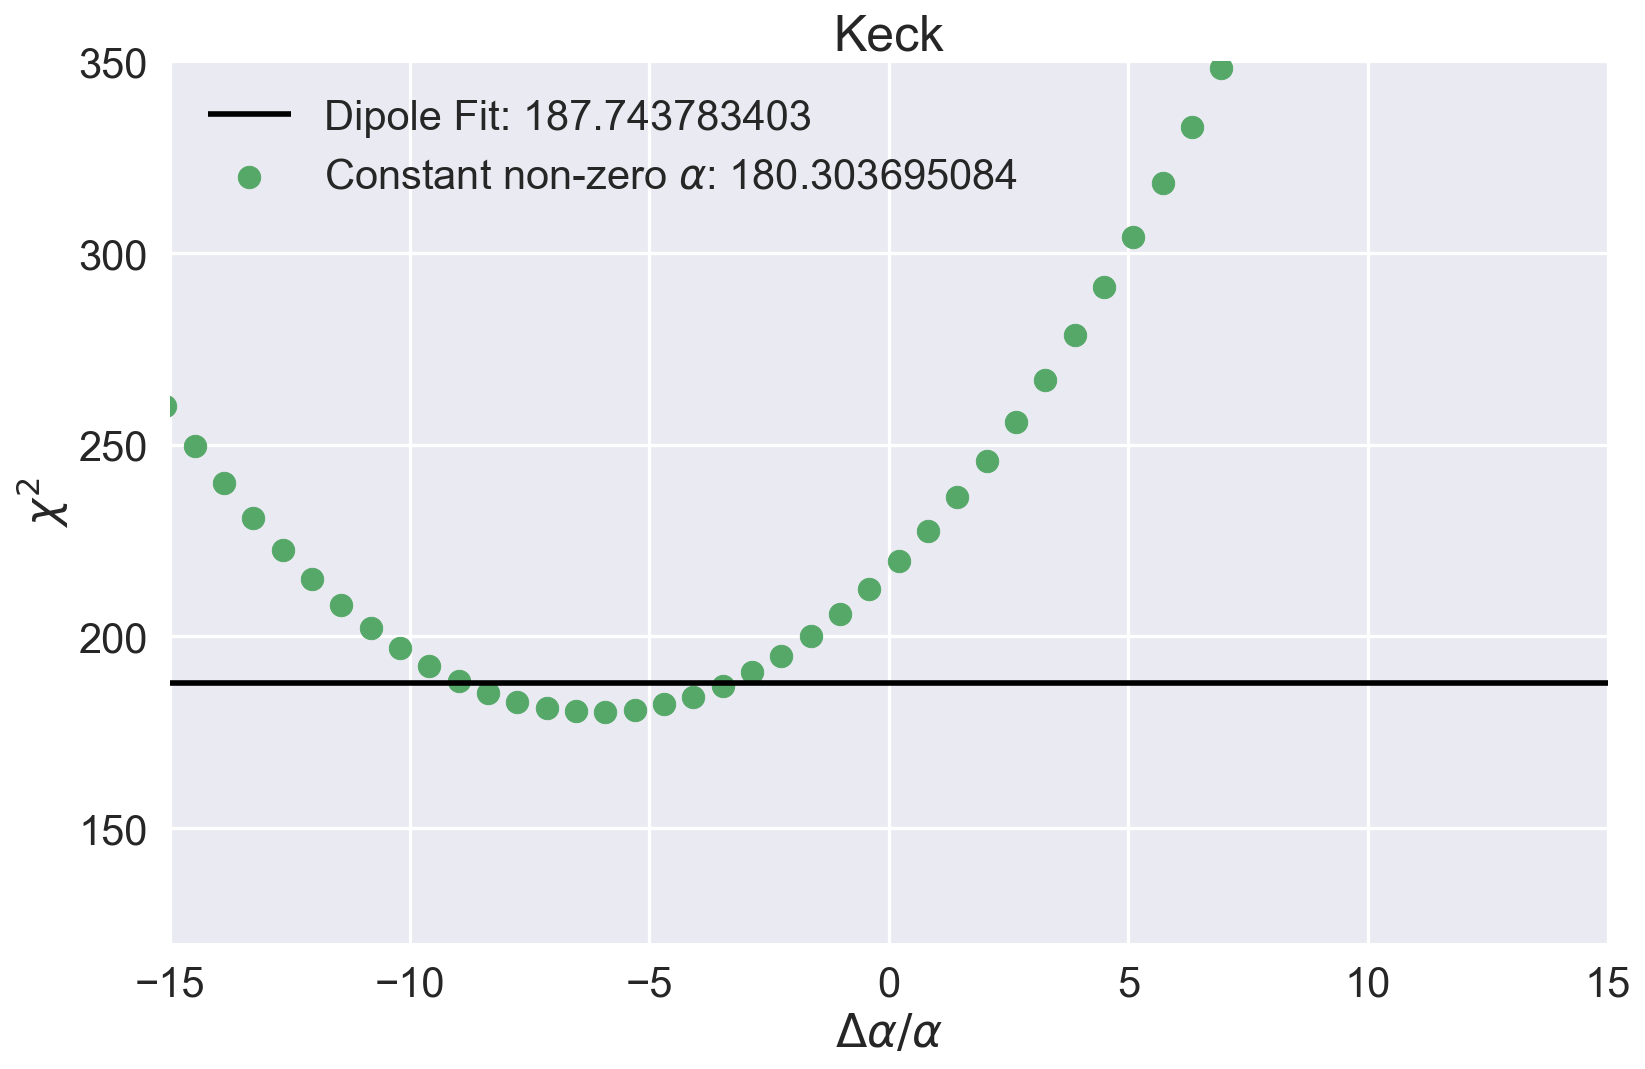

In [228]:
fig, ax = plt.subplots(figsize=(12, 8))
chisquare = chisq(system=keck)
ax.hlines(chisquare, -30, 30, label='Dipole Fit: ' + str(chisquare))


weightav = np.average(simkeck.delta_alpha, weights=(1.0 / simkeck.error_delta_alpha**2.0))
simkeck['const-alpha'] = weightav
constchisquare = chisq(system=simkeck, fit_alpha='const-alpha')

for index, alpha in enumerate(np.linspace(-20, 10)):
    simkeck['const-alpha'] = alpha
    if index == 0:
        label = r'Constant non-zero $\alpha$: ' + str(constchisquare)
    else:
        label = ''
    ax.scatter(alpha, chisq(system=simkeck, fit_alpha='const-alpha'), c=sns.color_palette()[1], label=label)
    
ax.set_xlim(-15, 15)
ax.set_ylim(120, 350)
ax.set_xlabel(r"$\Delta \alpha/\alpha$")
ax.set_ylabel(r"$\chi^2$")

ax.legend()
ax.set_title("Keck")
fig.tight_layout();

In [229]:
simall = all_systems.copy()

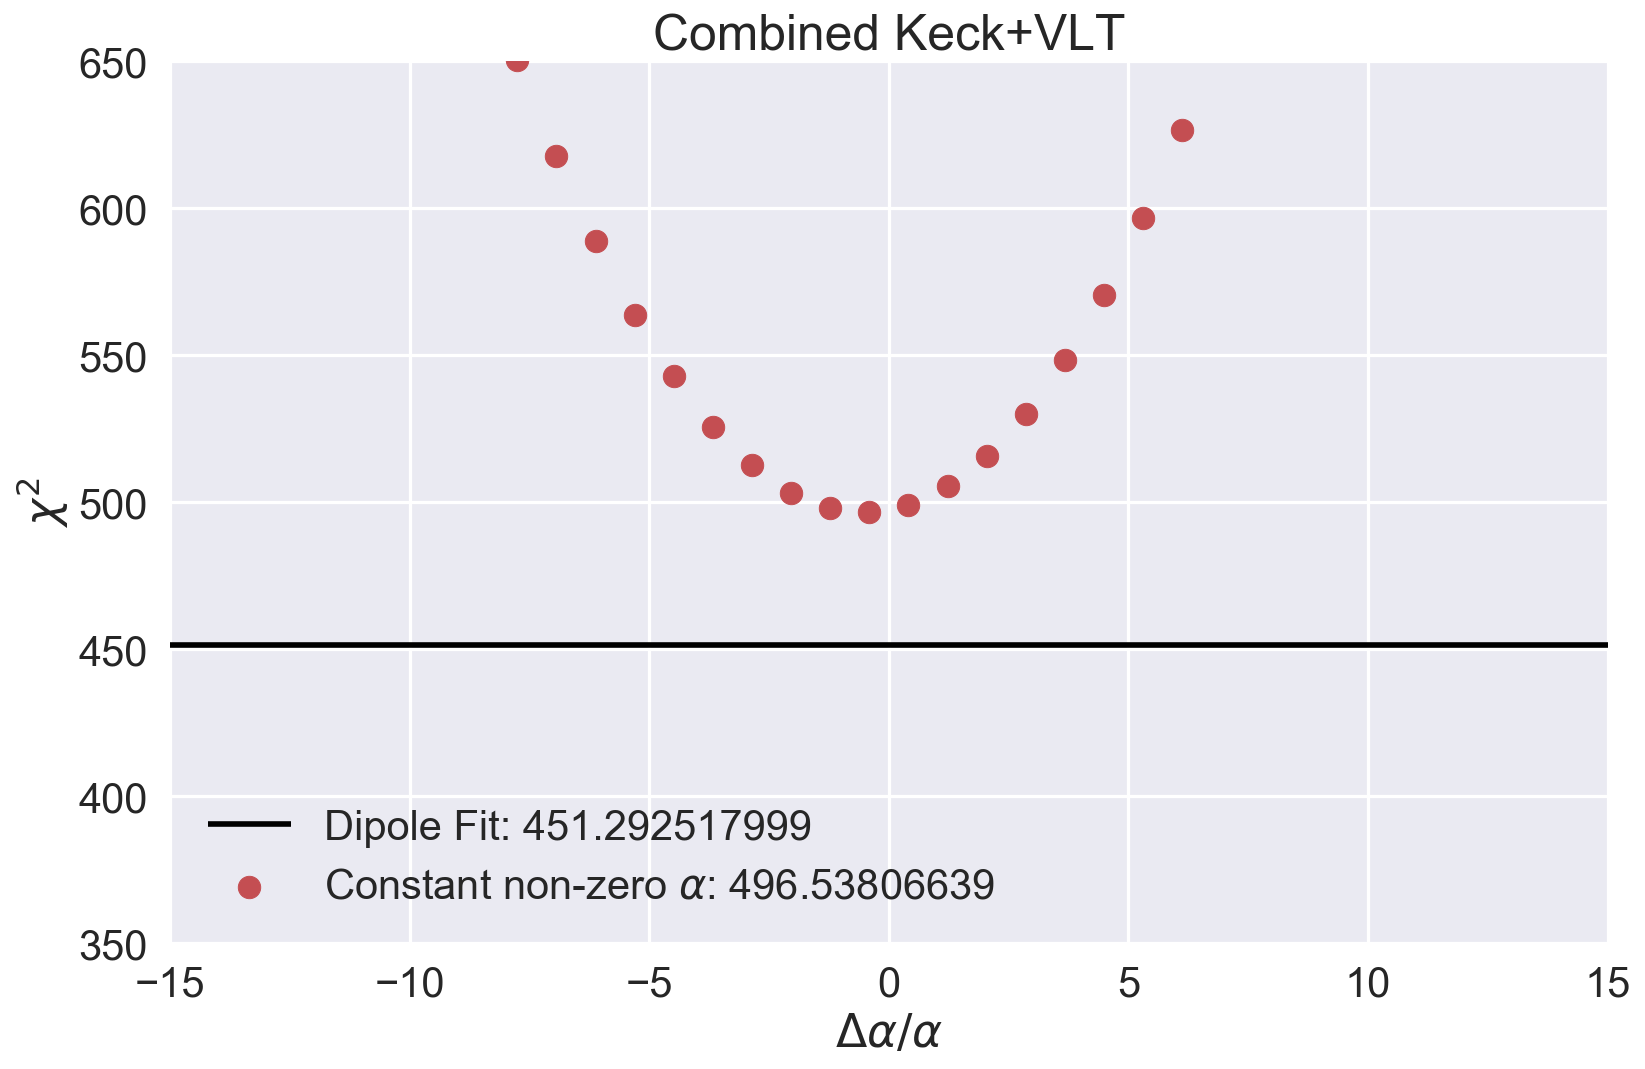

In [232]:
fig, ax = plt.subplots(figsize=(12, 8))
chisquare = chisq(system=all_systems)
ax.hlines(chisquare, -30, 30, label='Dipole Fit: ' + str(chisquare))


weightav = np.average(simall.delta_alpha, weights=(1.0 / simall.error_delta_alpha**2.0))
simall['const-alpha'] = weightav
constchisquare = chisq(system=simall, fit_alpha='const-alpha')

for index, alpha in enumerate(np.linspace(-20, 20)):
    simall['const-alpha'] = alpha
    if index == 0:
        label = r'Constant non-zero $\alpha$: ' + str(constchisquare)
    else:
        label = ''
    ax.scatter(alpha, chisq(system=simall, fit_alpha='const-alpha'), c=sns.color_palette()[2], label=label)
    
ax.set_xlim(-15, 15)
ax.set_ylim(350, 650)
ax.set_xlabel(r"$\Delta \alpha/\alpha$")
ax.set_ylabel(r"$\chi^2$")

ax.legend()
ax.set_title("Combined Keck+VLT")
fig.tight_layout();

## What does a single constant slope line systematic look like?


In [218]:
df_a.wavelength.min(), df_a.wavelength.max()

(3178.1903749421999, 9817.0941418866005)

In [219]:
knot_positions = [3150.0, 9900.0]

In [233]:
def velocity_shift(wavelength, distortion):
    for segment in distortion:
        if (wavelength > distortion[segment]['waves_start']) and (wavelength <= distortion[segment]['waves_end']):
            slope = distortion[segment]['slope']
            offset = distortion[segment]['offset']
    return -(wavelength * slope + offset)

In [234]:
def offset(row, distortions):
    add_vshift = []
    for index, distortion in distortions.iterrows():
        if (row.wavelength > distortion.wav_min) & (row.wavelength < distortion.wav_max):
            add_vshift.append(row.wavelength * distortion.slope + distortion.intercept)
    if len(add_vshift) == 0:
        add_vshift.append(0.0)
    return np.average(add_vshift)

In [238]:
temp_vlt = finestructure.finestructure.create_blank_transitions_dataset(source=vlt)

In [317]:
blank_transitions = finestructure.finestructure.create_blank_transitions_dataset(source=vlt)
blank_transitions_keck = finestructure.finestructure.create_blank_transitions_dataset(source=keck)

In [318]:
def fit_distortion_model(key=(0, 0, 0, 50, 50),
                         min_chisq=500.0,
                         fit_dictionary=fit_dict,
                         verbose=True,
                         keck=False,
                        ):
    if 'chisq' not in fit_dictionary[key]:
        if keck:
            temp_vlt = blank_transitions_keck.copy()
        else:
            temp_vlt = blank_transitions.copy()
        temp_vlt['vshift'] = fit_dictionary[key]['interpolate'](temp_vlt.wavelength)
        temp_vlt_systems = fit_alpha(temp_vlt)
        if keck:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='VLT'],
                              fit_alpha='sim_fit_alpha')
        else:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='Keck'],
                  fit_alpha='sim_fit_alpha')
        fit_dictionary[key]['chisq'] = chisquare
        if verbose:
            print(pd.Timestamp('now').strftime("%Y-%m-%d %H:%M:%S"), key, chisquare)
    else:
        chisquare = fit_dictionary[key]['chisq']
        if verbose:
            print("Already fit:", key, chisquare)
    return chisquare

In [319]:
# todo use bayesian model with delta alpha/alpha and systematics and get a credible interval on both

In [271]:
results = fmin_l_bfgs_b(func=modified_fit_distortion_model,
                        x0=np.zeros_like(knot_positions)[1:],
                        args=(500.0, fit_dict, knot_positions),
                        epsilon=1.0,
#                         factr=10.0,
                        approx_grad=True,
                       )

(0, 0.0)
Already fit:        [0, 0] 280.251447477
(0, 1.0)
Already fit:        [0, 1] 280.375283561
(0, -1.0)
Already fit:        [0, -1] 280.127824802
(0, 0.0)
Already fit:        [0, 0] 280.251447477
(0, -5.0000000000000009)
2017-03-21 15:33:14 [0, -5] 279.635468183
(0, -4.0000000000000009)
2017-03-21 15:33:14 [0, -4] 279.758237225
(0, -21.0)
2017-03-21 15:33:15 [0, -21] 277.70018704
(0, -20.0)
2017-03-21 15:33:15 [0, -20] 277.819541549
(0, -85.0)
2017-03-21 15:33:16 [0, -85] 270.505387763
(0, -84.0)
2017-03-21 15:33:16 [0, -84] 270.611084139
(0, -580.27767909363206)
2017-03-21 15:33:17 [0, -580] 244.383707886
(0, -579.27767909363206)
2017-03-21 15:33:18 [0, -579] 244.383707886


In [298]:
knot_positions2 = [3150.0, 7000.0, 9900.0]

In [299]:
fit_dict2 = create_fit_dict(yvals=[0.0], knot_positions=knot_positions2)

In [300]:
results = fmin_l_bfgs_b(func=modified_fit_distortion_model,
                        x0=np.zeros_like(knot_positions2)[1:],
                        args=(500.0, fit_dict2, knot_positions2),
                        epsilon=1.0,
#                         factr=10.0,
                        approx_grad=True,
                       )

(0, 0.0, 0.0)
2017-03-21 15:56:34 [0, 0, 0] 280.251447477
(0, 1.0, 0.0)
2017-03-21 15:56:35 [0, 1, 0] 280.271753656
(0, 0.0, 1.0)
2017-03-21 15:56:35 [0, 0, 1] 280.363805497
(0, -0.17784634495119794, -0.98405826940659347)
2017-03-21 15:56:36 [0, 0, 0] 280.137468034
(0, 0.822153655048802, -0.98405826940659347)
2017-03-21 15:56:37 [0, 0, 0] 280.157783943
(0, -0.17784634495119794, 0.015941730593406533)
2017-03-21 15:56:37 [0, 0, 0] 280.249671829
(0, -0.88923172475598977, -4.9202913470329674)
2017-03-21 15:56:38 [0, 0, -4] 279.683050621
(0, 0.11076827524401023, -4.9202913470329674)
2017-03-21 15:56:38 [0, 0, -4] 279.703405451
(0, -0.88923172475598977, -3.9202913470329674)
2017-03-21 15:56:39 [0, 0, -3] 279.794637517
(0, -3.7347732439751566, -20.665223657538462)
2017-03-21 15:56:39 [0, -3, -20] 277.889386704
(0, -2.7347732439751566, -20.665223657538462)
2017-03-21 15:56:40 [0, -2, -20] 277.909897217
(0, -3.7347732439751566, -19.665223657538462)
2017-03-21 15:56:41 [0, -3, -19] 277.998506
(0

In [243]:
def best_fit_results(fit_dictionary=fit_dict):
    bestchi, key = sorted([(fit_dictionary[key]['chisq'], key) for key in fit_dictionary 
                           if 'chisq' in  fit_dictionary[key]])[0]
    return bestchi, key

In [306]:
bestchi, key = best_fit_results(fit_dict)
bestchi2, key2 = best_fit_results(fit_dict2)

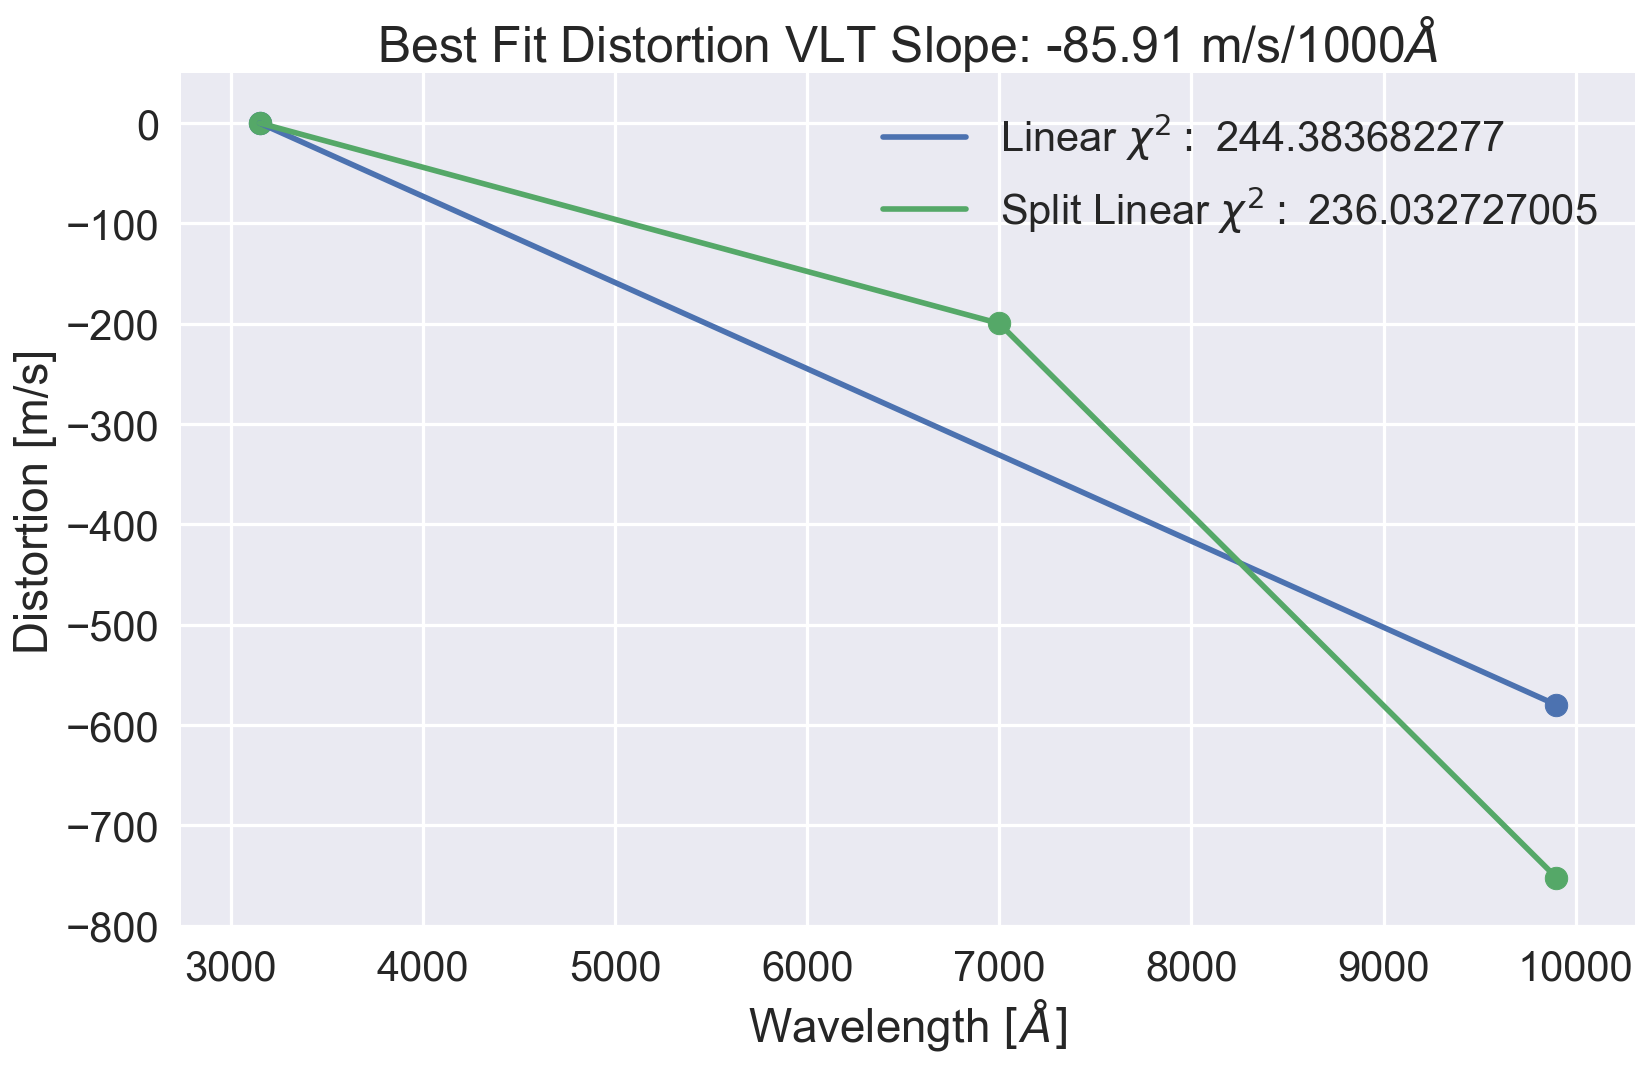

In [309]:
x = np.linspace(np.min(knot_positions), np.max(knot_positions), num=2000)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, fit_dict[key]['interpolate'](x), label=r"Linear $\chi^2:$ " + str(bestchi))
ax.scatter(knot_positions, fit_dict[key]['interpolate'](knot_positions))
ax.plot(x, fit_dict2[key2]['interpolate'](x), label=r"Split Linear $\chi^2:$ " + str(bestchi2))
ax.scatter(knot_positions2, fit_dict2[key2]['interpolate'](knot_positions2))
ax.set_ylabel("Distortion [m/s]")
ax.set_xlabel(xlabel_wavelength)
slope = (-579.87767909387571) / (knot_positions[1] - knot_positions[0]) * 1.0e3

ax.set_title("Best Fit Distortion VLT Slope: "
             + '{:{width}.{prec}f}'.format(slope, width=5, prec=2)
             + r" m/s/1000$\AA$")
ax.legend()
fig.tight_layout()

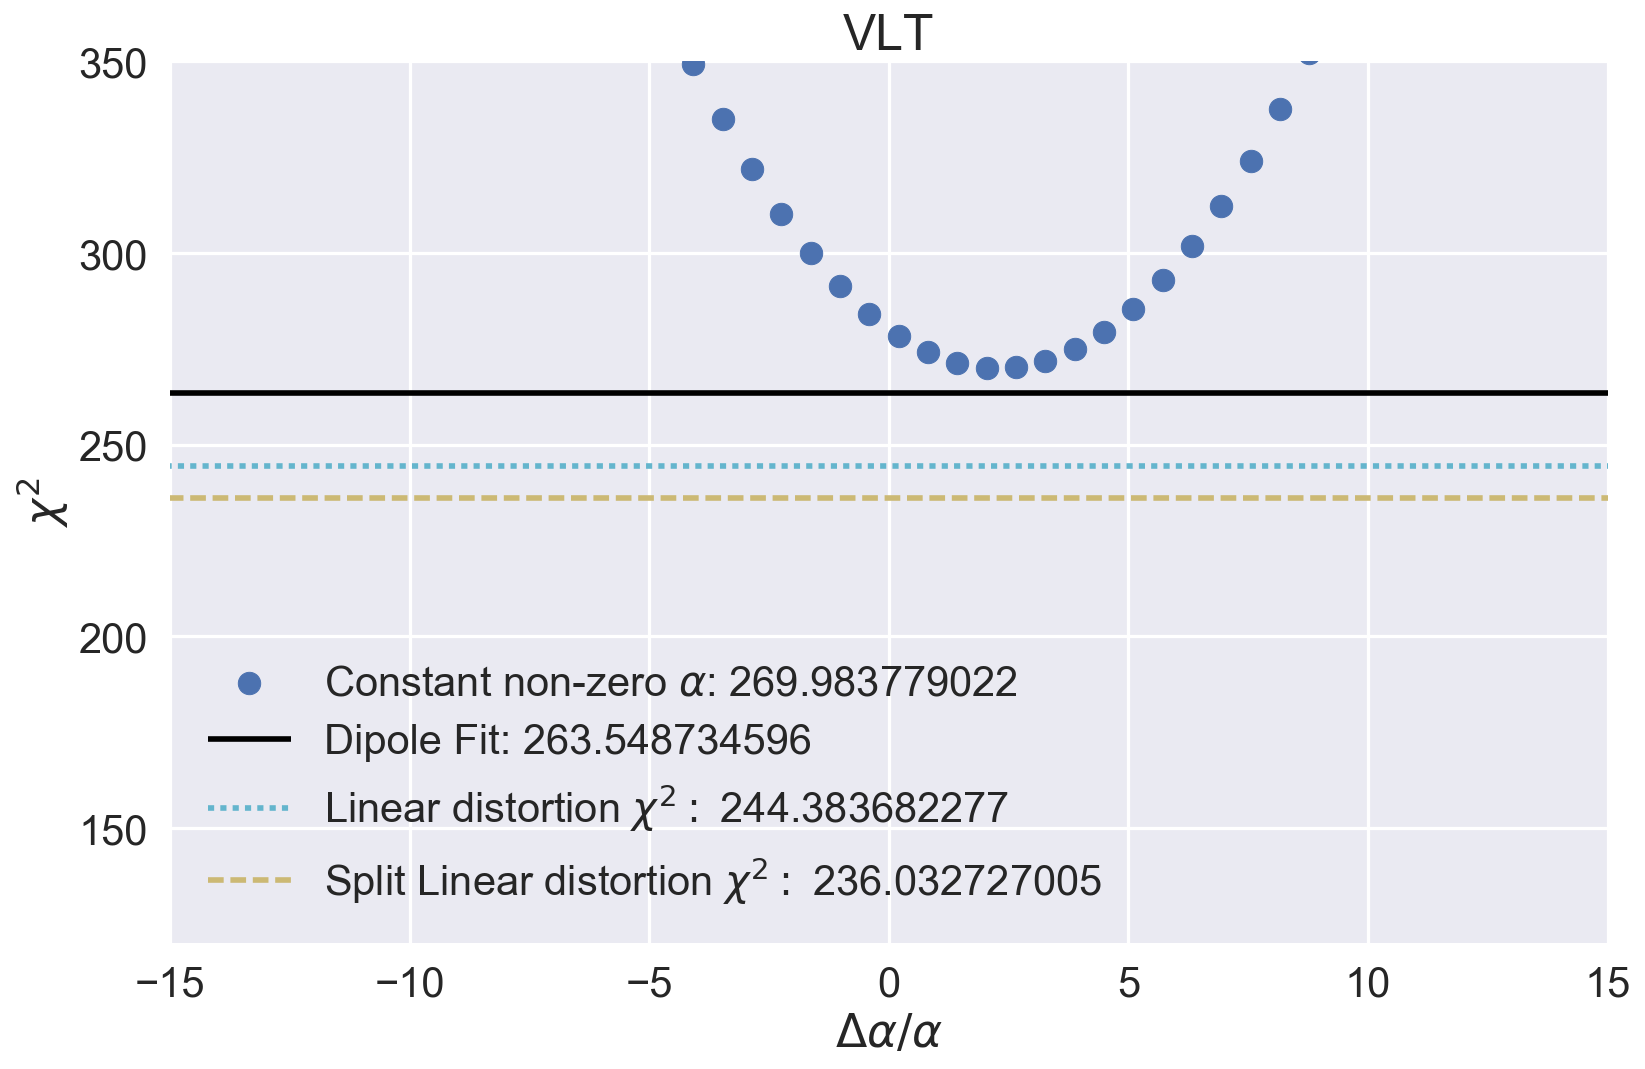

In [314]:
bestchi, key = best_fit_results(fit_dict)

fig, ax = plt.subplots(figsize=(12, 8))


weightav = np.average(simvlt.delta_alpha, weights=(1.0 / simvlt.error_delta_alpha**2.0))
simvlt['const-alpha'] = weightav
constchisquare = chisq(system=simvlt, fit_alpha='const-alpha')

for index, alpha in enumerate(np.linspace(-20, 10)):
    simvlt['const-alpha'] = alpha
    if index == 0:
        label = r'Constant non-zero $\alpha$: ' + str(constchisquare)
    else:
        label = ''
    ax.scatter(alpha, chisq(system=simvlt, fit_alpha='const-alpha'), c=sns.color_palette()[0], label=label)

chisquare = chisq(system=vlt)
ax.hlines(chisquare, -30, 30, label='Dipole Fit: ' + str(chisquare))
    
slope = (-579.87767909387571) / (knot_positions[1] - knot_positions[0])

ax.hlines(bestchi, -30, 30, 
          label=r"Linear distortion $\chi^2:$ " + str(bestchi), 
          linestyle=':',
          color=sns.color_palette()[5],)

ax.hlines(bestchi2, -30, 30, 
          label=r"Split Linear distortion $\chi^2:$ " + str(bestchi2), 
          linestyle='--',
          color=sns.color_palette()[4],)

ax.set_xlim(-15, 15)
ax.set_ylim(120, 350)
ax.set_xlabel(r"$\Delta \alpha/\alpha$")
ax.set_ylabel(r"$\chi^2$")

ax.legend()
ax.set_title("VLT")
fig.tight_layout();

In [236]:
def create_fit_dict(yvals=[-50, 0, 50],
#                     fit_dictionary=fit_dict,
#                     clobber=False,
                    knot_positions = np.array([3024.5, 4518.8, 4999.4, 6742.75, 10605.7]),
                   ):
    fit_dictionary = {}
    for ycombo in product(*[list(yvals) for _ in range(len(knot_positions)-1)]):
        y = np.array([0] + list(ycombo))
        fit_dictionary[tuple(y)] = {}
        interp = interp1d(knot_positions, y)
        fit_dictionary[tuple(y)]['interpolate'] = interp
    return fit_dictionary

In [330]:
blank_transitions_keck.head()

system           J2000 source   wavelength  vshift      sigma    qval  \
1       0  J000149-015940   Keck  5171.257827     0.0  66.067283   270.0   
2       0  J000149-015940   Keck  4725.312789     0.0  77.678499    47.0   
3       0  J000149-015940   Keck  5595.981560     0.0  63.977589   526.0   
4       0  J000149-015940   Keck  6364.330443     0.0  79.667046 -1110.0   
5       0  J000149-015940   Keck  6382.826953     0.0  77.939679 -1168.0   

     rest_wave          x  
1  1670.788610  -2.704805  
2  1526.707631  -0.430234  
3  1808.013169  -5.702142  
4  2056.260038  13.685218  
5  2062.236100  14.442152

In [345]:
def modified_fit_distortion_model(guess=np.array([6.0]),
                         min_chisq=500.0,
                         fit_dictionary=fit_dict,
                         knot_positions=knot_positions,
                         keck=False,
                         verbose=True,
                        ):
    key = tuple([0] + list(guess))
    print(key)
    if key not in fit_dictionary:
        update_fit_dict(y=key, fit_dictionary=fit_dictionary, knot_positions=knot_positions)
    pretty_string = [int(x) for x in key]
    if 'chisq' not in fit_dictionary[key]:
        if keck:
            temp_vlt = blank_transitions_keck.copy()
        else:
            temp_vlt = blank_transitions.copy()
        temp_vlt['vshift'] = fit_dictionary[key]['interpolate'](temp_vlt.wavelength)
        temp_vlt_systems = fit_alpha(temp_vlt)
        if keck:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='Keck'],
                              fit_alpha='sim_fit_alpha')
        else:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='VLT'],
                  fit_alpha='sim_fit_alpha')
        fit_dictionary[key]['chisq'] = chisquare
        if verbose:
            print(pd.Timestamp('now').strftime("%Y-%m-%d %H:%M:%S"), pretty_string, chisquare)
    else:
        chisquare = fit_dictionary[key]['chisq']
        if verbose:
            print("Already fit:       ", pretty_string, chisquare)
    return chisquare

In [365]:
def modified_fit_distortion_model2(guess=np.array([6.0]),
                         min_chisq=500.0,
                         fit_dictionary=fit_dict,
                         knot_positions=knot_positions,
                         keck=False,
                         verbose=True,
                        ):
    """Let knot-point float..."""
    key = tuple([0] + list(guess)[1:])
    print(key)
#     if key not in fit_dictionary:
    update_fit_dict(y=key, fit_dictionary=fit_dictionary, 
                    knot_positions=list(knot_positions[0]) + list(guess[0]) + list(knot_positions[1:]))
    pretty_string = [int(x) for x in key]
    if 'chisq' not in fit_dictionary[key]:
        if keck:
            temp_vlt = blank_transitions_keck.copy()
        else:
            temp_vlt = blank_transitions.copy()
        temp_vlt['vshift'] = fit_dictionary[key]['interpolate'](temp_vlt.wavelength)
        temp_vlt_systems = fit_alpha(temp_vlt)
        if keck:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='Keck'],
                              fit_alpha='sim_fit_alpha')
        else:
            chisquare = chisq(temp_vlt_systems[temp_vlt_systems.source=='VLT'],
                  fit_alpha='sim_fit_alpha')
        fit_dictionary[key]['chisq'] = chisquare
        if verbose:
            print(pd.Timestamp('now').strftime("%Y-%m-%d %H:%M:%S"), pretty_string, chisquare)
    else:
        chisquare = fit_dictionary[key]['chisq']
        if verbose:
            print("Already fit:       ", pretty_string, chisquare)
    return chisquare

In [366]:
knot_positions3 = [3150.0, 9900.0]

In [367]:
fit_dict3 = create_fit_dict(yvals=[0.0], knot_positions=knot_positions3)

In [370]:
guess = list([7000.0]) + list(np.zeros_like(knot_positions3))
key = tuple([0] + list(guess)[1:])
print(key)

(0, 0.0, 0.0)


In [369]:
results = fmin_l_bfgs_b(func=modified_fit_distortion_model,
                        x0=list([7000.0]) + list(np.zeros_like(knot_positions3)),
                        args=(500.0, fit_dict3, knot_positions3),
                        epsilon=1.0,
#                         factr=10.0,
                        approx_grad=True,
                       )

(0, 7000.0, 0.0, 0.0)


ValueError: x and y arrays must be equal in length along interpolation axis.

In [332]:
key = tuple([0] + list([-5.0]))
temp_vlt = blank_transitions_keck.copy()
temp_vlt['vshift'] = fit_dict_keck1[key]['interpolate'](temp_vlt.wavelength)
temp_vlt_systems = fit_alpha(temp_vlt)

In [333]:
temp_vlt_systems.head()

J2000  z_emission  z_absorption  delta_alpha  error_delta_alpha  \
0  J000149-015940        2.31       2.09510         0.34               7.27   
1  J000149-015940        2.31       2.15390        36.05              39.54   
2  J000322-260316        4.11       1.43420       -12.53              11.67   
3  J000322-260316        4.11       3.38970       -78.43              35.48   
4  J000520+052410        1.90       0.59137       -31.05              24.33   

   extra_error_delta_alpha  dipole_delta_alpha  dipole_angle sample source  \
0                18.885386           -2.377815       93.5334     B1   Keck   
1                39.540000           -2.377815       93.5334     B1   Keck   
2                11.670000            1.115461       72.6324      C   Keck   
3                35.480000            1.115461       72.6324      C   Keck   
4                24.330000           -3.538861      100.4470      C   Keck   

   sigflag  imrotator              transitions  sim_fit_alpha  
0        2          0  d g h i j k l s t u v w       0.005031  
1        1          0                  d f g l       0.017721  
2        1          1                  b c p r      -0.029543  
3        1          1                  d g l m       0.002463  
4        1          0              b c n p q r      -0.018156

In [337]:
chisq(temp_vlt_systems[temp_vlt_systems.source=='Keck'],
                              fit_alpha='sim_fit_alpha')

217.01579125437863

In [346]:
fit_dict_keck1 = create_fit_dict(yvals=[0.0], knot_positions=knot_positions)

In [ ]:
results = fmin_l_bfgs_b(func=modified_fit_distortion_model,
                        x0=np.zeros_like(knot_positions)[1:],
                        args=(500.0, fit_dict_keck1, knot_positions, True),
                        epsilon=1.0,
#                         factr=10.0,
                        approx_grad=True,
                       )

In [348]:
fit_dict_keck2 = create_fit_dict(yvals=[0.0], knot_positions=knot_positions2)

In [ ]:
results = fmin_l_bfgs_b(func=modified_fit_distortion_model,
                        x0=np.zeros_like(knot_positions2)[1:],
                        args=(500.0, fit_dict_keck2, knot_positions2, True),
                        epsilon=1.0,
#                         factr=10.0,
                        approx_grad=True,
                       )

In [267]:
def fit_alpha(dataframe):
    """Takes a dataframe of transitions and returns a systems dataframe w/ best fit sim_fit_alpha."""
    new_df = all_systems.copy()
    new_df['sim_fit_alpha'] = -1.0
    indices = []
    slopes = []
    for index, dfg in dataframe.groupby('system'):
        design_matrix = sm.add_constant(dfg.x)
        results = sm.WLS(dfg.vshift, design_matrix, weights=1.0/dfg.sigma).fit()
        chisq = np.sum((dfg.vshift - results.fittedvalues)**2.0 / (dfg.sigma) ** 2.0)
        const, slope = results.params
        indices.append(index)
        slopes.append(slope)
    new_df['sim_fit_alpha'].iloc[indices] = slopes
    return new_df


In [269]:
def grid_search_setup(yvals=[-150, -75, -25, 0, 25, 75, 150],
                    fit_dictionary=fit_dict,
                    clobber=False,
                    knot_positions = np.array([3024.5, 4518.8, 4999.4, 6742.75, 10605.7]),
                   ):
    if clobber:
        fit_dictionary = {}
    for ycombo in product(*[list(yvals) for _ in range(len(knot_positions)-1)]):
        y = np.array([0] + list(ycombo))
        update_fit_dict(y, fit_dictionary, knot_positions=knot_positions)
    pass

def update_fit_dict(y=(0, 150, -150, 25, 75),
                    fit_dictionary=fit_dict,
                    clobber=False,
                    knot_positions=np.array([3024.5, 4518.8, 4999.4, 6742.75, 10605.7]),
                   ):
    if tuple(y) not in fit_dictionary:
        fit_dictionary[tuple(y)] = {}
        interp = interp1d(knot_positions, y)
        fit_dictionary[tuple(y)]['interpolate'] = interp
    else:
        print("Already in fit_dictionary.")
    pass

In [279]:
best_fit_results(fit_dictionary=fit_dict)

(244.38368227738988, (0, -579.87767909387571))

In [275]:
best_fit_results(fit_dictionary=fit_dict)

(244.38370788638804, (0, -579.27767909453405))

In [613]:
blank_transitions.wavelength.min()

3178.1903749421999

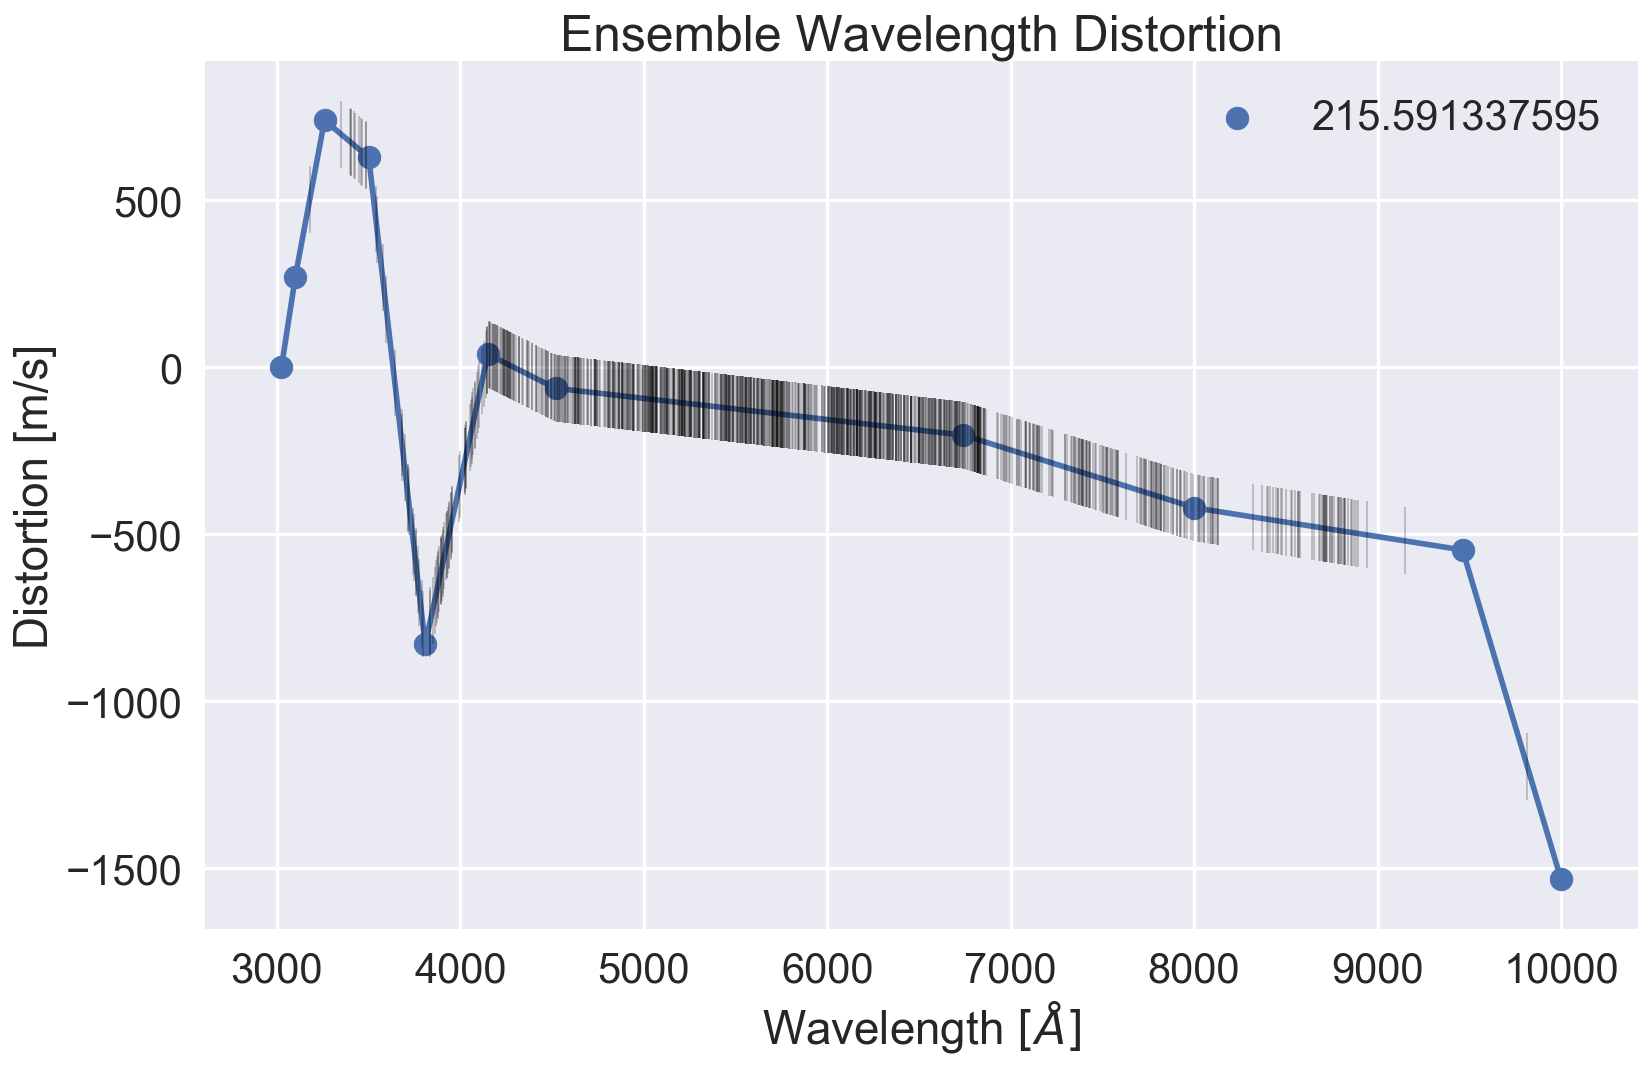

In [632]:

x = np.linspace(np.min(knot_positions2), np.max(knot_positions5), num=2000)
fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(x, fit_dict3[key3]['interpolate'](x))
# ax.scatter(knot_positions2, fit_dict3[key3]['interpolate'](knot_positions2), label=bestchi3)
# ax.plot(x, fit_dict4[key4]['interpolate'](x))
# ax.scatter(knot_positions4, fit_dict4[key4]['interpolate'](knot_positions4), label=bestchi4)
voffset = 100.0
ax.plot(x, fit_dict5[key5]['interpolate'](x))
ax.scatter(knot_positions5, fit_dict5[key5]['interpolate'](knot_positions5), label=bestchi5)
for line in blank_transitions.wavelength:
    ax.vlines(line,
              fit_dict5[key5]['interpolate'](line) - voffset,
              fit_dict5[key5]['interpolate'](line) + voffset,
              lw=1.0,
              alpha=0.2,
              zorder=5.0,
             )
ax.set_ylabel("Distortion [m/s]")
ax.set_xlabel(xlabel_wavelength)
ax.legend(loc='best')
ax.set_title("Ensemble Wavelength Distortion")
fig.tight_layout()

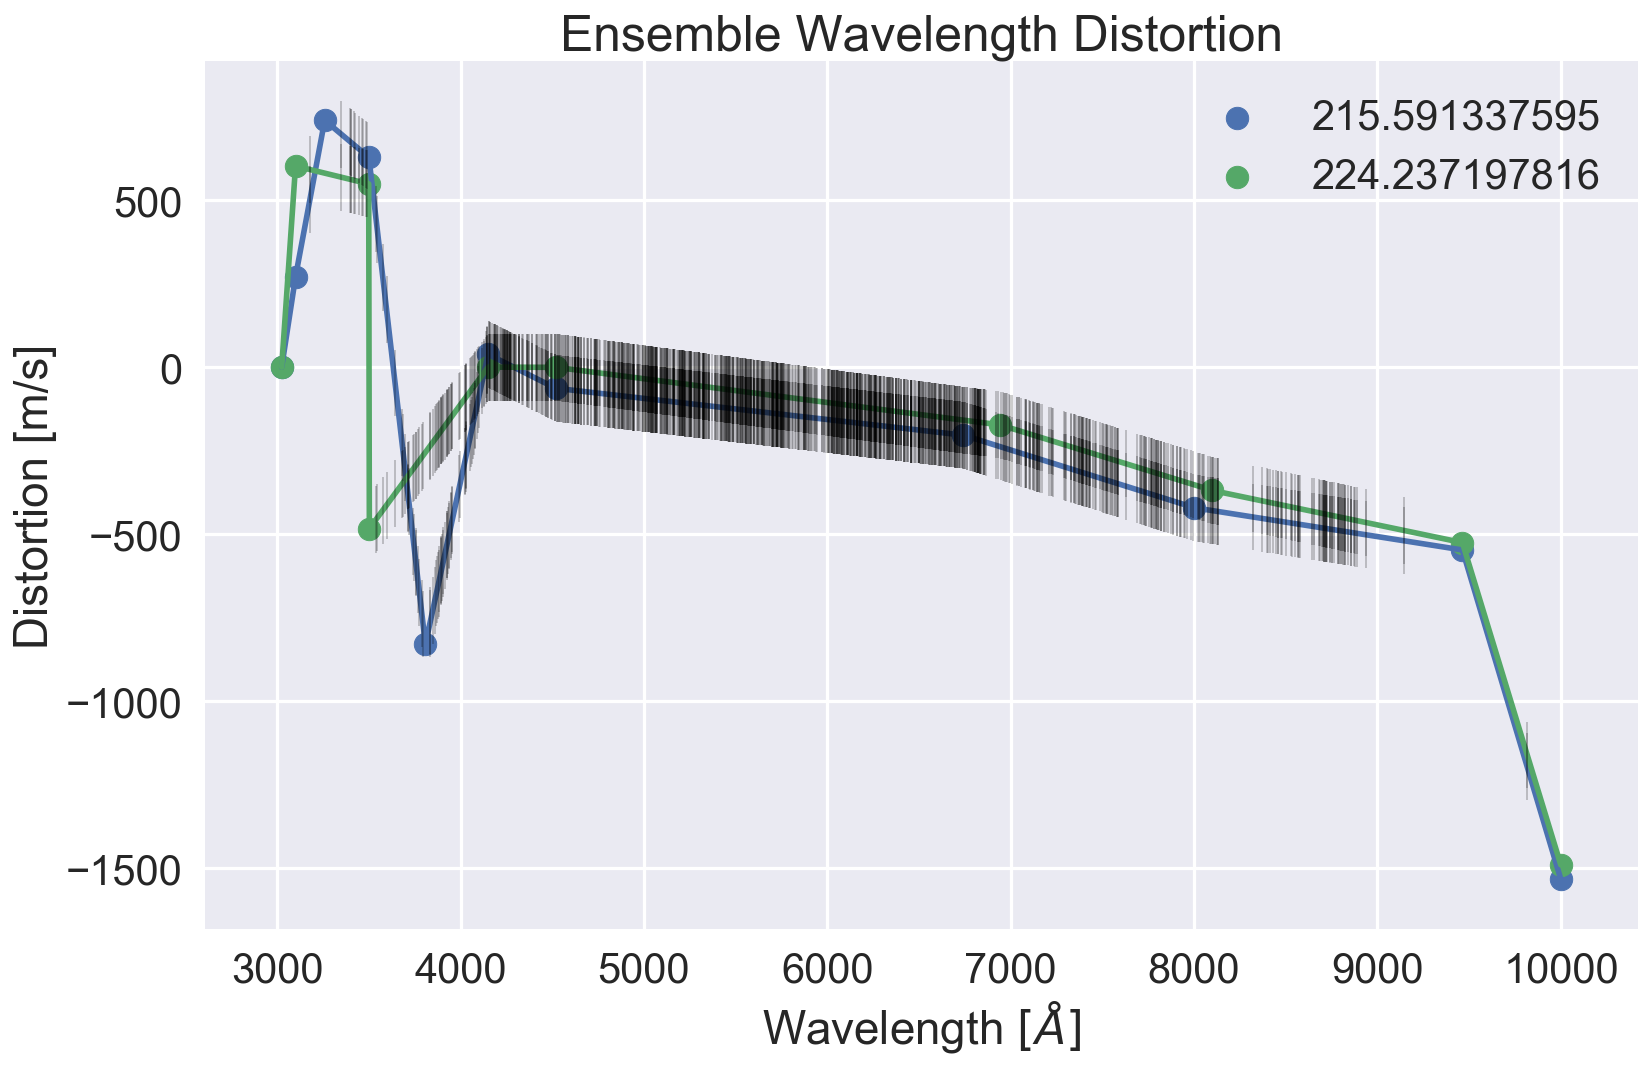

In [641]:

x = np.linspace(np.min(knot_positions2), np.max(knot_positions5), num=2000)
fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(x, fit_dict3[key3]['interpolate'](x))
# ax.scatter(knot_positions2, fit_dict3[key3]['interpolate'](knot_positions2), label=bestchi3)
# ax.plot(x, fit_dict4[key4]['interpolate'](x))
# ax.scatter(knot_positions4, fit_dict4[key4]['interpolate'](knot_positions4), label=bestchi4)
voffset = 100.0
ax.plot(x, fit_dict5[key5]['interpolate'](x))
ax.scatter(knot_positions5, fit_dict5[key5]['interpolate'](knot_positions5), label=bestchi5)
ax.plot(x, fit_dict6[key6]['interpolate'](x))
ax.scatter(knot_positions6, fit_dict6[key6]['interpolate'](knot_positions6), label=bestchi6)
for line in blank_transitions.wavelength:
    ax.vlines(line,
              fit_dict5[key5]['interpolate'](line) - voffset,
              fit_dict5[key5]['interpolate'](line) + voffset,
              lw=1.0,
              alpha=0.2,
              zorder=5.0,
             )
    ax.vlines(line,
              fit_dict6[key6]['interpolate'](line) - voffset,
              fit_dict6[key6]['interpolate'](line) + voffset,
              lw=1.0,
              alpha=0.2,
              zorder=5.0,
             )
ax.set_ylabel("Distortion [m/s]")
ax.set_xlabel(xlabel_wavelength)
ax.legend(loc='best')
ax.set_title("Ensemble Wavelength Distortion")
fig.tight_layout()

In [545]:
temp_vlt = blank_transitions.copy()
temp_vlt['vshift'] = fit_dict3[key3]['interpolate'](temp_vlt.wavelength)
temp_vlt_systems = fit_alpha(temp_vlt)

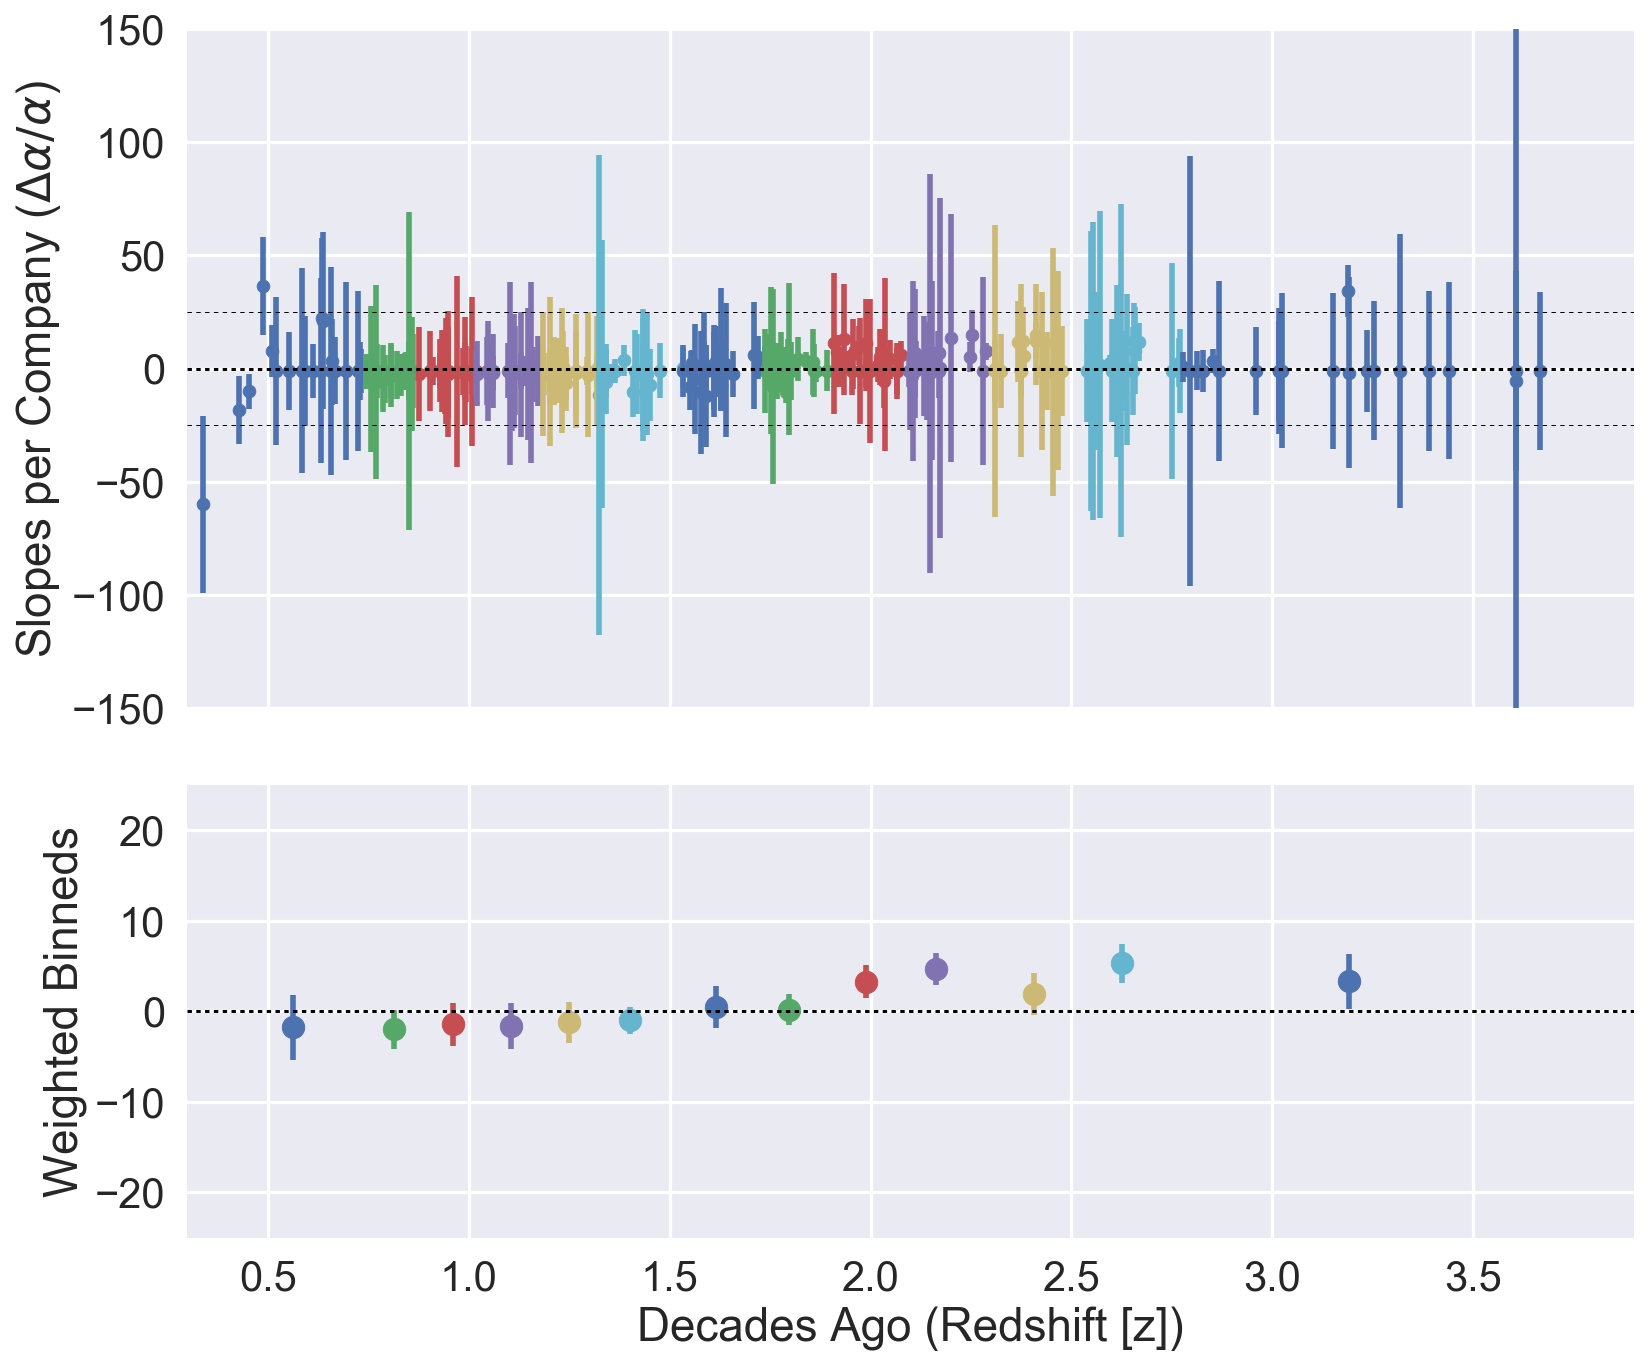

In [546]:
plot_example_telescope_bins(nbins=13, 
                            alphacol='sim_fit_alpha', 
                            dataframe=temp_vlt_systems)

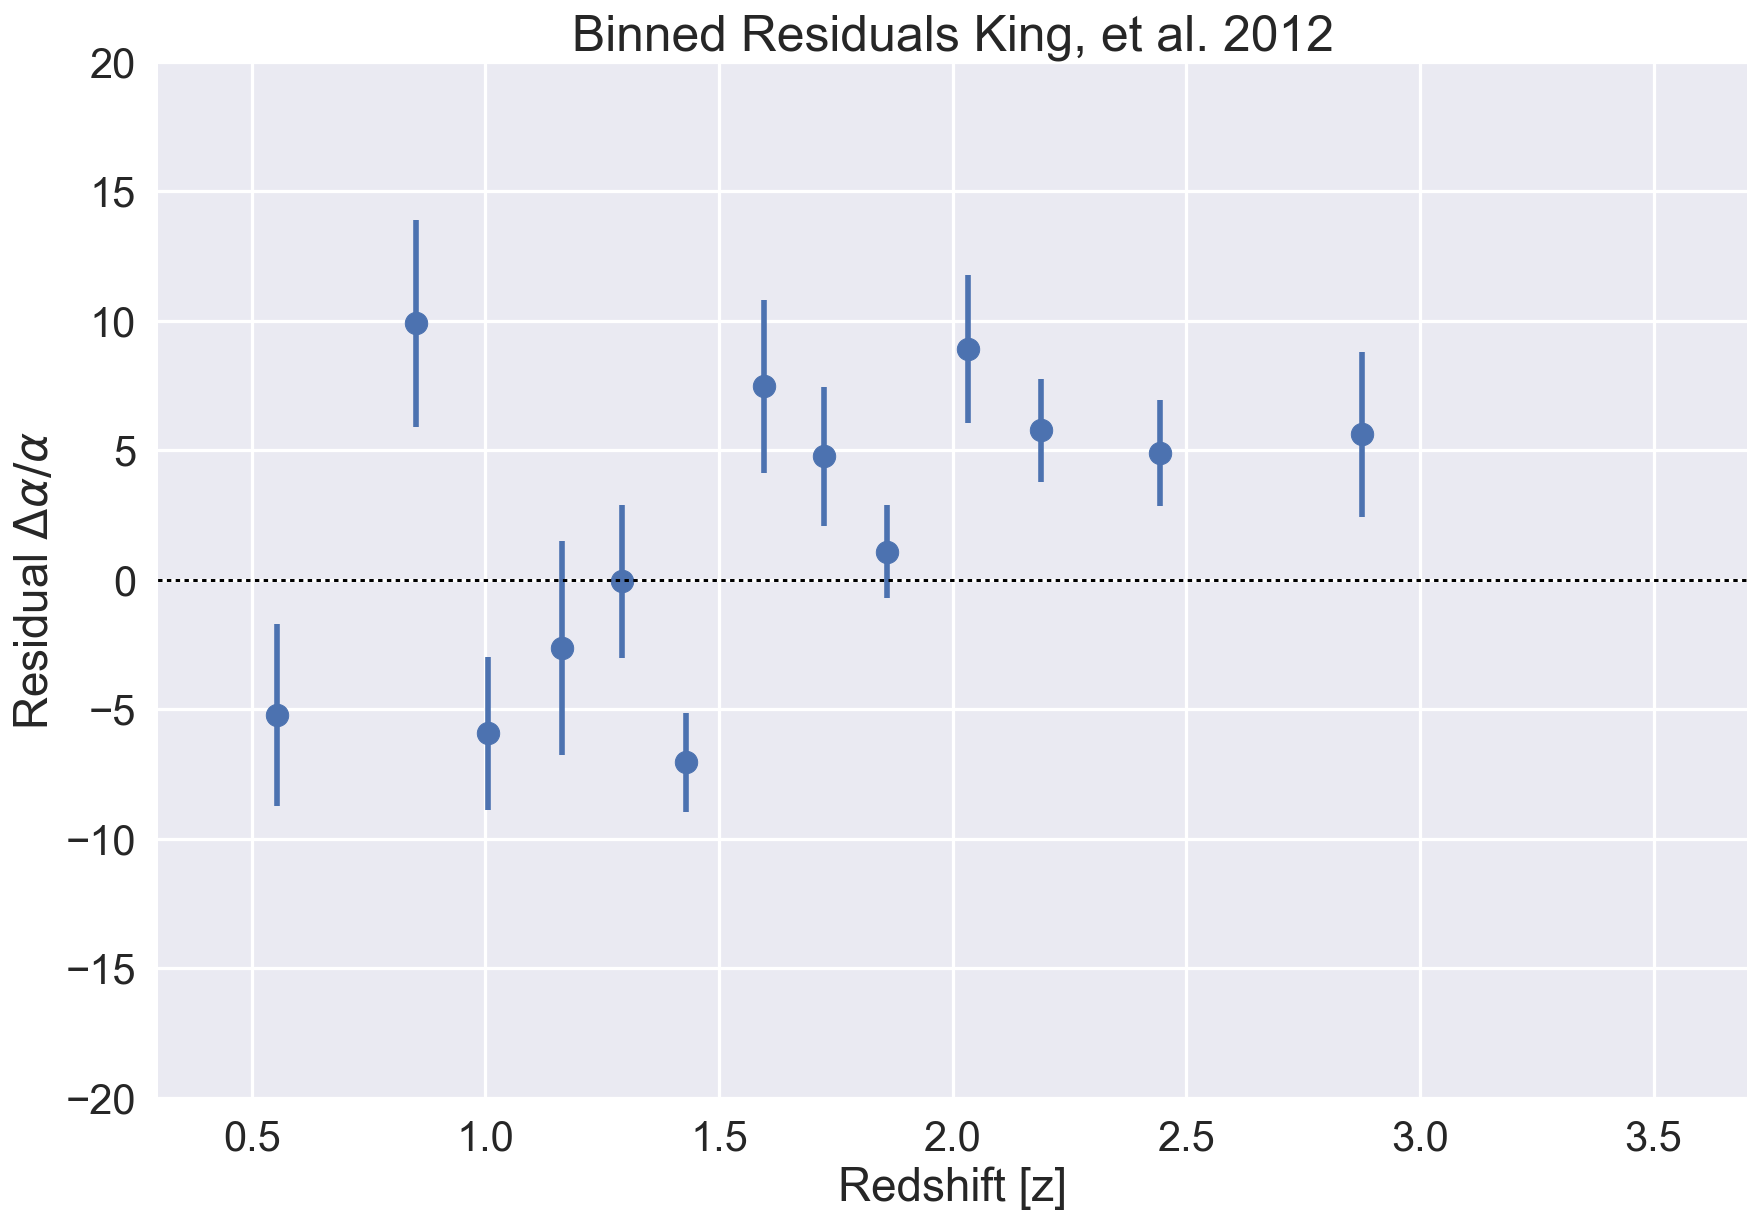

In [547]:
plot_a_v_zresid(vlt, vlt, errorcol='error_delta_alpha')
plt.title("Binned Residuals King, et al. 2012")

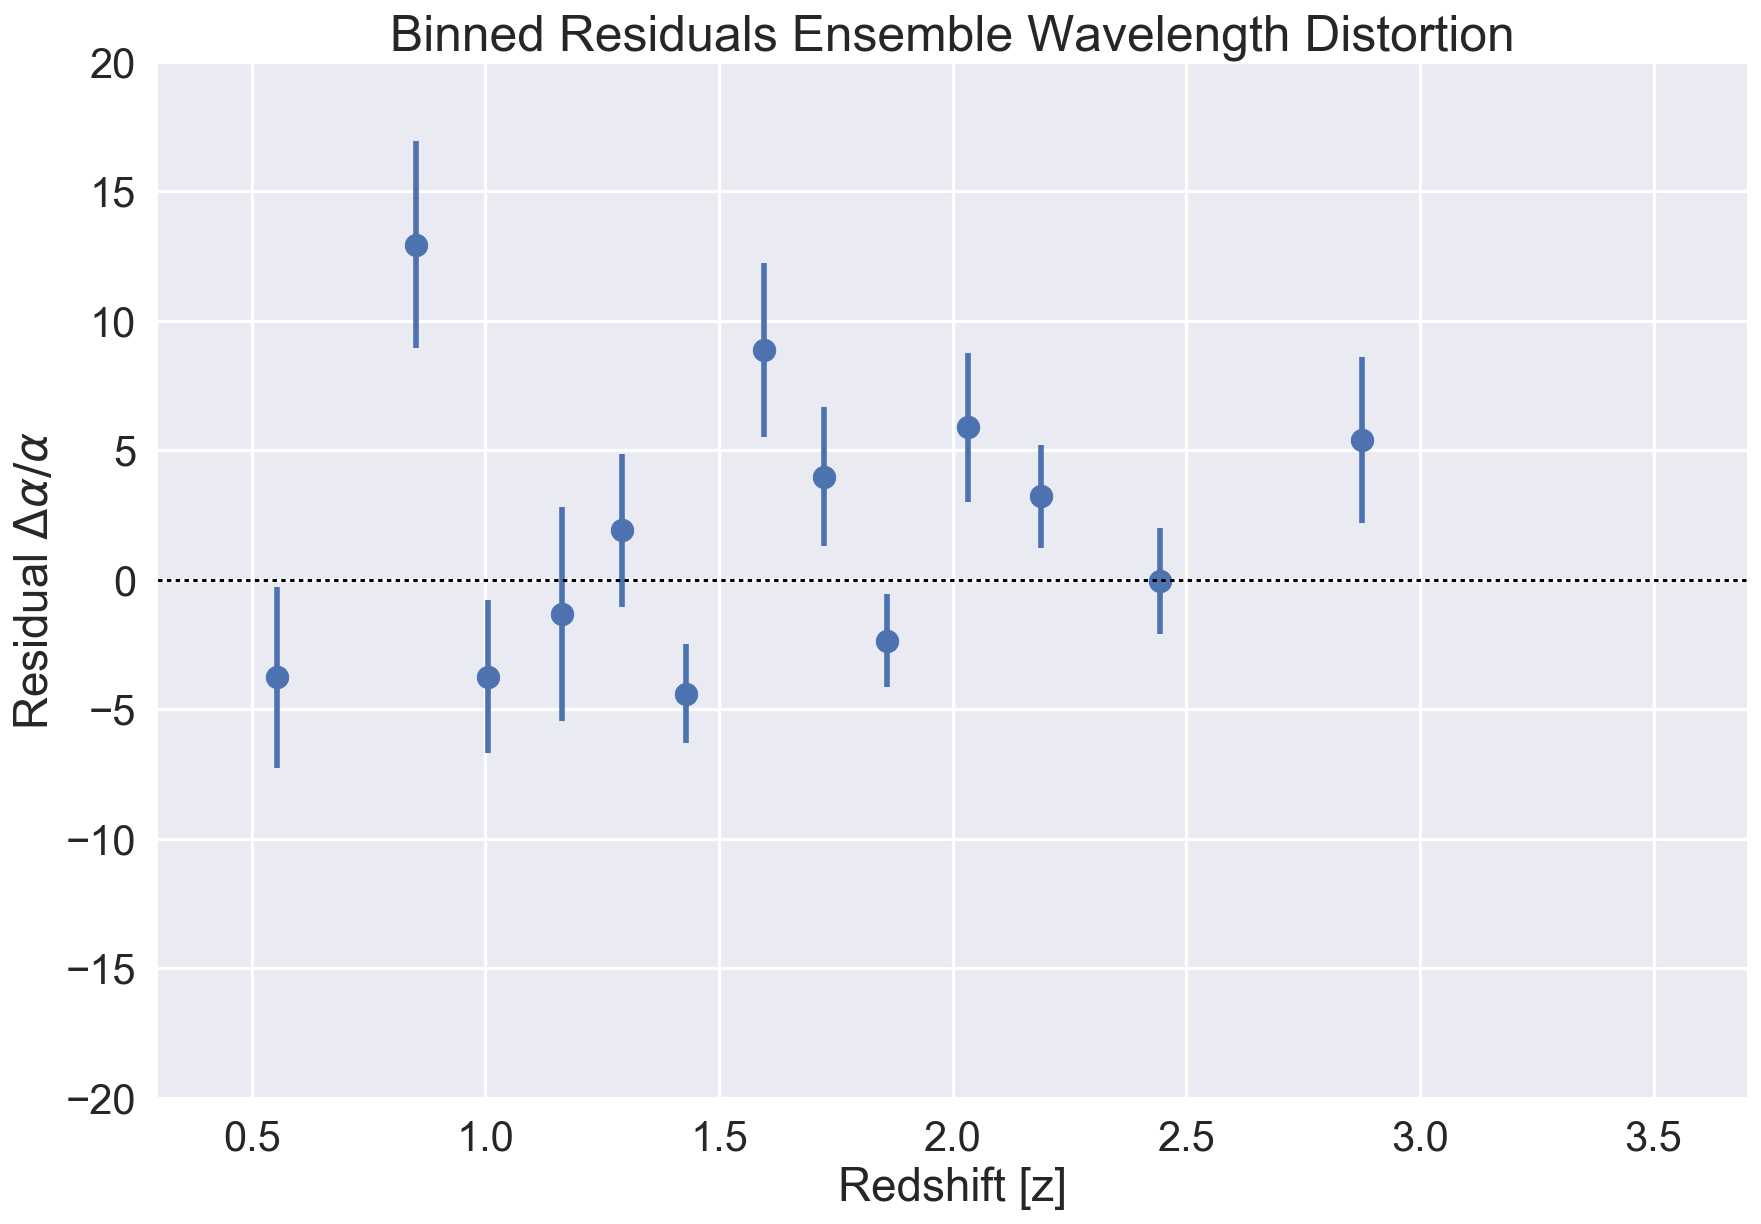

In [548]:
plot_a_v_zresid(vlt, temp_vlt_systems, alphacol2='sim_fit_alpha', errorcol='error_delta_alpha')
plt.title("Binned Residuals Ensemble Wavelength Distortion")

In [ ]:
# todo Create animated plots with vshifts (with alpha and/or distortions)

In [538]:
temp_transitions['vshift'] = temp_transitions.apply(lambda x:offset(x, temp4), axis=1)

In [539]:
temp_systems2 = fit_alpha(temp_transitions)

In [379]:
temp_systems = fit_alpha(temp_transitions)

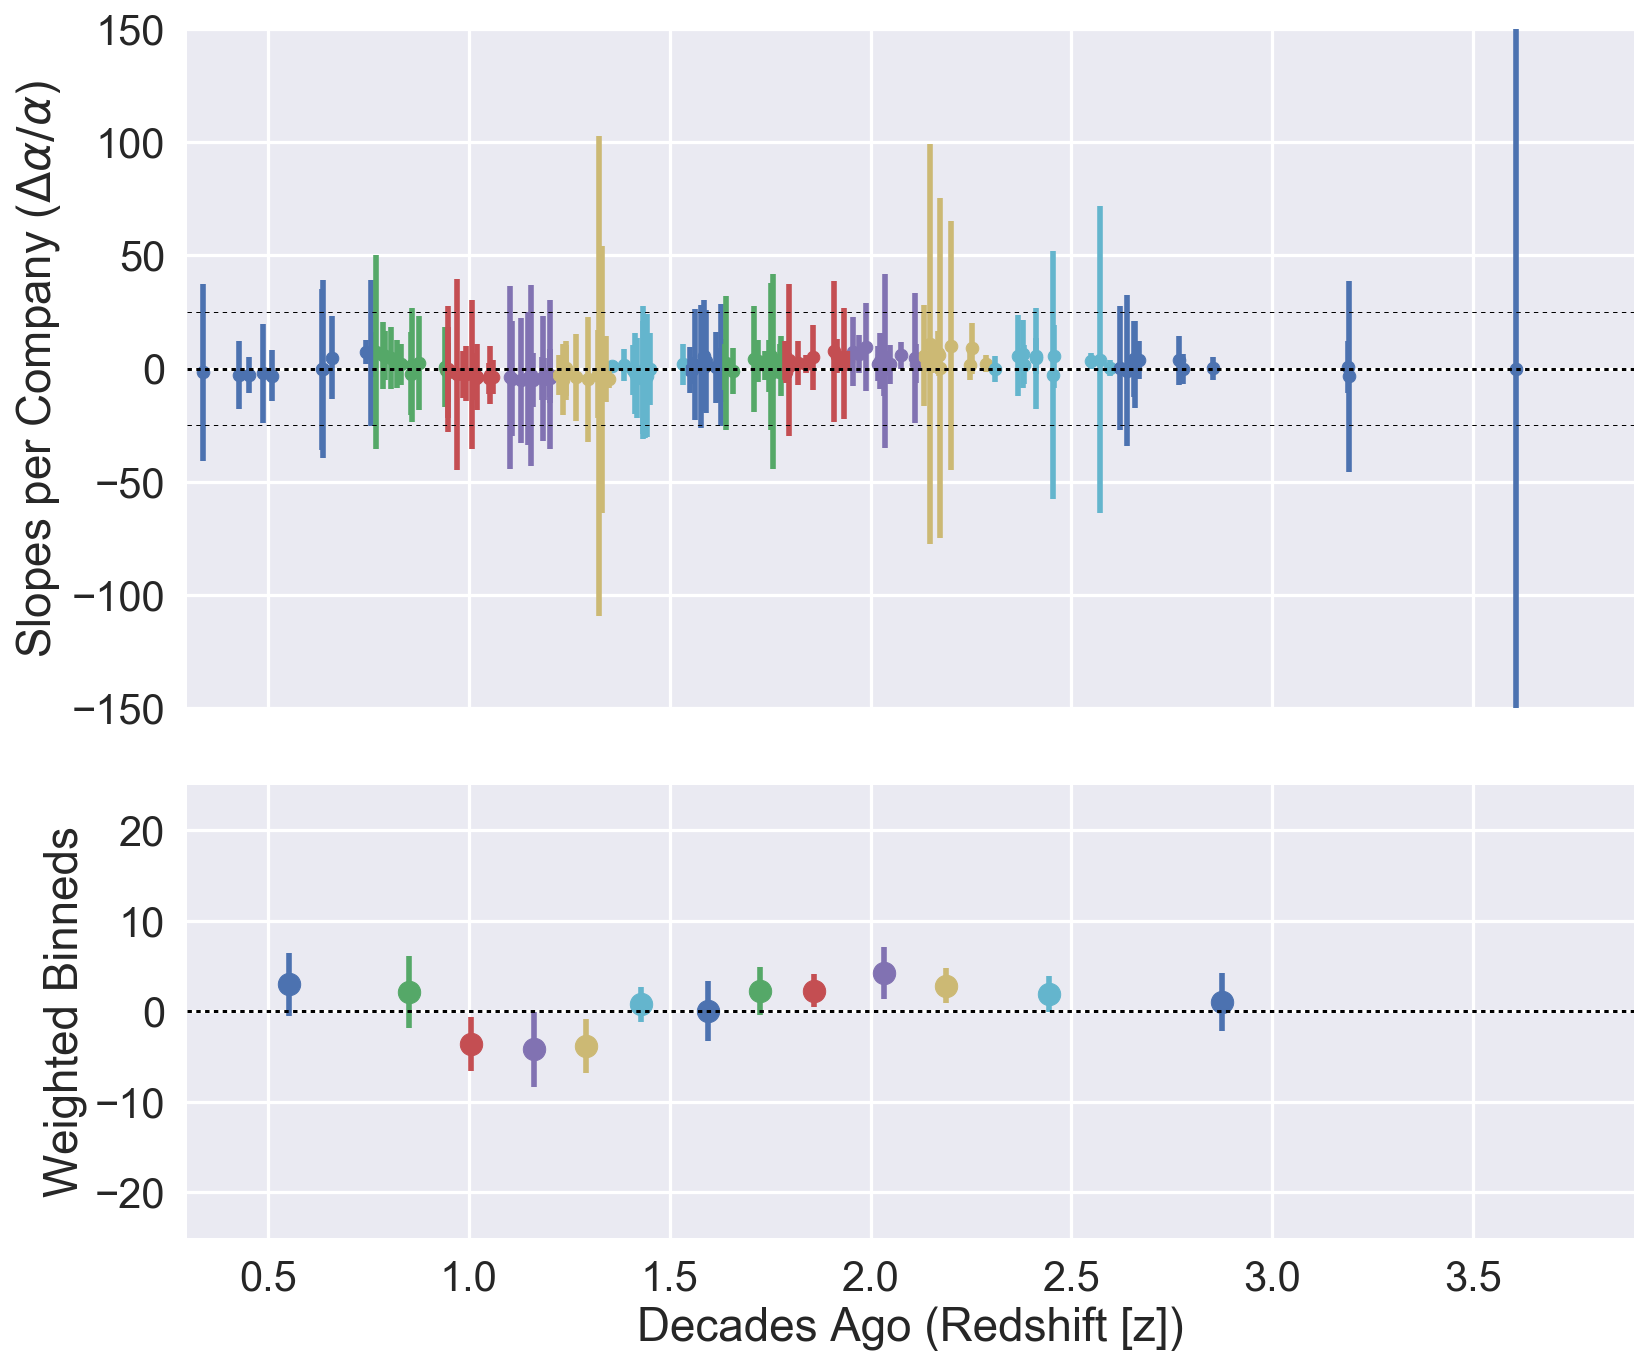

In [381]:
plot_example_telescope_bins(nbins=13, 
                            alphacol='sim_fit_alpha', 
                            dataframe=temp_systems[temp_systems.source == 'VLT'])

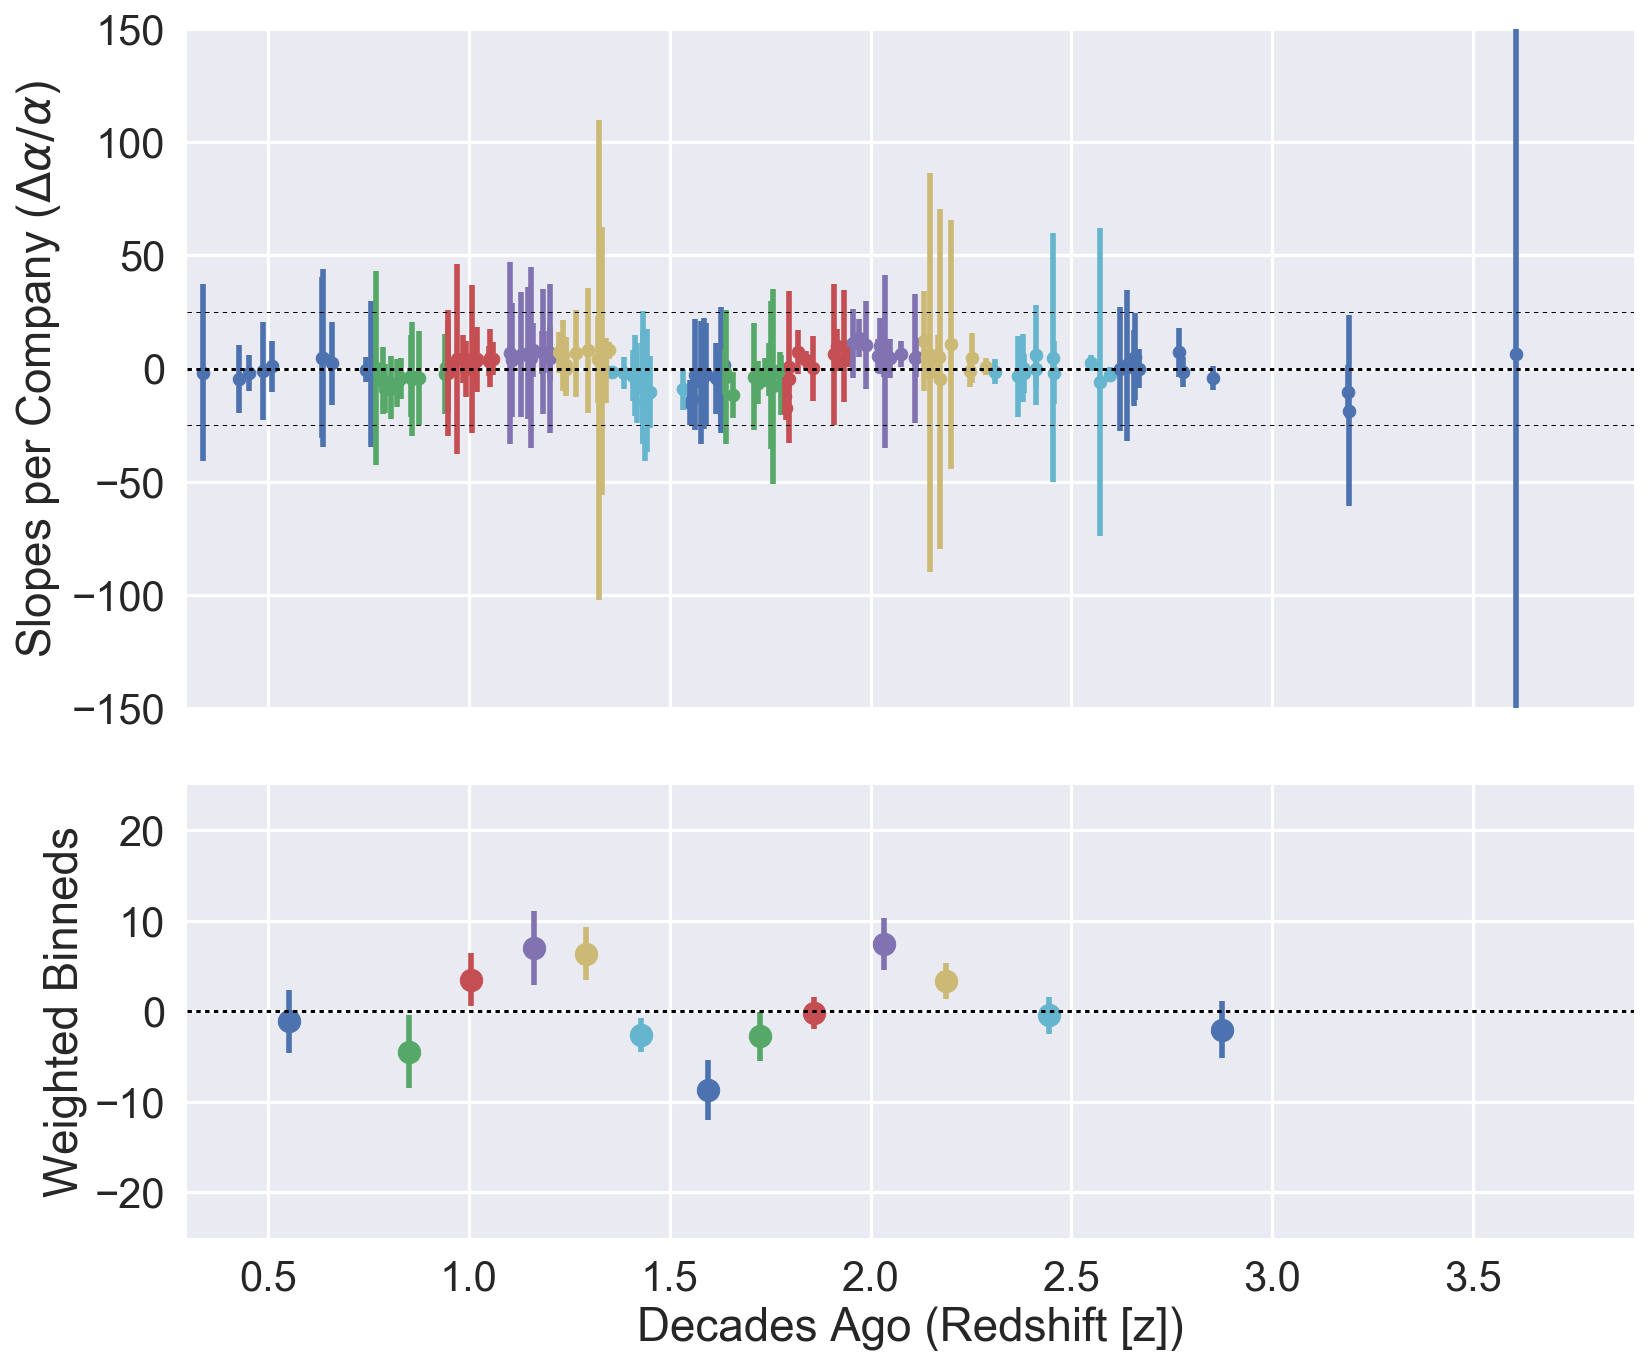

In [535]:
plot_example_telescope_bins(nbins=13, 
                            alphacol='sim_fit_alpha', 
                            dataframe=temp_systems2[temp_systems2.source == 'VLT'])

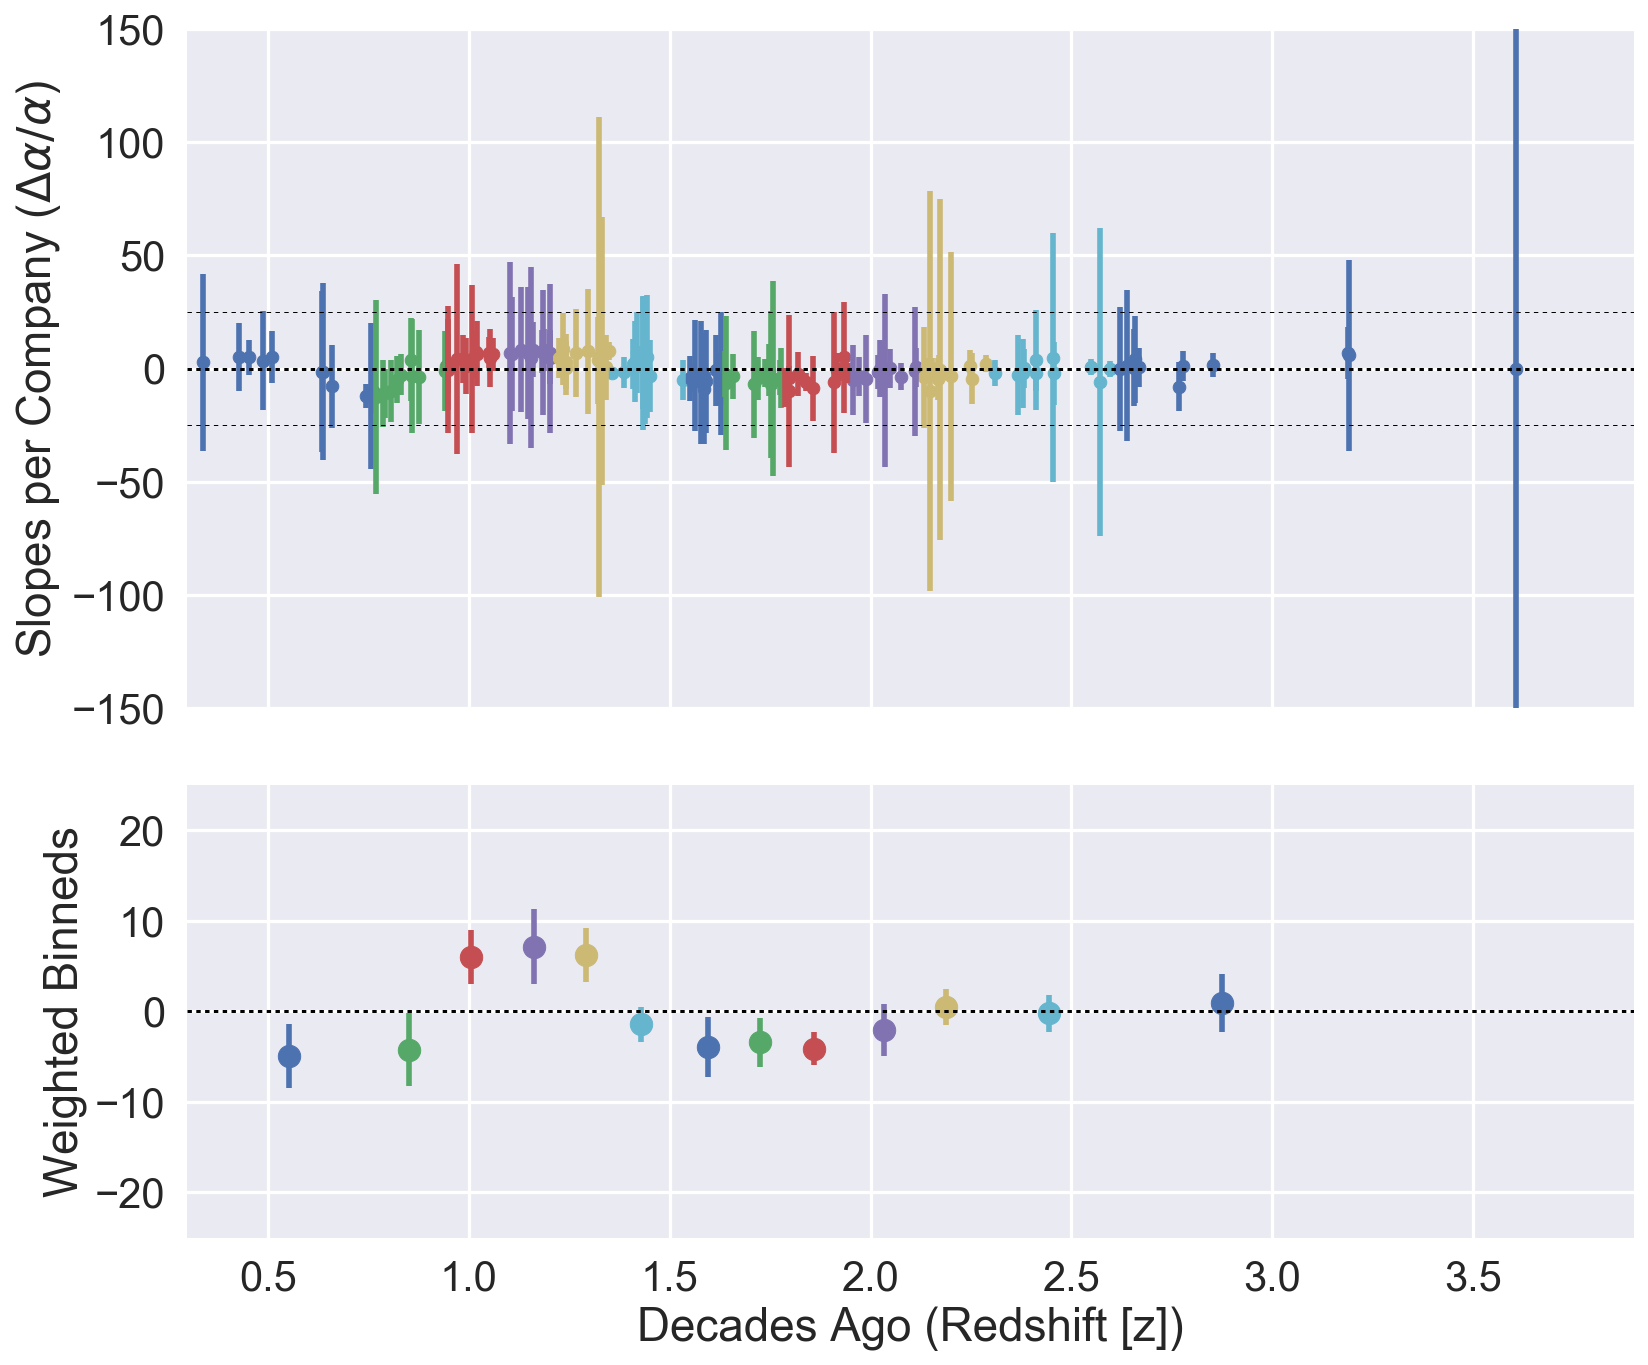

In [540]:
plot_example_telescope_bins(nbins=13, 
                            alphacol='sim_fit_alpha', 
                            dataframe=temp_systems2[temp_systems2.source == 'VLT'])

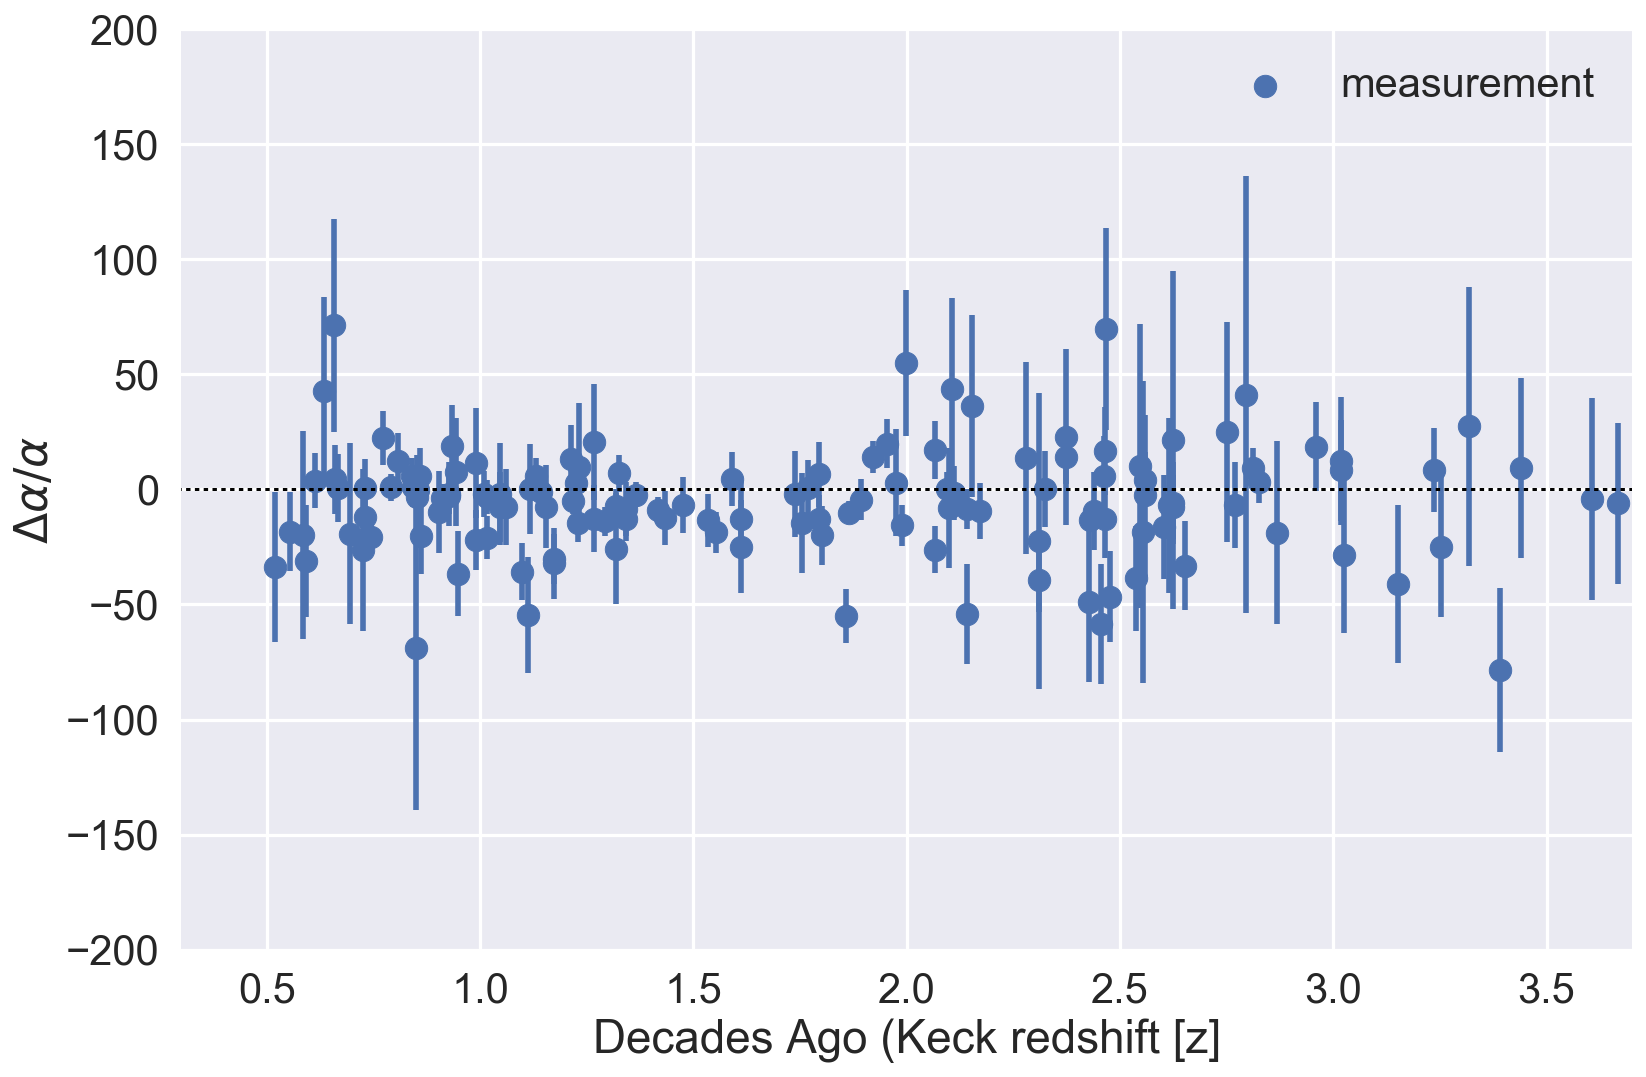

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))
x = keck.z_absorption
y = keck.delta_alpha
e = keck.error_delta_alpha
color=0
label='measurement'
ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
ax.set_ylabel(r"$\Delta \alpha/\alpha$")
ax.set_xlabel(r"Decades Ago (Keck redshift [z]")
ax.legend(loc='best')
ax.set_xlim(0.3, 3.7)
ax.set_ylim(-200, 200)
fig.tight_layout()

In [70]:
fig, (ax, ax2) = plt.subplots(nrows=2)
x = keck.z_absorption
y = keck.delta_alpha
e = keck.error_delta_alpha
color=0
label='measurement'
ax.scatter(x, (y), c=sns.color_palette()[color], label='', s=40)
ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
ax.set_ylabel(r"$\Delta \alpha/\alpha$")
ax.set_xlabel(r"Decades Ago (Keck redshift [z])")
ax.legend(loc='best')
ax.set_xlim(0.3, 3.7)
ax.set_ylim(-200, 200)
plot_a_v_z(keck, nbins=13, ylims=200, ax=ax2)
ax2.set_ylim(-20, 20)
fig.tight_layout()


In [ ]:
plot_a_v_z(keck)

It's important to note that none of the measurements by themselves is enough to establish a measurement at a 5-$\sigma$ level, but taken as an ensemble, it approaches ~4.7$\sigma$.

## Simulated data

I'm going to give you a set of data. This set of data, the y-values will be generated in one of two ways (or a combination).

 - An $\alpha$ process ($\alpha$ process)
 - A wavelength process (w process)

Here is a single system, plotted as though it was generated in either $\alpha$ or w processes (and transitions smoothly between them to highlight the fact that that y-values are the same. It is merely the x-axis that gets changed:

![alt text](../img/02-animation.gif "Switch")

**Given a dataset, can you devise a test that quantifies the relative likelihood of either process $\alpha$ or w generating it?**

One extra piece of information that is important: if $\alpha$ is generating a signal, it must be a straight line in the $\alpha$ plot. If it is a w-process, it can be more flexible. 

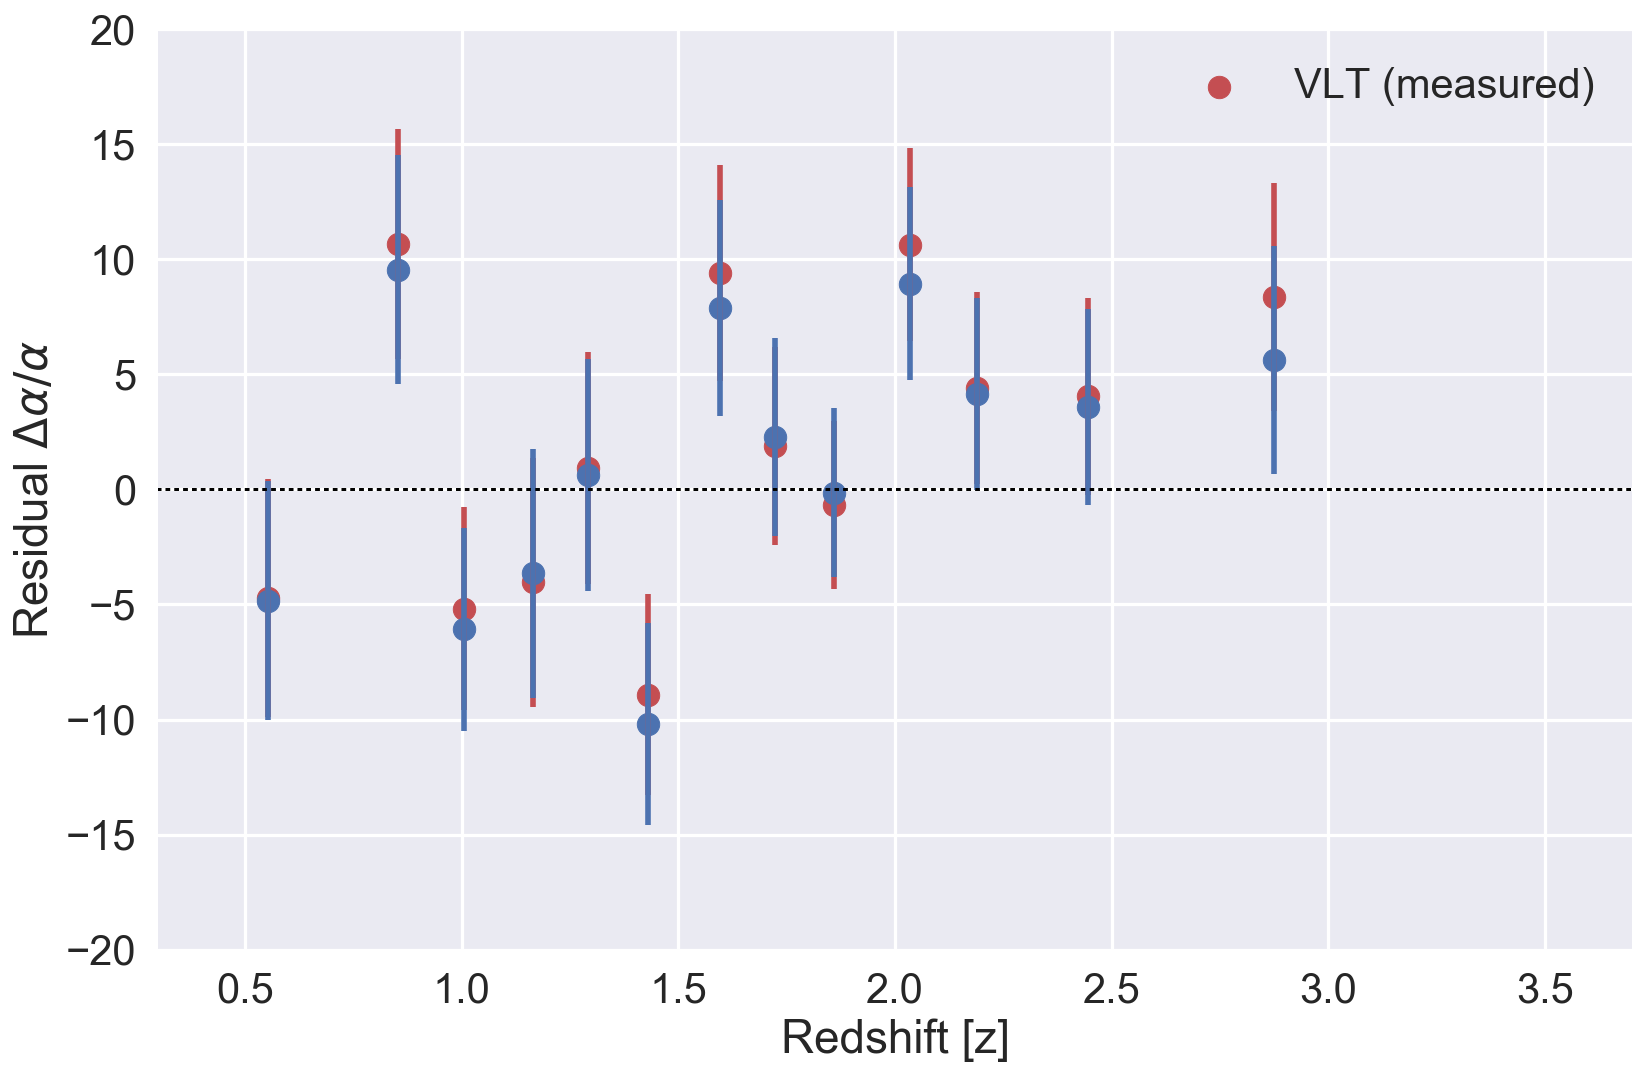

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, color=2, label='VLT (measured)')
plot_a_v_zresid(vlt, vlt)

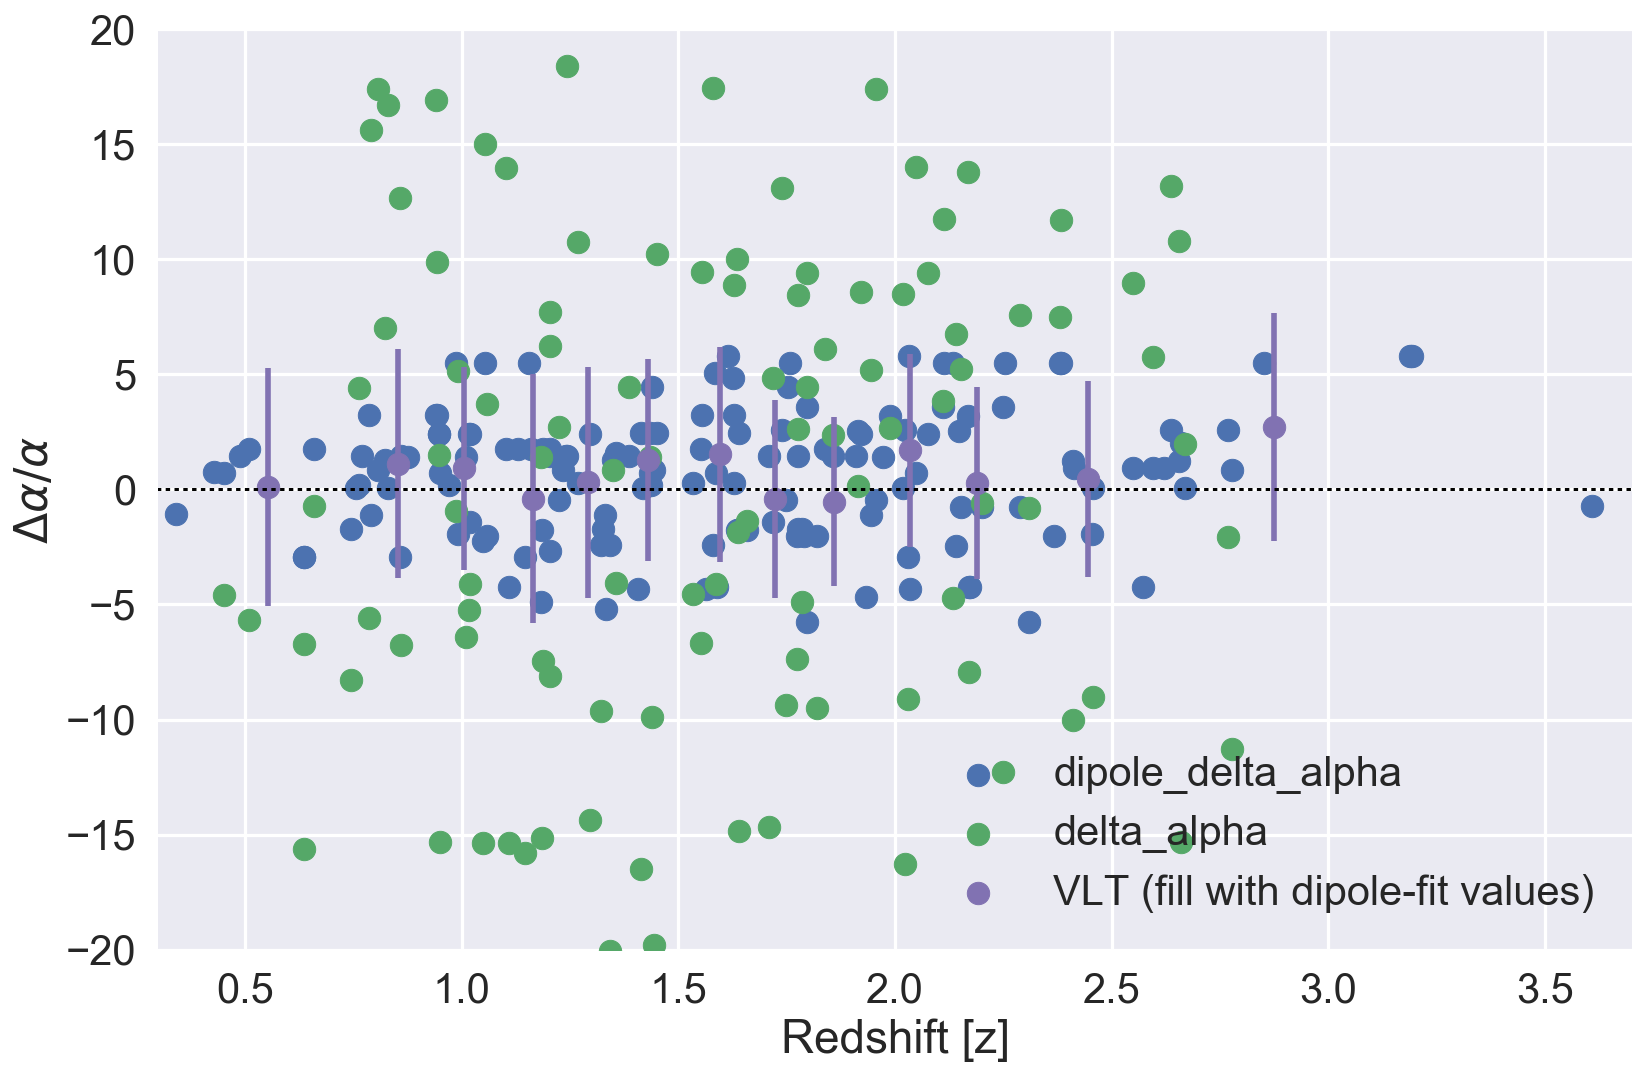

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(vlt.z_absorption, vlt.dipole_delta_alpha)
ax.scatter(vlt.z_absorption, vlt.delta_alpha)
plot_a_v_z(vlt, alphacol='dipole_delta_alpha', color=3, label='VLT (fill with dipole-fit values)')

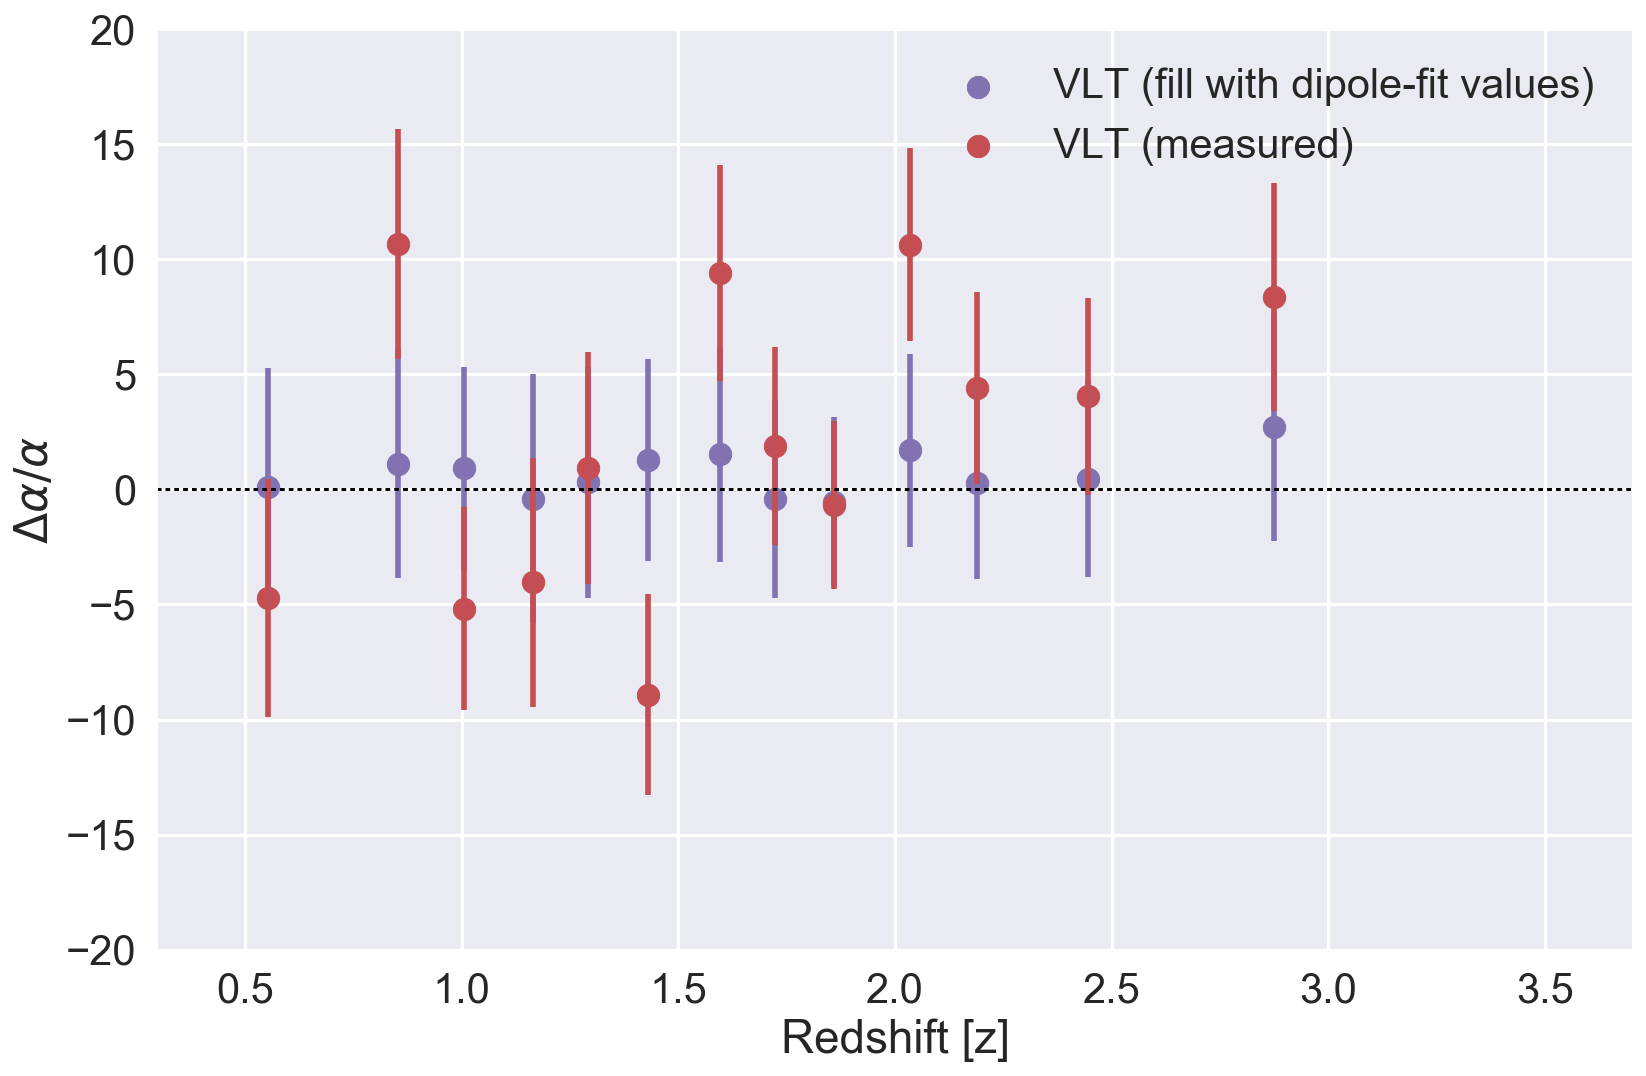

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, alphacol='dipole_delta_alpha', color=3, label='VLT (fill with dipole-fit values)')
plot_a_v_z(vlt, color=2, label='VLT (measured)')

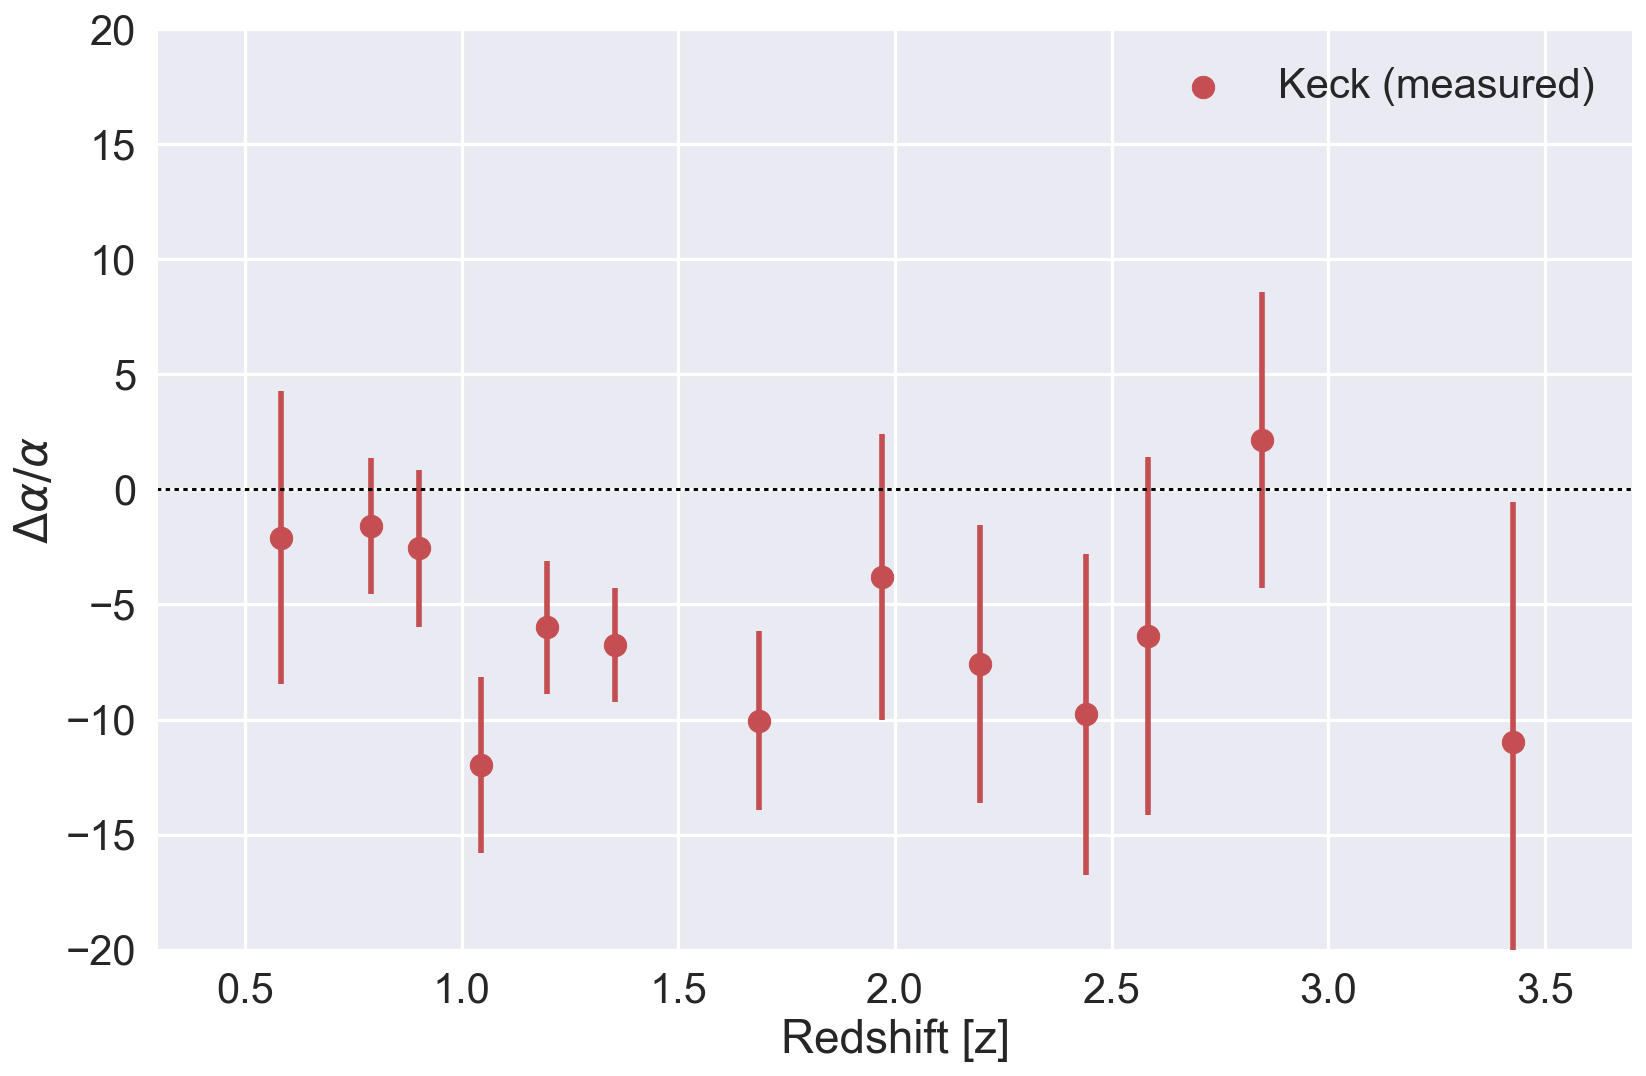

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, alphacol='dipole_delta_alpha', color=3, label='Keck (fill with dipole-fit values)')

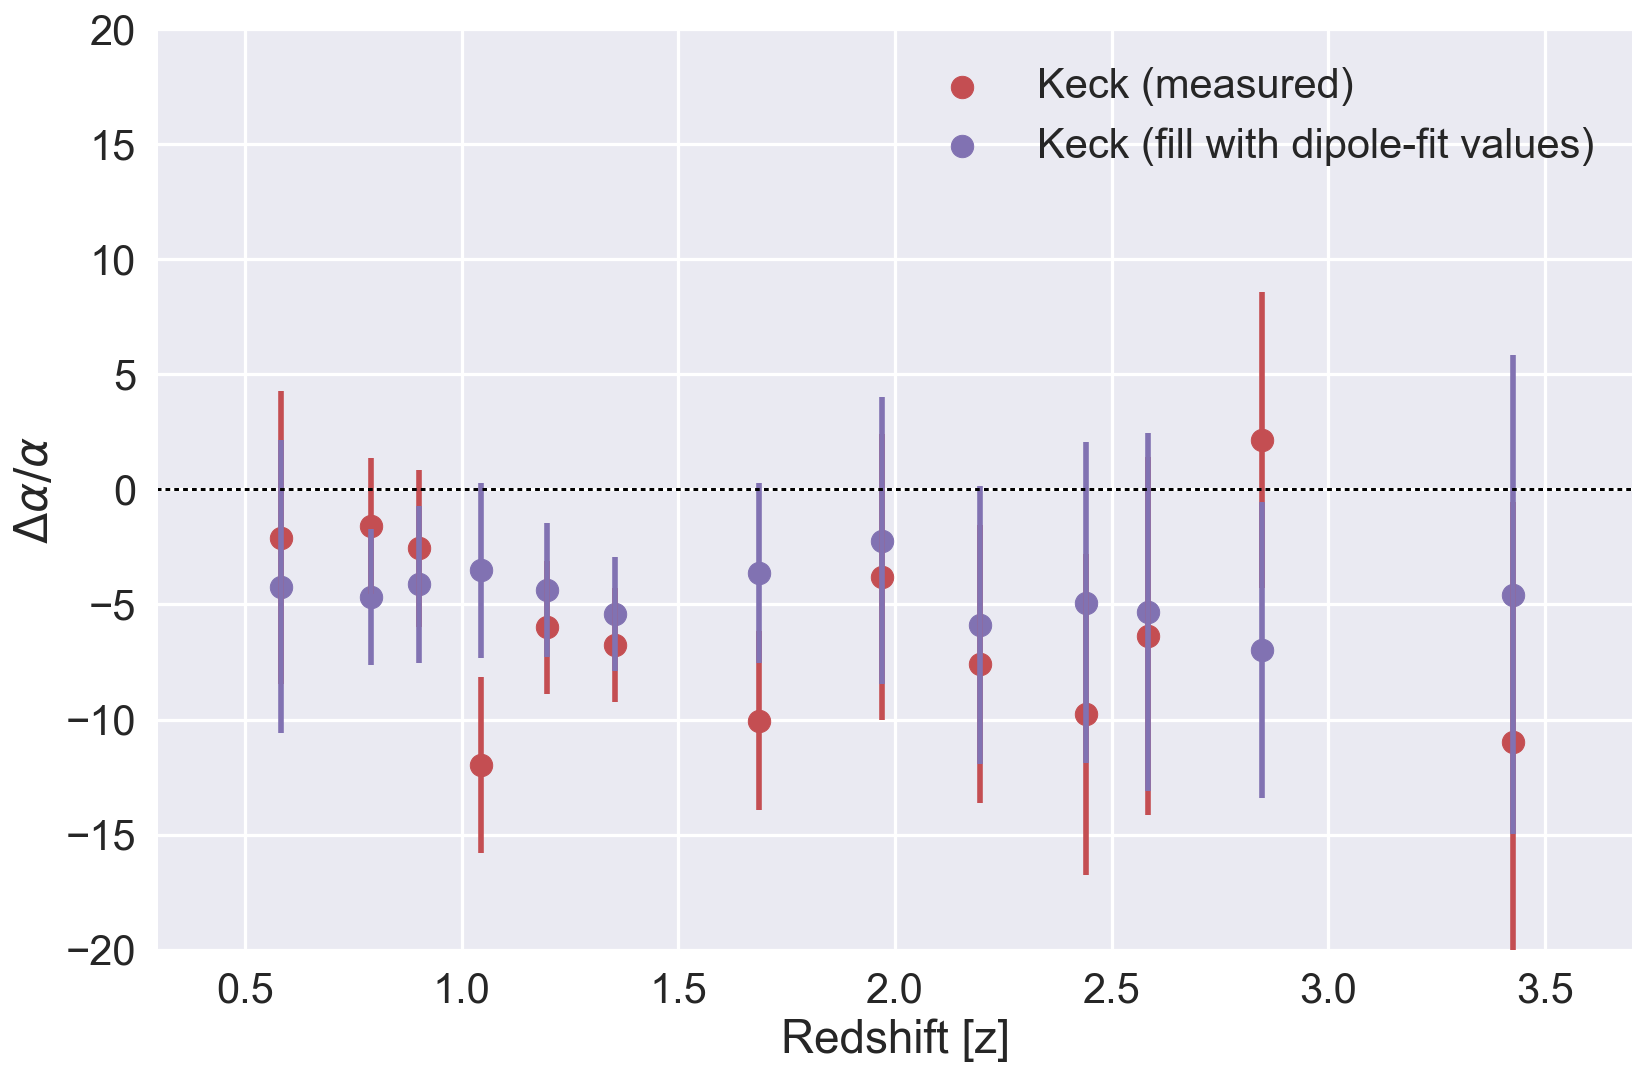

In [190]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')
plot_a_v_z(keck, alphacol='dipole_delta_alpha', color=3, label='Keck (fill with dipole-fit values)')

# To Do:

 - animation of transitioning between x and w on the x-axis
 - interactive plot that fits a spline with offsets
 - Binned model from paper with dipole result

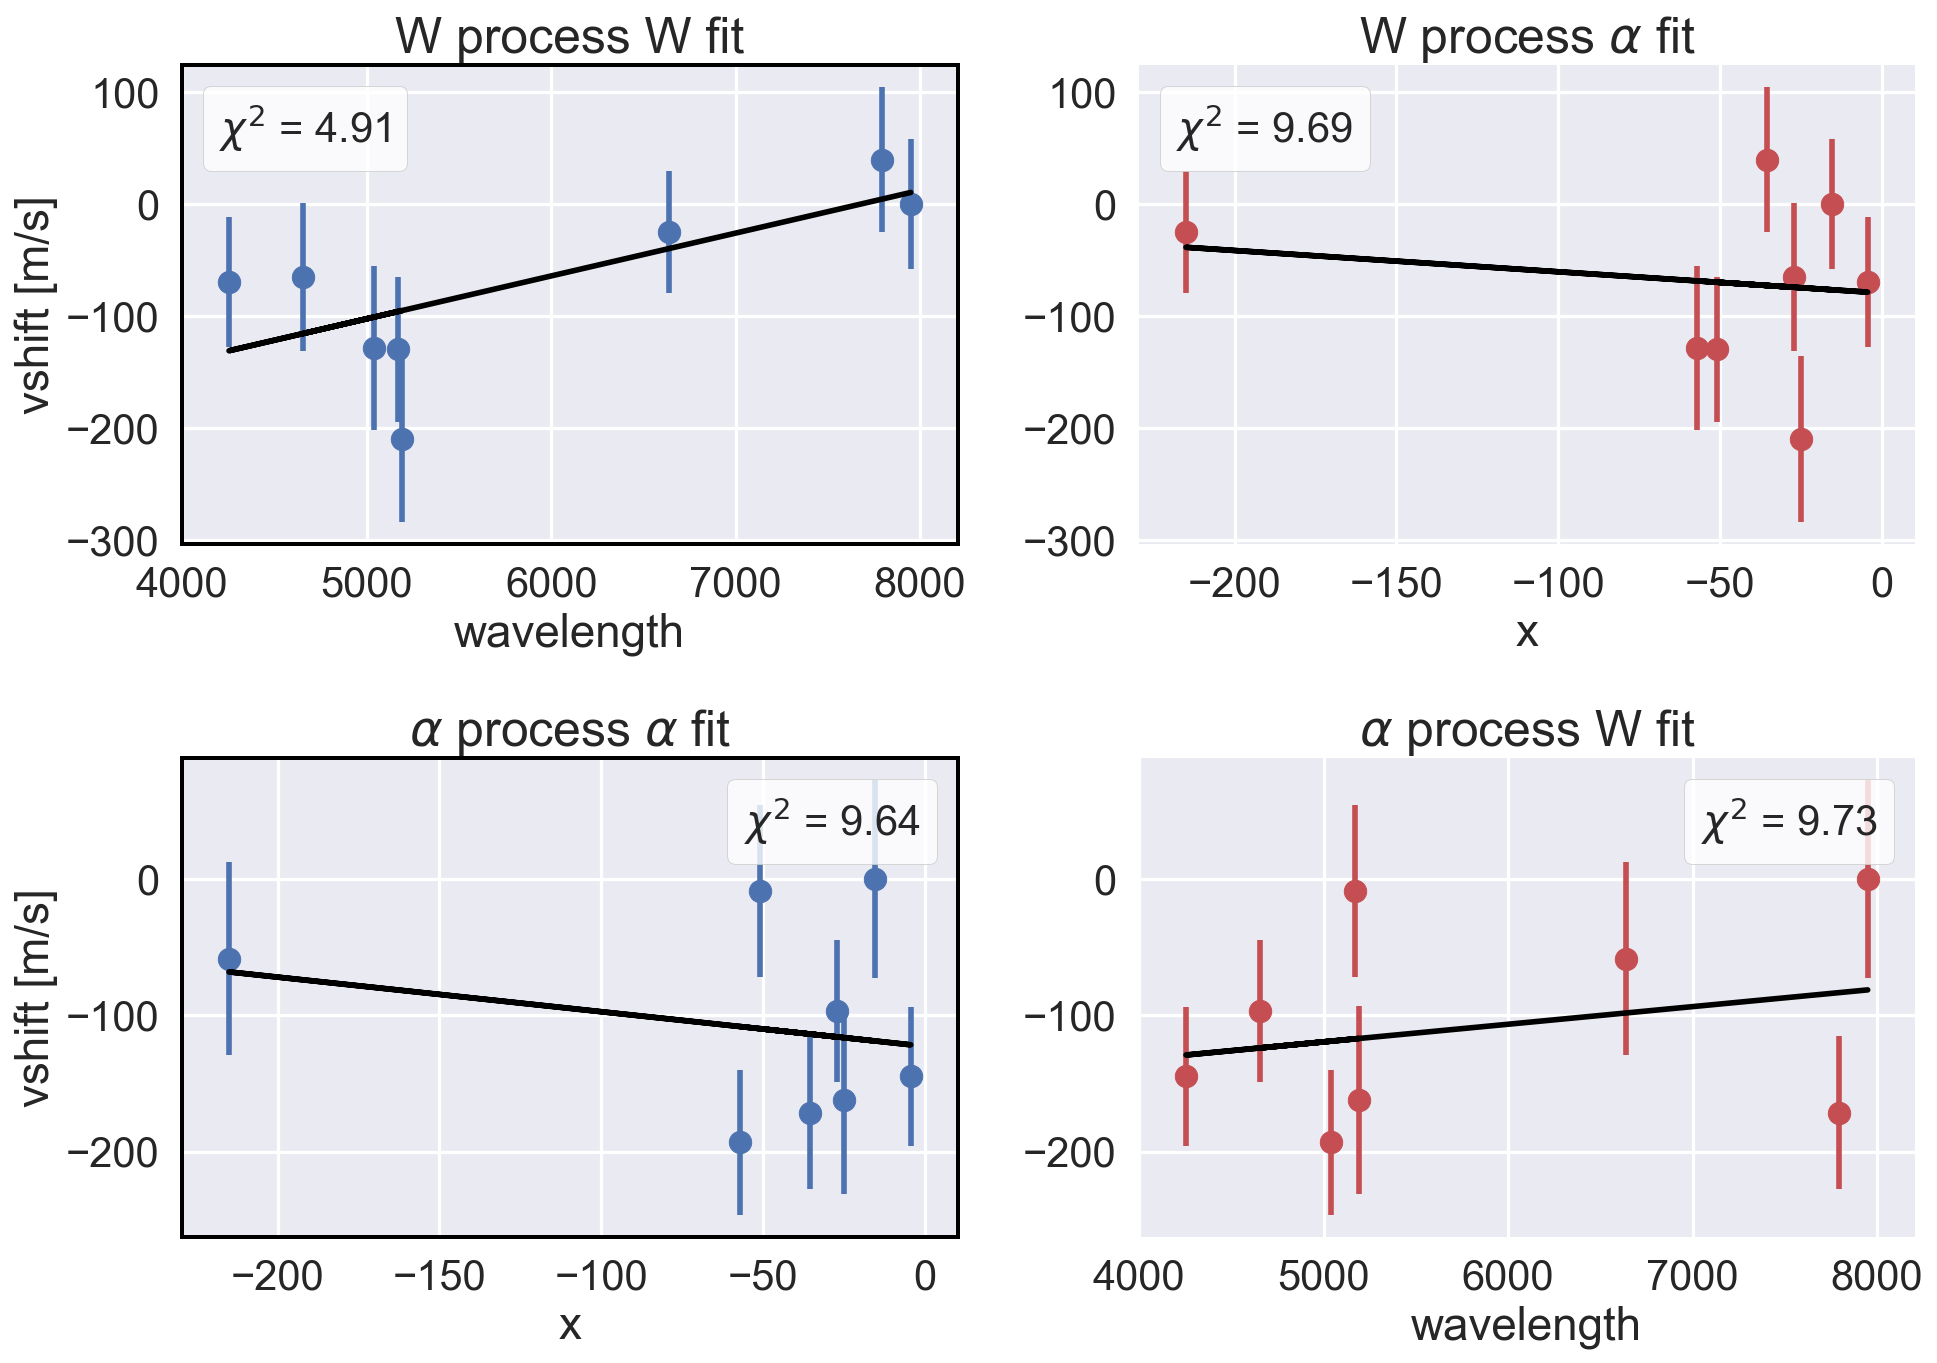

In [15]:
plot_hypotheses(231, df_a, df_w)

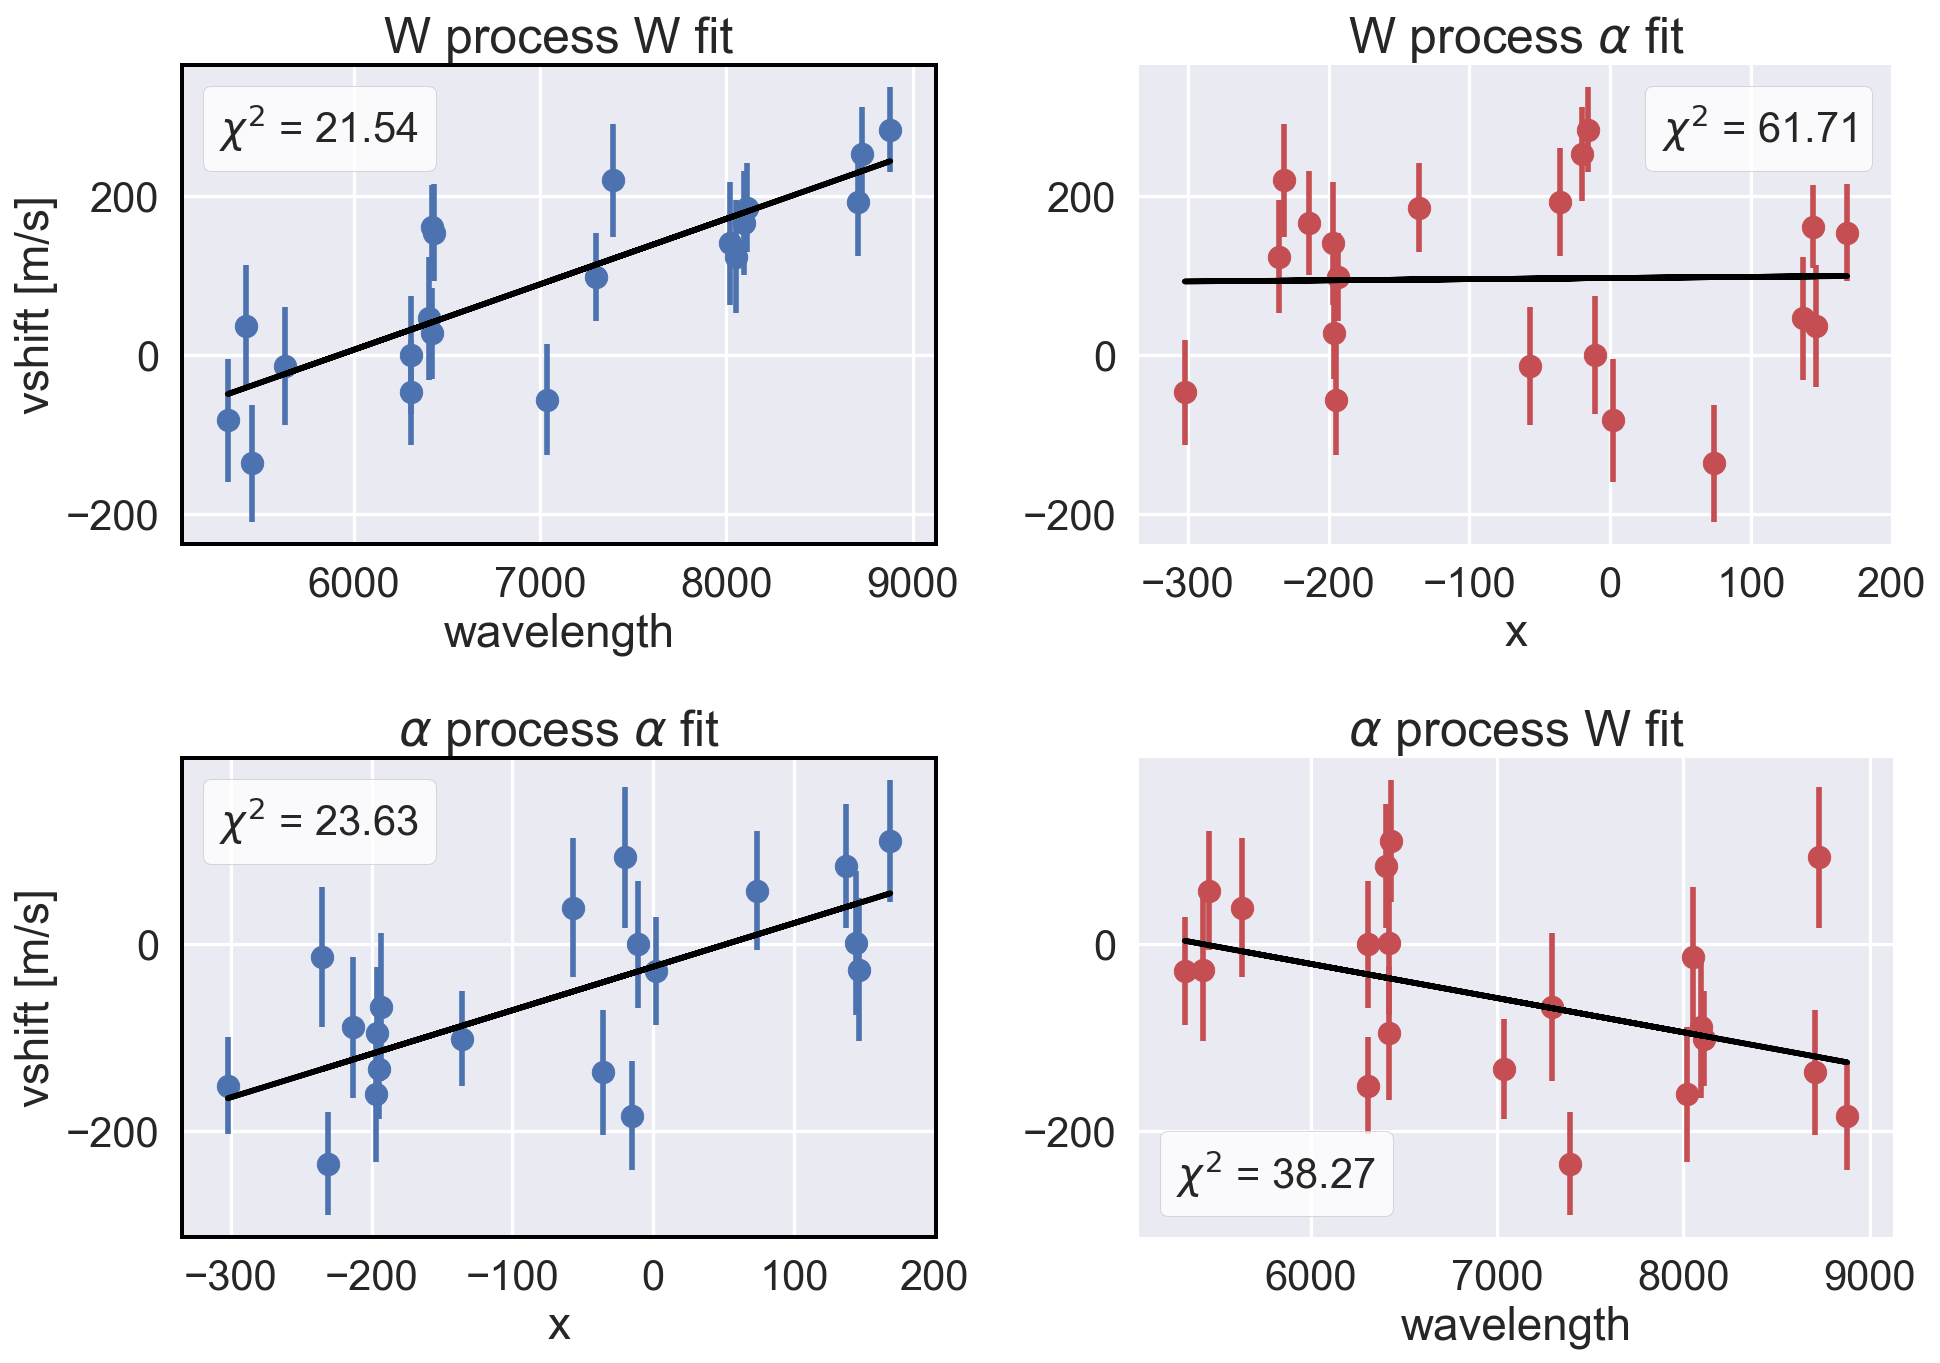

In [70]:
plot_hypotheses(264, df_a, df_w)

In [17]:
df_a[df_a.system==264][['wavelength', 'x', 'vshift', 'sigma']]

wavelength           x      vshift      sigma
1755  6307.606019  -10.570881    0.000000  67.976694
1756  8880.132002  -15.395341 -183.532169  58.355253
1757  8703.930794  -35.545013 -137.297620  66.331114
1758  8726.270535  -20.339554   92.848987  75.616709
1759  7036.901052 -194.518419 -133.810894  53.660659
1760  7296.596596 -193.263758  -67.622065  79.228620
1761  7390.744395 -231.349696 -234.822291  54.856296
1762  8051.204649 -234.963760  -13.484665  74.865876
1763  8093.295722 -213.586285  -88.895179  75.334126
1764  5627.621790  -57.021421   39.181348  74.643997
1765  6400.314994  136.852178   83.482650  66.500987
1766  6418.916085  144.421525    1.191747  77.352706
1767  6431.141238  168.482323  110.252705  65.407266
1768  6306.554306 -302.252500 -151.424592  51.622702
1769  6420.236917 -196.023305  -95.371981  71.310984
1770  5321.313473    2.050106  -28.727743  57.401675
1771  5420.757525  146.189238  -27.174443  76.853809
1772  5453.012154   73.529547   57.321850  63.162448
1773  8020.831197 -197.150297 -160.717142  71.998956
1774  8112.791439 -135.805536 -101.281514  50.916272

In [230]:
chisqs = {# data_hypo
            'x_x':[],
            'x_w':[],
            'w_x':[],
            'w_w':[]}

data = {'x':df_a, 'w':df_w}
for system in sorted(df_w.system.unique()):
    for df in ['x', 'w']:
        for hypo in ['x', 'w']:
            chisq, results = fit_hypothesis(system=system, dataframe1=data[df], hypothesis=hypo)
            chisqs['_'.join([df, hypo])].append(chisq)
for item in chisqs:
    chisqs[item] = np.array(chisqs[item])

In [245]:
np.sum(chisqs['w_x']/chisqs['w_w'] < 1.0) / len(chisqs['w_x'])

0.058020477815699661

In [253]:
np.sum(chisqs['x_x']/chisqs['x_w'] < 1.0) / len(chisqs['w_x'])

0.90443686006825941

In [247]:
all_systems.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [251]:
angles = []
dipole_alphas = []
measured_alphas = []

for index, row in all_systems.iterrows():
    name = row['J2000']
    angles.append(j2000_to_theta(name))
    dipole_alphas.append(dipole_alpha(name))
    measured_alphas.append(row.delta_alpha)

In [264]:
plt.scatter(angles, dipole_alphas)
plt.scatter(angles, measured_alphas, alpha=0.5)

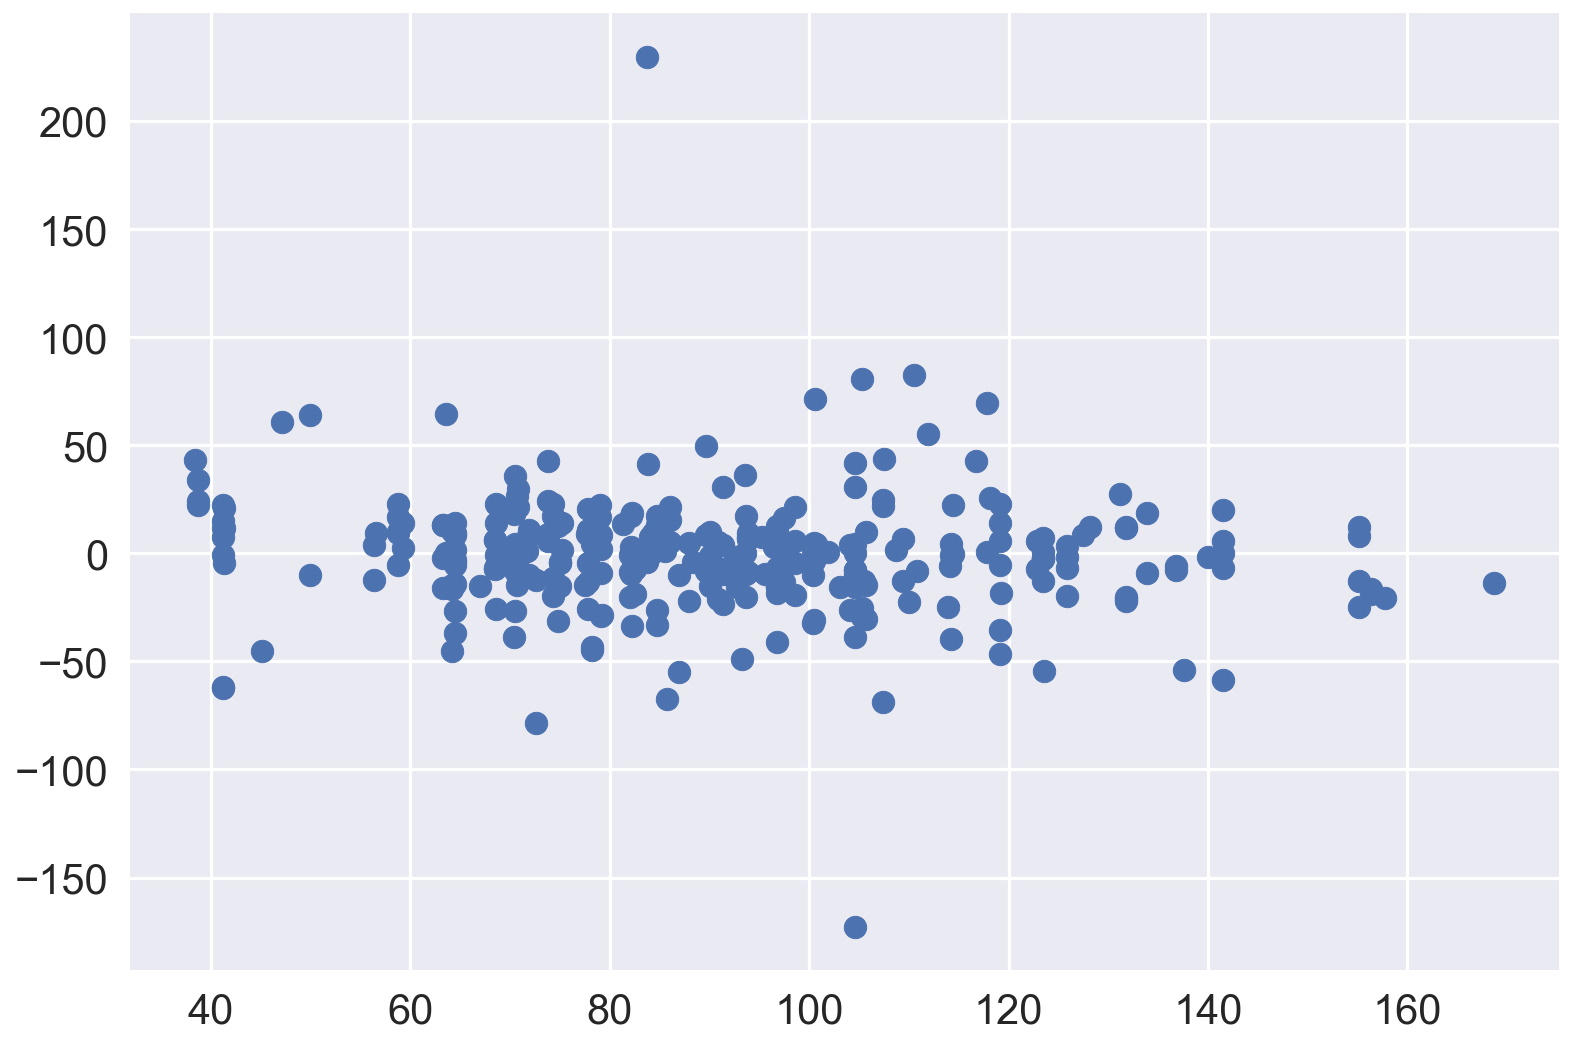

In [263]:
plt.scatter(angles, measured_alphas)

In [ ]:
# Todo: ipywidgets minimization of spline + offsets for vshift

In [62]:
# def plot_a_v_z(dataframe, alphacol='delta_alpha', 
#                errorcol='extra_error_delta_alpha', 
#                nbins=13,
#                color=0,
#                ylims=(20),
#                label='',
#                fig=None,
#                ax=None,
#               ):
#     if fig == None:
#         fig = plt.gcf()
#     if ax == None:
#         ax = plt.gca()
#     for index, df in enumerate(np.array_split(dataframe.sort_values('z_absorption'), nbins)):
#         x = np.average(df.z_absorption)
#         y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
#         e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
#         if index == 0:
#             label=label
#         else:
#             label=''
#         ax.scatter(x, y, c=sns.color_palette()[color], label=label)
#         ax.errorbar(x, y, yerr=e, c=sns.color_palette()[color])
#     ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
#     ax.set_ylabel(r"$\Delta \alpha/\alpha$")
#     ax.set_xlabel(r"Redshift [z]")
#     ax.legend(loc='best')
#     ax.set_xlim(0.3, 3.7)
#     ax.set_ylim(-ylims, ylims)
#     fig.tight_layout()

# def plot_a_v_zresid(dataframe, 
#                     dataframe2,
#                     alphacol='delta_alpha',
#                     alphacol2='dipole_delta_alpha',
#                     errorcol='extra_error_delta_alpha', color=0, label=''):
#     """Measured - model"""
#     fig = plt.gcf()
#     ax = plt.gca()
#     nbins = 13
#     for index in range(nbins):
#         df = np.array_split(dataframe.sort_values('z_absorption'), nbins)[index]
#         x = np.average(df.z_absorption)
#         y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
#         e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        
#         df2 = np.array_split(dataframe2.sort_values('z_absorption'), nbins)[index]
#         x2 = np.average(df2.z_absorption)
#         y2 = np.average(df2[alphacol2], weights=(1.0 / (df2[errorcol] ** 2.0)))
#         e2 = np.sqrt(1.0 / np.sum(1.0 / (df2[errorcol] ** 2.0)))
#         if index == 0:
#             label=label
#         else:
#             label=''
#         ax.scatter(x, (y - y2), c=sns.color_palette()[color], label=label)
#         ax.errorbar(x, (y - y2), yerr=e, c=sns.color_palette()[color])
#     ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
#     ax.set_ylabel(r"Residual $\Delta \alpha/\alpha$")
#     ax.set_xlabel(r"Redshift [z]")
#     ax.legend(loc='best')
#     ax.set_xlim(0.3, 3.7)
#     ax.set_ylim(-20, 20)
#     fig.tight_layout()

# Alpha measurements as proxies for wavelength distortions

We have many measurements of $\alpha$ on both the [Keck](https://en.wikipedia.org/wiki/W._M._Keck_Observatory) and [VLT](https://en.wikipedia.org/wiki/Very_Large_Telescope) telescopes. Measurements with spectrographs both telescopes reveal statistically significant (though small in absolute terms) differences between the expected positions of absorption lines and the measured positions. 


## Hypothesis tests or statistical inference

There are many possible hypotheses that could explain these differences. To list just two: 

 - the value of the fine-structure constant ($\alpha$) has changed
 - there are velocity distortions in the instrument.
 
We can consider any velocity shift measurements as a hypothesis test. Previous studies started with the assumption that any shift in absorption lines would come as a result of a change in $\alpha$. We have the reported $\frac{\Delta \alpha}{\alpha}$ values for both the Keck and VLT samples. If we invert the hypothesis: use the measured alpha values as a system of velocity shifts, we can effectively discriminate which hypothesis best fits the data.

## Simulations

The goal will be to simulate what the velocity shifts look like if the dipole model is correct, and compare that to what we currently see.


## Discussion

The end goal of this analysis is ultimately a change in how $\frac{\Delta \alpha}{\alpha}$ is measured. The proposed recipe is:

 1. Create the best fit velocity structure as usual.
 2. Fit for relative velocity shifts between all lines (`vpfit` already allows for this).
 3. Combine all velocity shifts for all measured systems with a particular telescope.
 4. Use standard hypothesis statistical tests to discriminate the most likely hypothesis: a wavelength distortion model, or a change in the fine-structure constant.

This will likely have rather low power for any single absorption system, but for ensembles, I think that it's likely the only case 



## Useful References (in reverse chronological order)

 - [Modeling long-range wavelength distortions in quasar absorption echelle spectra](https://arxiv.org/abs/1701.03176) (2017) by Vincent Dumont, John K. Webb
 - [Artificial intelligence applied to the automatic analysis of absorption spectra. Objective measurement of the fine structure constant](https://arxiv.org/abs/1606.07393) (2016) by Matthew B. Bainbridge, John K. Webb
 - [Impact of instrumental systematic errors on fine-structure constant measurements with quasar spectra](https://arxiv.org/abs/1409.4467) (2014) by Jonathan B. Whitmore, Michael T. Murphy
 
 - [Bayesian Approach Overview (pdf)](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2014MmSAI..85...96C&link_type=ARTICLE&db_key=AST&high=) by Ewan Cameron, Tony Pettitt
 - [Bayesian Approach 1](https://arxiv.org/abs/1207.6223) by Ewan Cameron, Tony Pettitt
 - [Bayesian Approach 2](https://arxiv.org/abs/1309.2737) by Ewan Cameron, Tony Pettitt
 
 - [Spatial variation in the fine-structure constant -- new results from VLT/UVES](https://arxiv.org/abs/1202.4758) (2012) by Julian A. King, John K. Webb, Michael T. Murphy, Victor V. Flambaum, Robert F. Carswell, Matthew B. Bainbridge, Michael R. Wilczynska, F. Elliot Koch
 - [Further evidence for a variable fine-structure constant from Keck/HIRES QSO absorption spectra](https://arxiv.org/abs/astro-ph/0306483) (2003) by Michael T. Murphy, John K. Webb, Victor V. Flambaum
 - [Does the fine structure constant vary? A detailed investigation into systematic effects](https://arxiv.org/abs/astro-ph/0210532) (2002) by M. T. Murphy, J. K. Webb, V. V. Flambaum, S. J. Curran


In [5]:
species = set([spec[0] for spec in qvals.index.str.split('I')])
colors = sns.color_palette(n_colors=len(species))
plot_colors = {}
for index, specie in enumerate(sorted(species)):
    plot_colors[specie] = colors[index]

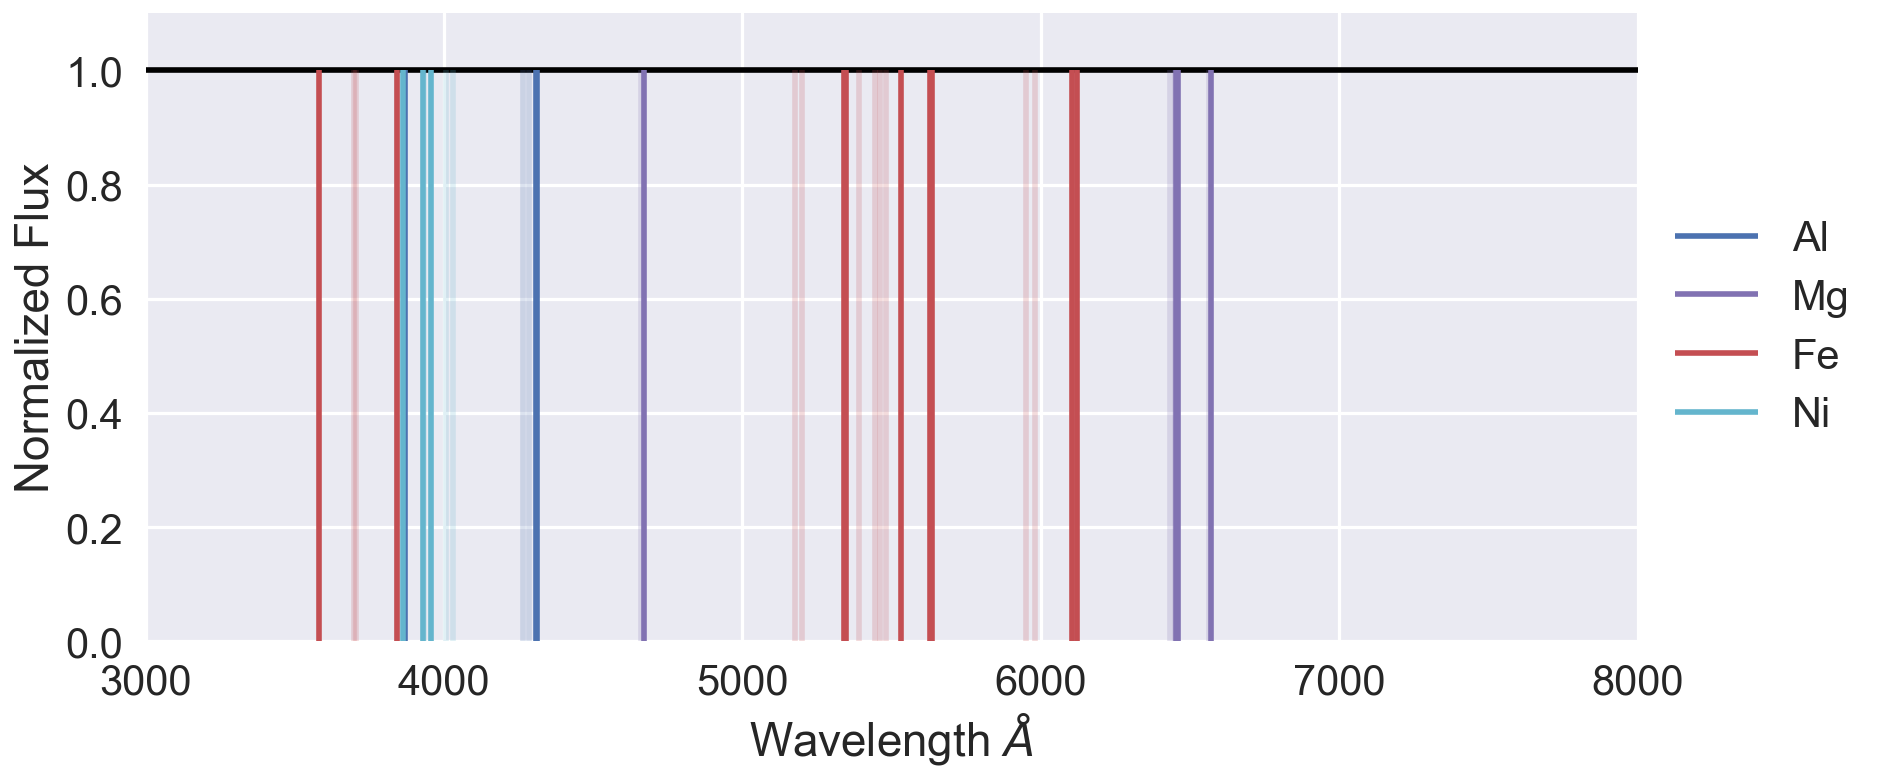

In [11]:
# def plot_absorption(specie=['Al', 'Mg'],
#                     z=1.3,
#                     daa=0.05,
#                    ):
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.hlines(1, 0, 10000)
#     for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
#         ax.vlines((1.0 + z) * row.wave + row.qval * ((daa + 1)**2.0-1.0), 
#                       0, 1, color=plot_colors[tran[:2]])
#         ax.vlines((1.0 + z) * row.wave, 
#                       0, 1, color=plot_colors[tran[:2]], alpha=0.2)
        
#     ax.set_xlim(3000, 8e3)
#     ax.set_ylim(0, 1.1)
#     ax.set_ylabel("Normalized Flux")
#     ax.set_xlabel(r"Wavelength $\AA$")
    
#     for spec in specie:
#         ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec)
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.tight_layout()

# plot_absorption(specie=['Al', 'Mg', 'Fe', 'Ni'], )

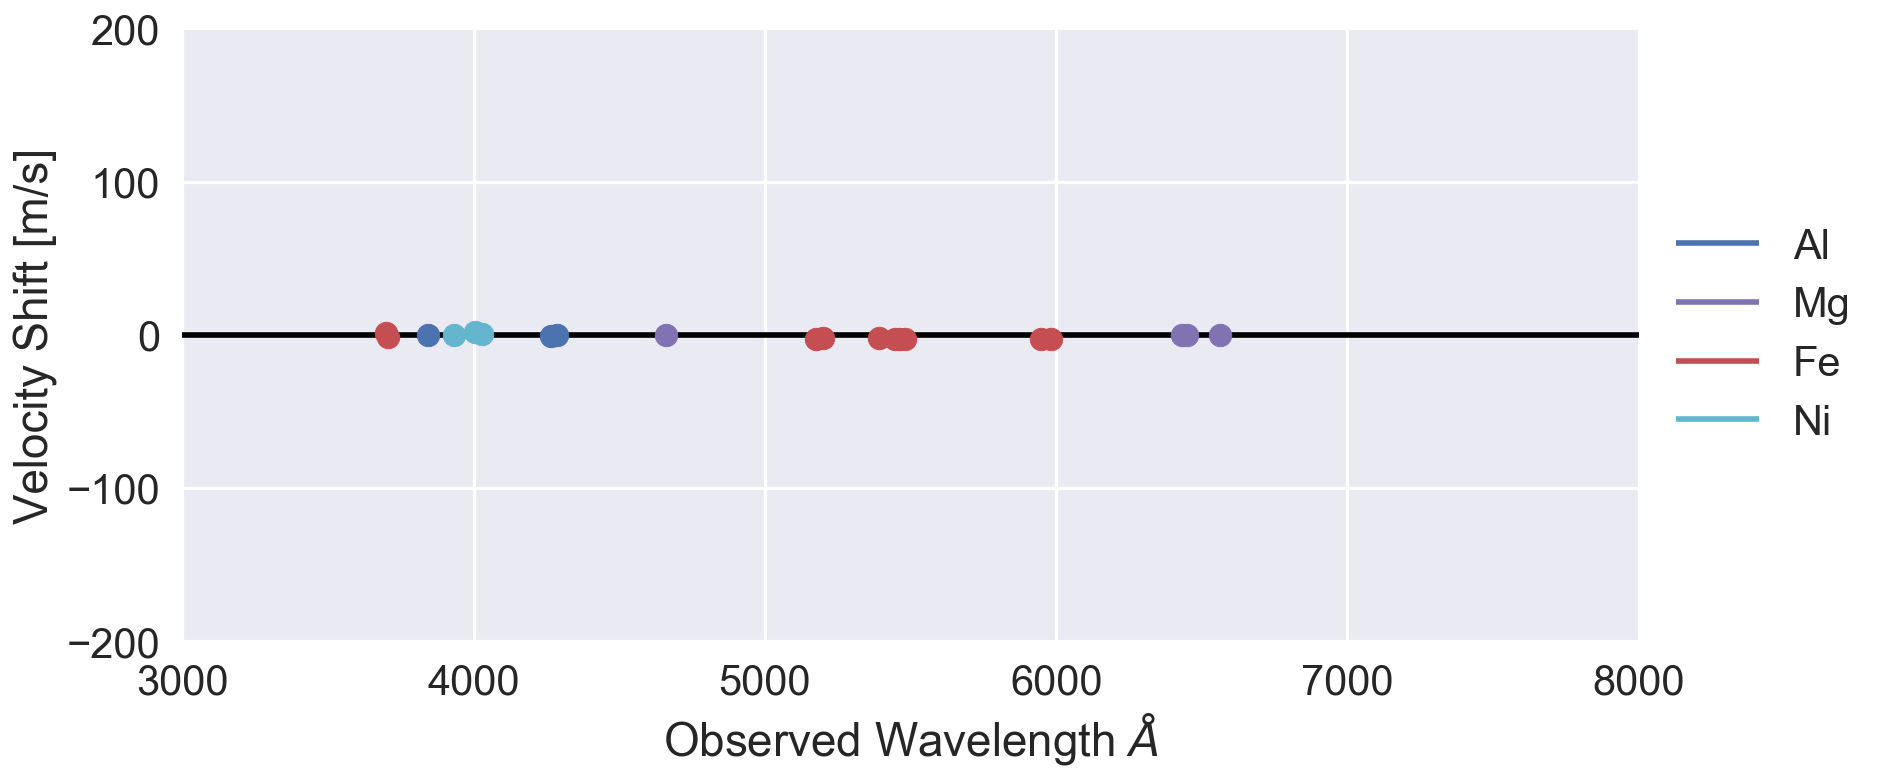

In [51]:
# def plot_shift(specie=['Al', 'Mg'],
#                     z=1.3,
#                     daa=0.05,
#                    ):
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.hlines(0, 0, 10000)
#     for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
#         ax.scatter((1.0 + z) * row.wave, 
# #                    row.qval * ((daa + 1)**2.0-1.0),
#                    shifted_velocity(daa, row.qval, (1.0 + z) * row.wave),
#                    color=plot_colors[tran[:2]], zorder=3)
        
#     ax.set_xlim(3000, 8e3)
#     ax.set_ylim(-200, 200)
#     ax.set_ylabel("Velocity Shift [m/s]")
#     ax.set_xlabel(r"Observed Wavelength $\AA$")
    
#     for spec in specie:
#         ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec, zorder=-3)
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.tight_layout()

# plot_shift(specie=['Al', 'Mg', 'Fe', 'Ni'], )

In [52]:
redshift_slider = FloatSlider(value=2.1, min=0.0, max=3.5)
alpha_slider = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1)
species_select = SelectMultiple(options=['Al', 'Cr', 'Fe', 'Mg', 'Mn', 'Ni', 'Si'],
                                description="Species",
                                value=['Al', 'Fe']
                               )
# w = interactive(plot_absorption, 
#                 specie=species_select,
#                 z=redshift_slider,
#                 daa=alpha_slider,
#                )
shift_interactive = interactive(plot_shift, 
                specie=species_select,
                z=redshift_slider,
                daa=alpha_slider,
               )

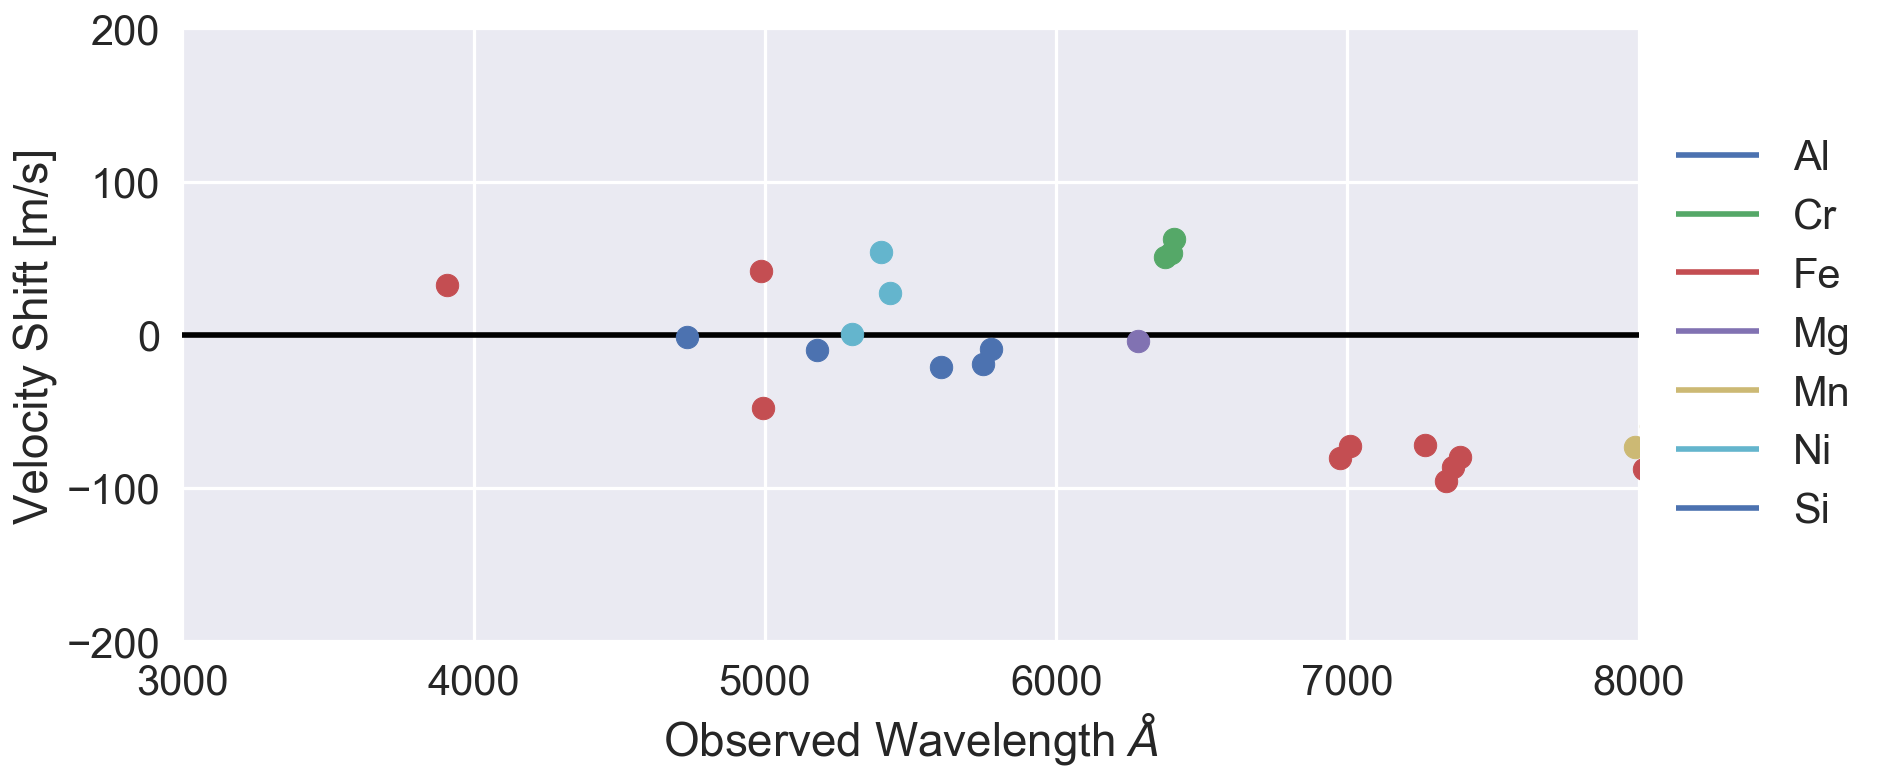

In [53]:
shift_interactive

In [246]:
# def plot_example_telescope_bins(nbins = 12,
#                                 alphacol = 'delta_alpha',
#                                 errorcol = 'error_delta_alpha',
#                                 binned_lim = 25.0,
#                                 dataframe=keck,
#                                ):
#     fig, (ax, ax2) = plt.subplots(figsize=(12, 10), 
#                                   nrows=2,
#                                   sharex=True,
#                                   gridspec_kw={'height_ratios':[1.5,1]},
#                                  )


#     for index, df in enumerate(np.array_split(dataframe.sort_values('z_absorption'), nbins)):
#         color = sns.color_palette(n_colors=13)[index]

#         x = df.z_absorption
#         y = df[alphacol]
#         e = df[errorcol]
#         ax.scatter(x, (y), c=color, label='', s=40)
#         ax.errorbar(x, (y), yerr=e, c=color,  ls='none', label='')

#         x = np.average(df.z_absorption)
#         y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
#         e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
#         label=''
#         if index == 0:
#             label=label
#         else:
#             label=''
#         ax2.scatter(x, y, c=color, label=label)
#         ax2.errorbar(x, y, yerr=e, c=color)

#     ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
#     ax.hlines(binned_lim, -2, 6, linestyles=':', lw=.5, color='k')
#     ax.hlines(-binned_lim, -2, 6, linestyles=':', lw=.5, color='k')
#     ax2.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')

#     ax.set_ylabel(r"Slopes per Company ($\Delta \alpha/\alpha$)")
#     ax2.set_ylabel(r"Weighted Binneds")
#     ax2.set_xlabel(r"Decades Ago (Redshift [z])")
#     ax.legend(loc='best')
#     ax.set_xlim(0.3, 3.9)
#     ax.set_ylim(-150, 150)
#     ax2.set_ylim(-binned_lim, binned_lim)
#     fig.tight_layout()


# def plot_example_company(company=19, # which system to use
#                          daa=2.5, # ppm of generated slope
#                         ):

#     row = all_systems.iloc[company]
#     df = df_a[df_a.system==company]
#     heights = df.x

#     color_index = 0

#     waves = []
#     rest_waves = []
#     vshifts = []
#     qvals_list = []
#     for tran in row['transitions'].split():
#         vshift = 0.0
#         rest_wave = qvals.loc[codes.loc[tran].trans].wave
#         measured_wave = rest_wave * (1 + row.z_absorption)
#         qval = qvals.loc[codes.loc[tran].trans].qval
#         vshift += shifted_velocity(daa,
#                                    qval,
#                                    rest_wave)

#         waves.append(measured_wave)
#         rest_waves.append(rest_wave)
#         vshifts.append(vshift)
#         qvals_list.append(qval)

#     waves = np.array(waves)
#     rest_waves = np.array(rest_waves)
#     vshifts = np.array(vshifts)
#     qvals_list = np.array(qvals_list)
#     sigmas = np.ones_like(waves) * 5.0
    
#     vshifts += sigmas * np.random.randn(len(vshifts))
#     fig, ax = plt.subplots(figsize=(12, 8))

#     design_matrix = sm.add_constant(heights)

#     results = sm.WLS(vshifts, design_matrix, weights=1.0/sigmas).fit()
#     chisq = np.sum((vshifts - results.fittedvalues)**2.0 / (sigmas) ** 2.0)
#     const, slope = results.params

#     ax.scatter(heights, vshifts, color=sns.color_palette()[color_index], label='')
#     ax.errorbar(heights, vshifts, yerr=sigmas, c=sns.color_palette()[color_index],  ls='none', label='')
#     ax.plot(heights, results.fittedvalues, color='k', label='Fit slope: ' + str(round(slope, 2)) + " ppm")
    
#     ax.legend(loc='best')
#     ax.set_xlabel("Height")
#     ax.set_ylabel("Salary")
#     ax.set_title("Company: " + str(company) + " Generating slope: " + str(daa))
#     fig.tight_layout()


# def plot_example_telescope_results(dataframe=keck):
#     fig, ax = plt.subplots(figsize=(12, 8))
#     x = dataframe.z_absorption
#     y = dataframe.delta_alpha
#     e = dataframe.error_delta_alpha
#     color=0
#     label='Slopes'
#     ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
#     ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
#     ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
#     ax.set_ylabel(r"Slopes per Company ($\Delta \alpha/\alpha$)")
#     ax.set_xlabel(r"Decades Ago (Keck redshift [z])")
#     ax.legend(loc='best')
#     ax.set_xlim(0.3, 3.7)
#     ax.set_ylim(-200, 200)
#     fig.tight_layout()
    

In [15]:
def plot_shifts(telescope='VLT'):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.2}, ax=ax)
    ax.set_ylim(-200, 200)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(telescope)
    fig.tight_layout()

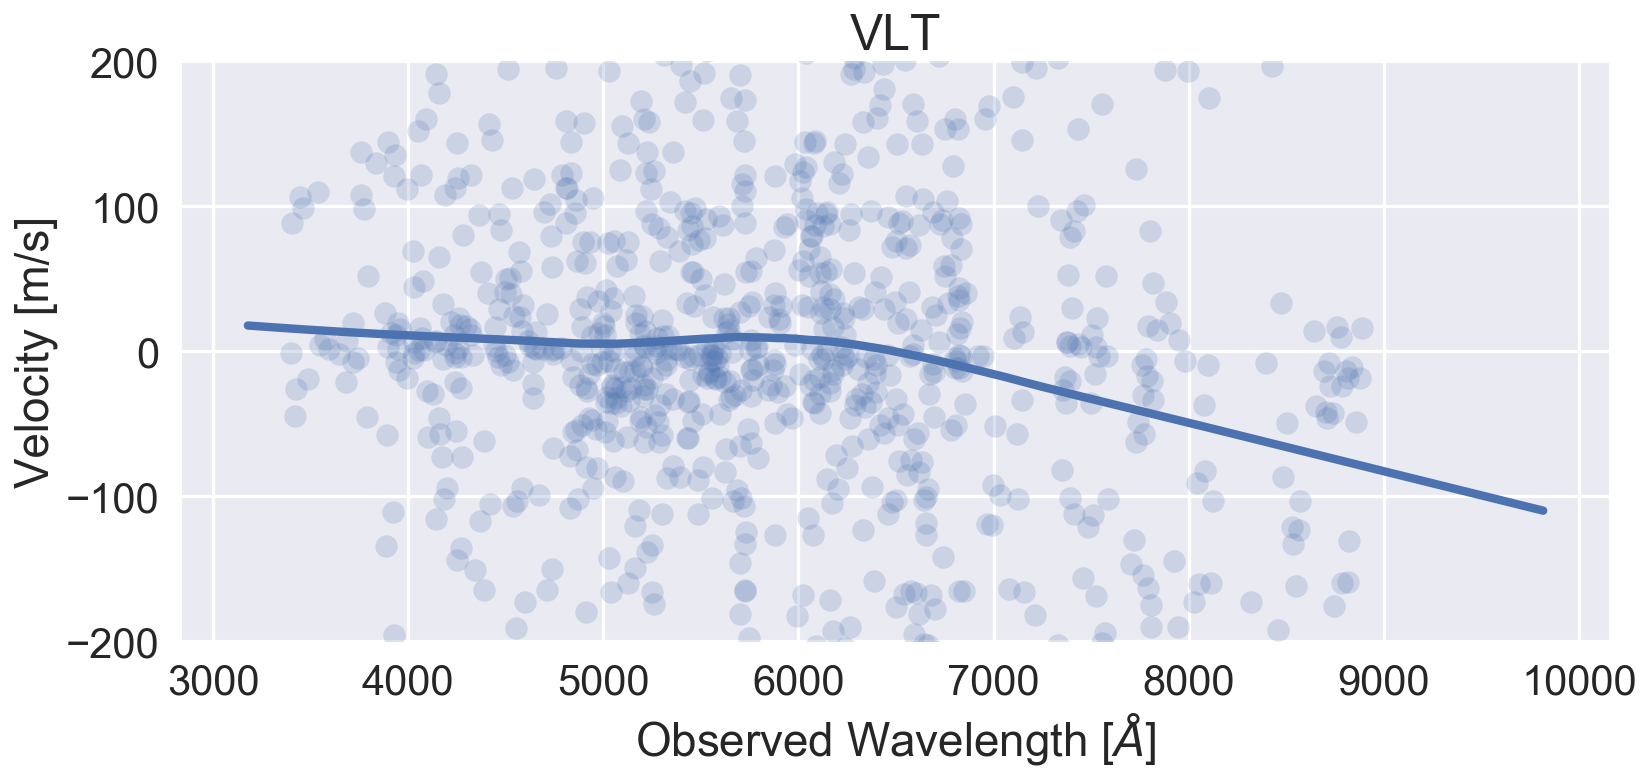

In [16]:
plot_shifts(telescope='VLT')

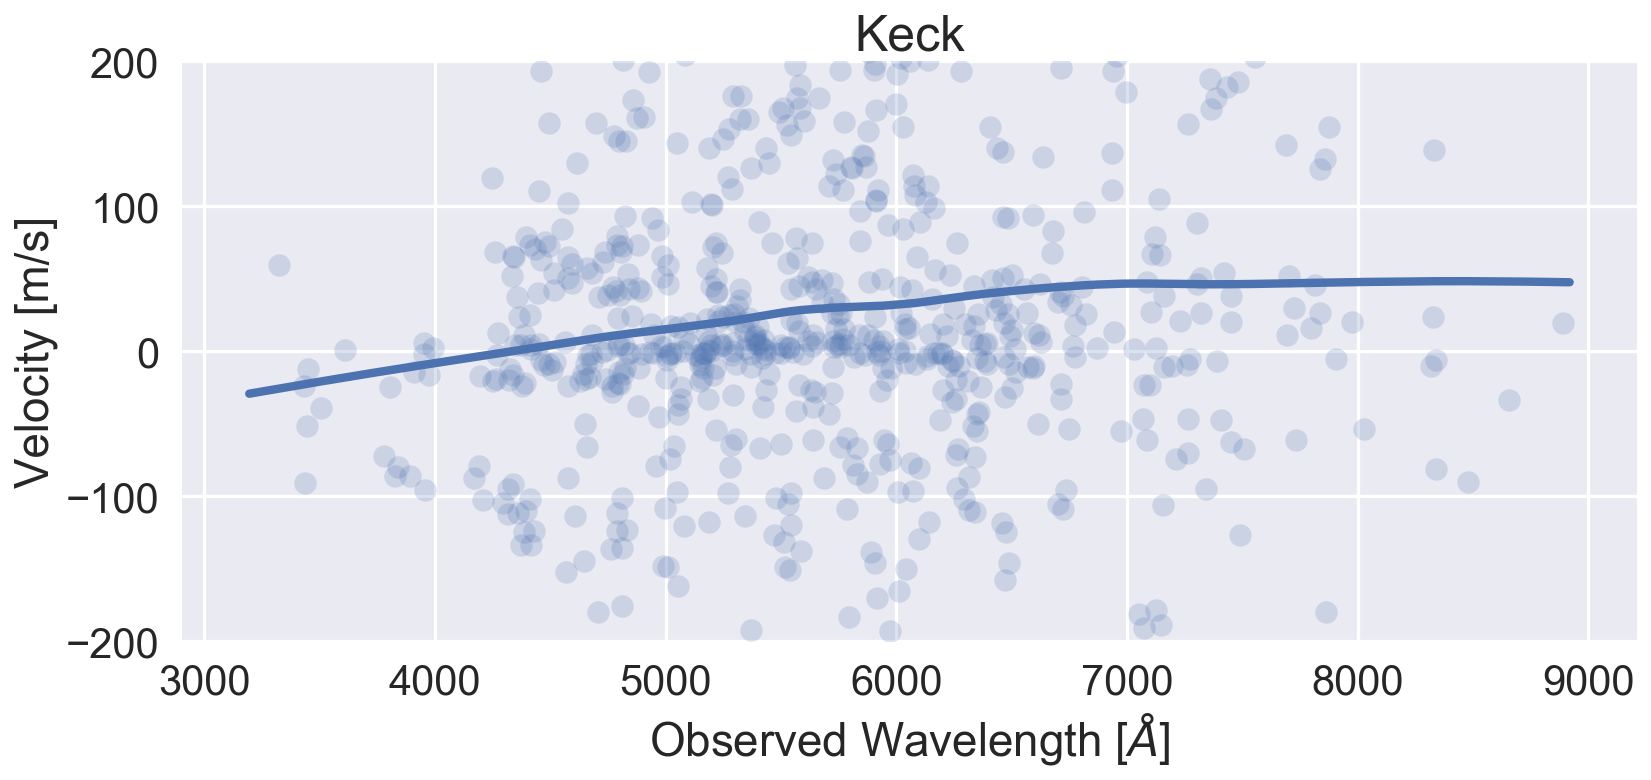

In [17]:
plot_shifts(telescope='Keck')

In [59]:
def plot_all(title='Keck + VLT'):
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    telescope='Keck'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    ax.set_xlim(2000, 10000)
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(title)
    fig.tight_layout()

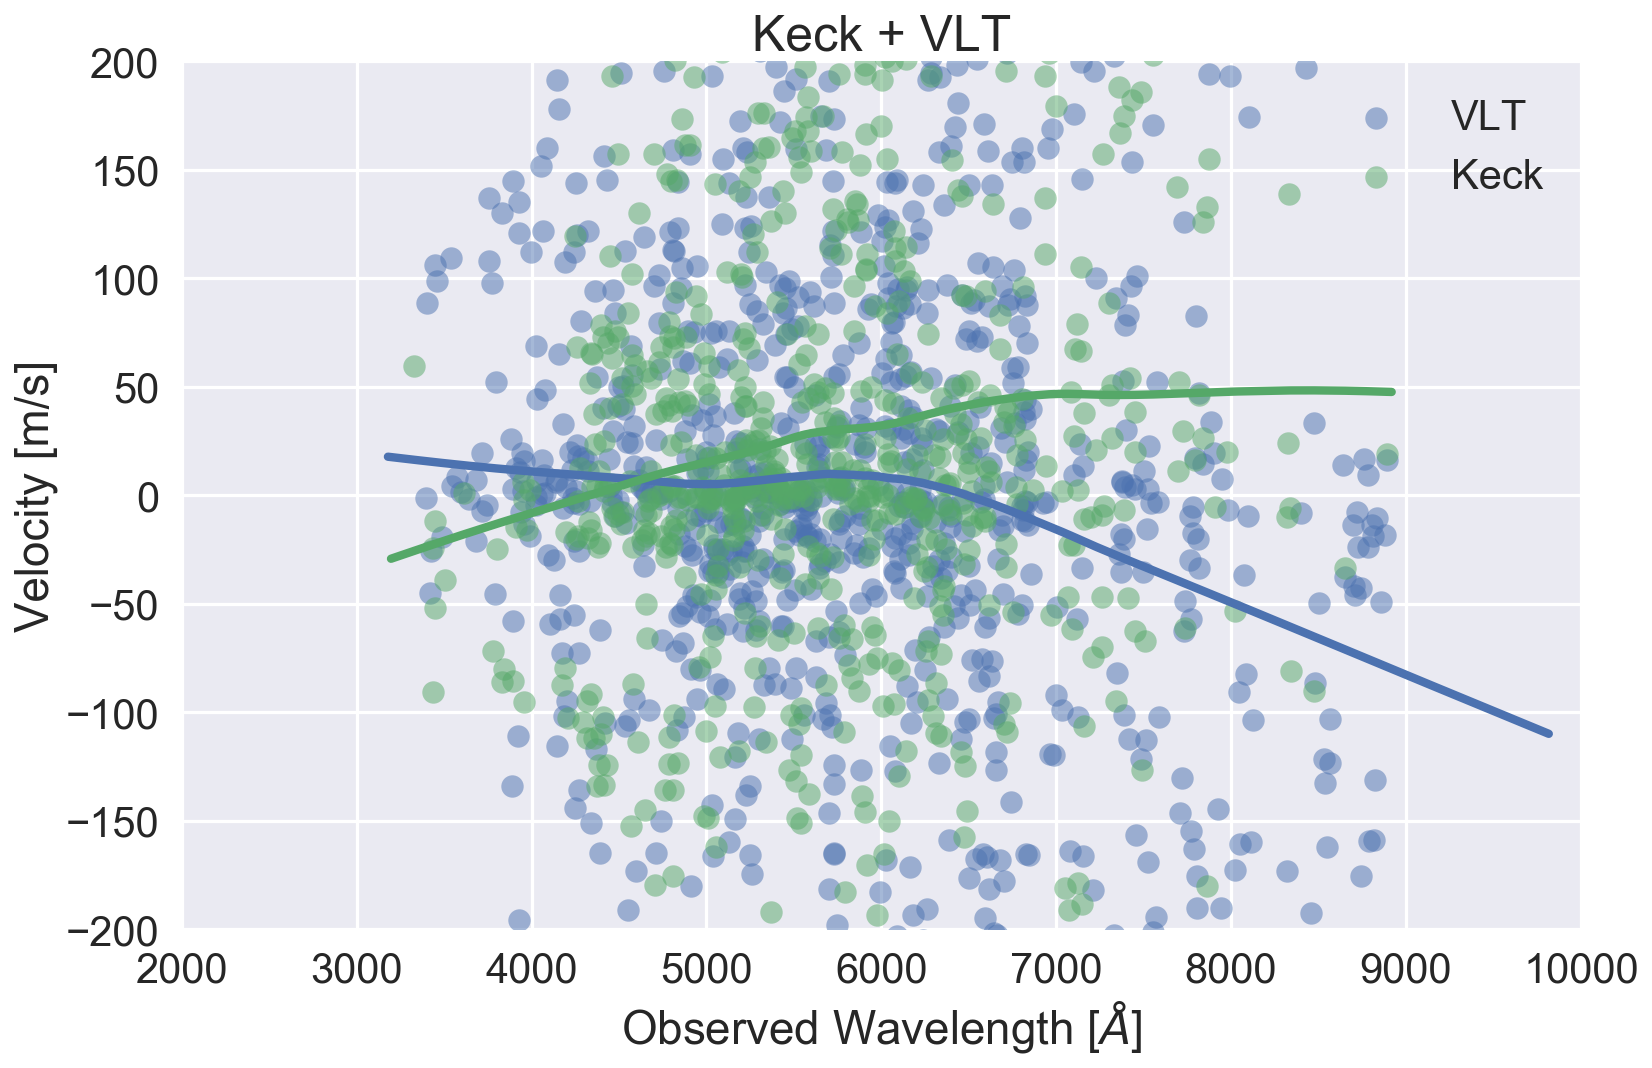

In [60]:
plot_all()

In [61]:
def observed_shifts_by_sample(sample='A'):
    waves = []
    shifts = []
    for index, row in all_systems[all_systems['sample'] == sample].iterrows():
        for tran in row['transitions'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.delta_alpha, qval, rest_wave))
    return np.array(waves), np.array(shifts)

def plot_samples():
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    for sample in sorted(all_systems['sample'].unique()):
        w, s = observed_shifts_by_sample(sample=sample)
        sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=sample)
    ax.set_ylim(-400, 400)
    ax.set_xlim(2000, 10000)
    ax.legend()
#     frame = ax.get_frame()
#     frame.set_alpha(1.0)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Samples')
    fig.tight_layout()

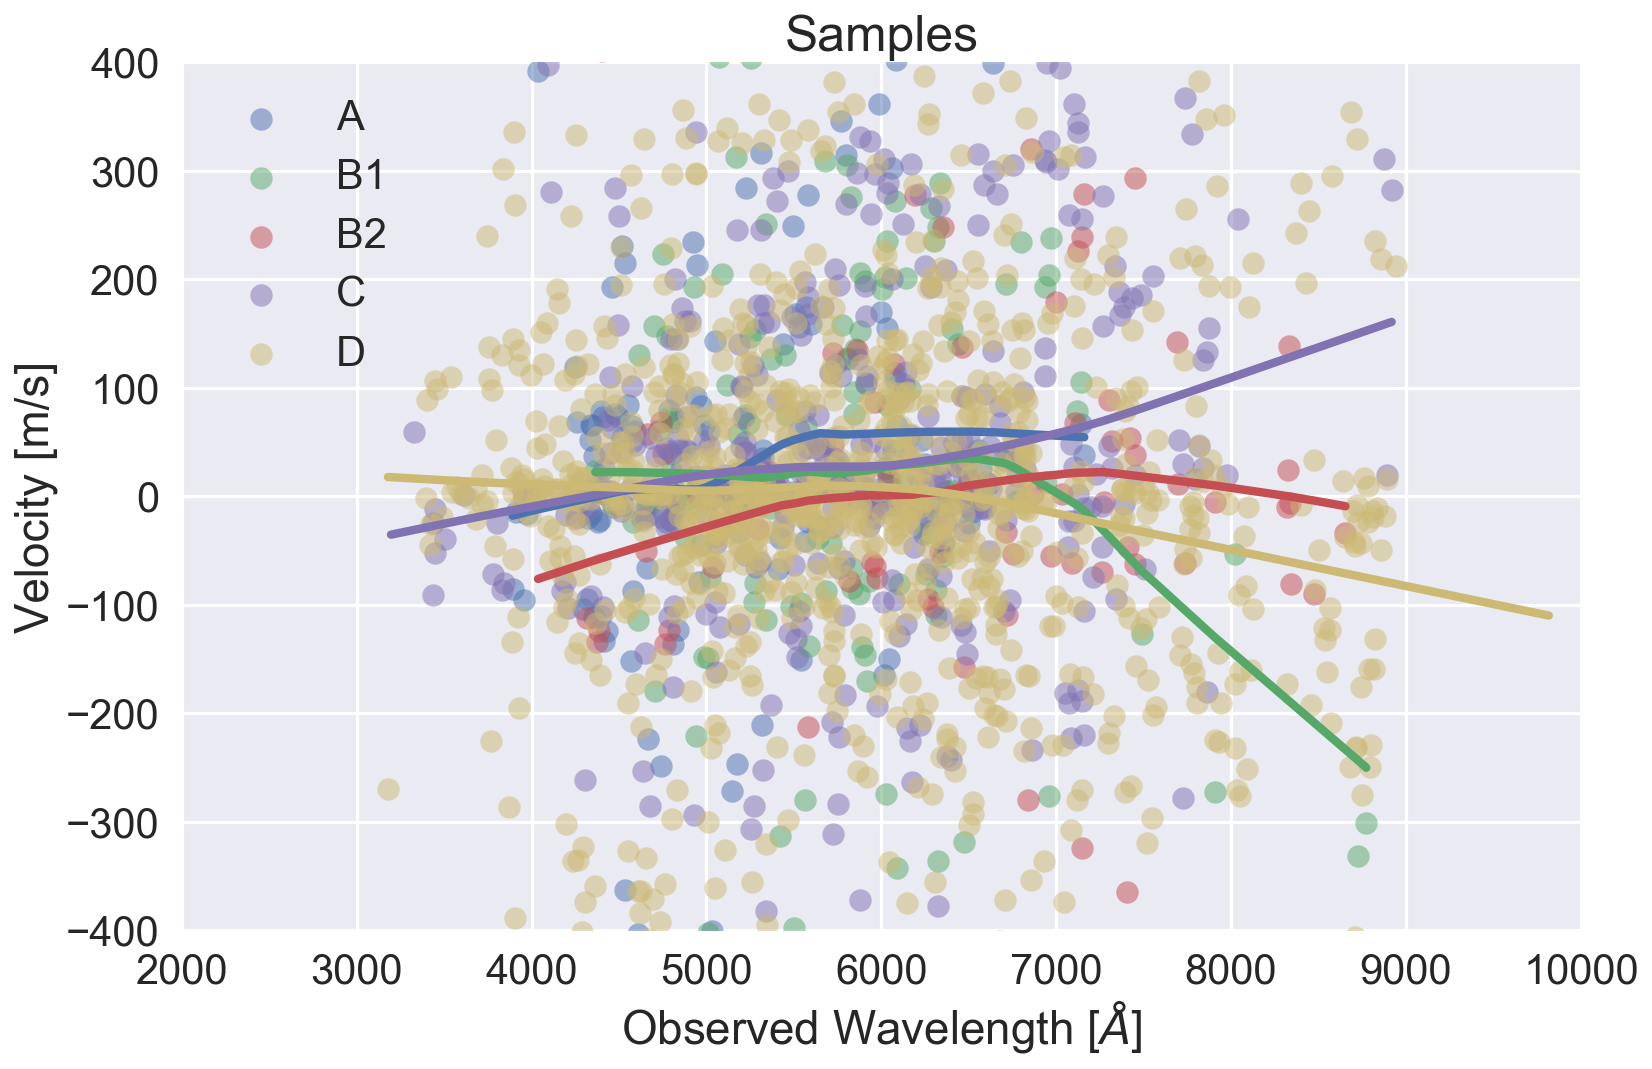

In [62]:
plot_samples()

## Simulations

Generate velocity shifts for the dipole hypothesis.

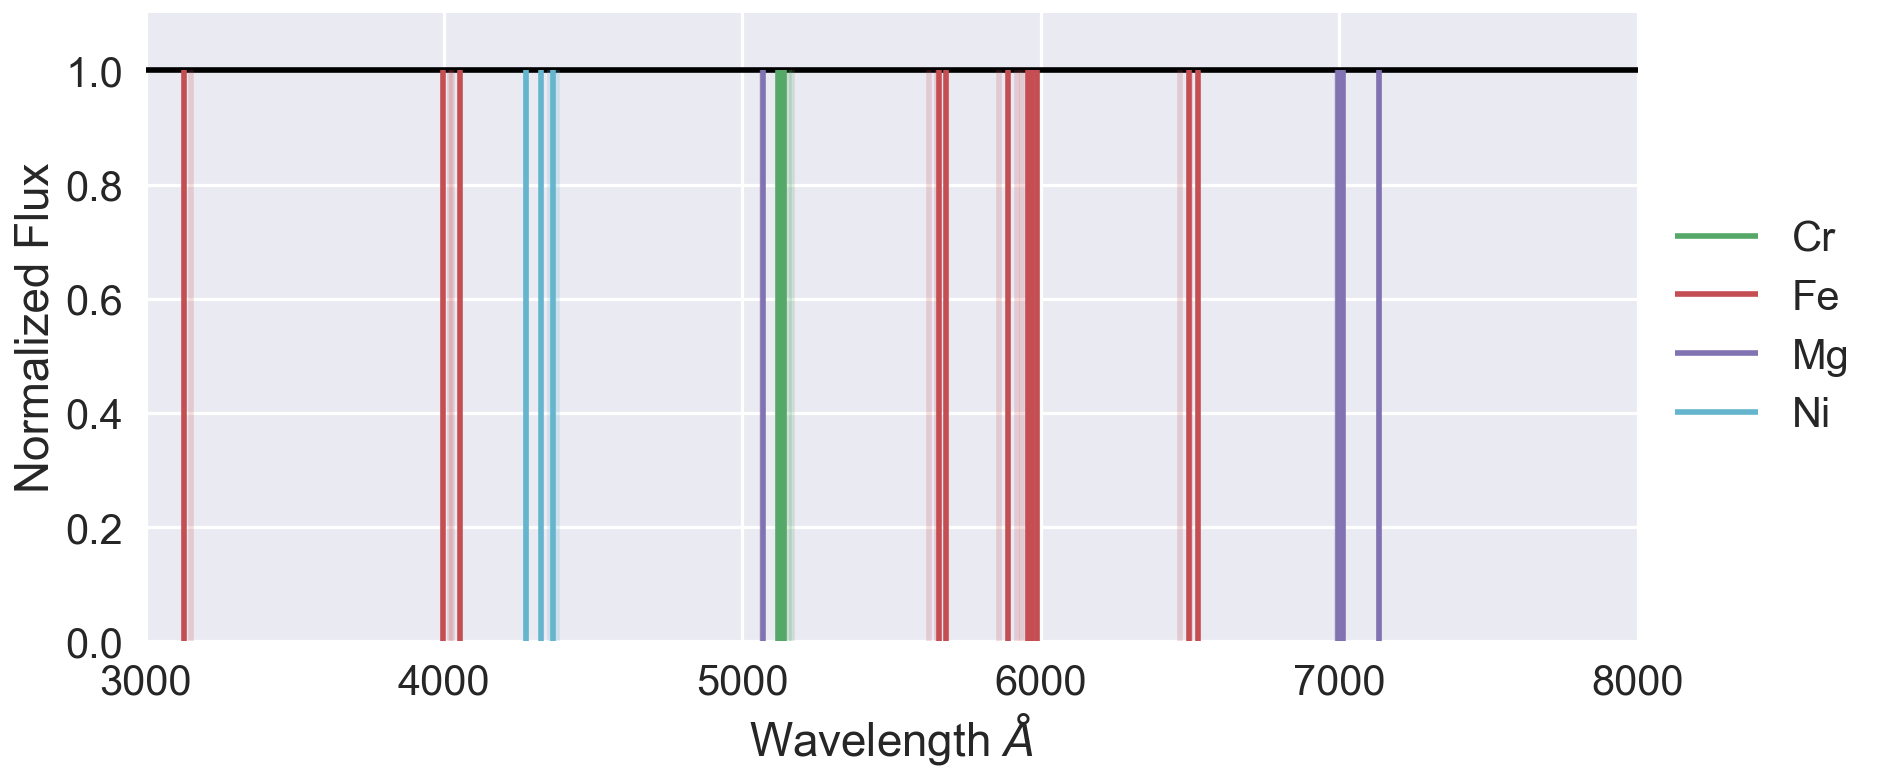

In [54]:
w

In [74]:
def plot_sim(telescope='VLT', use_dipole=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Measured VLT')
    w, s = simulated_shifts(telescope=telescope, use_dipole=use_dipole)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Dipole VLT')
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Simulated velocity shifts for ' + telescope)
    fig.tight_layout()

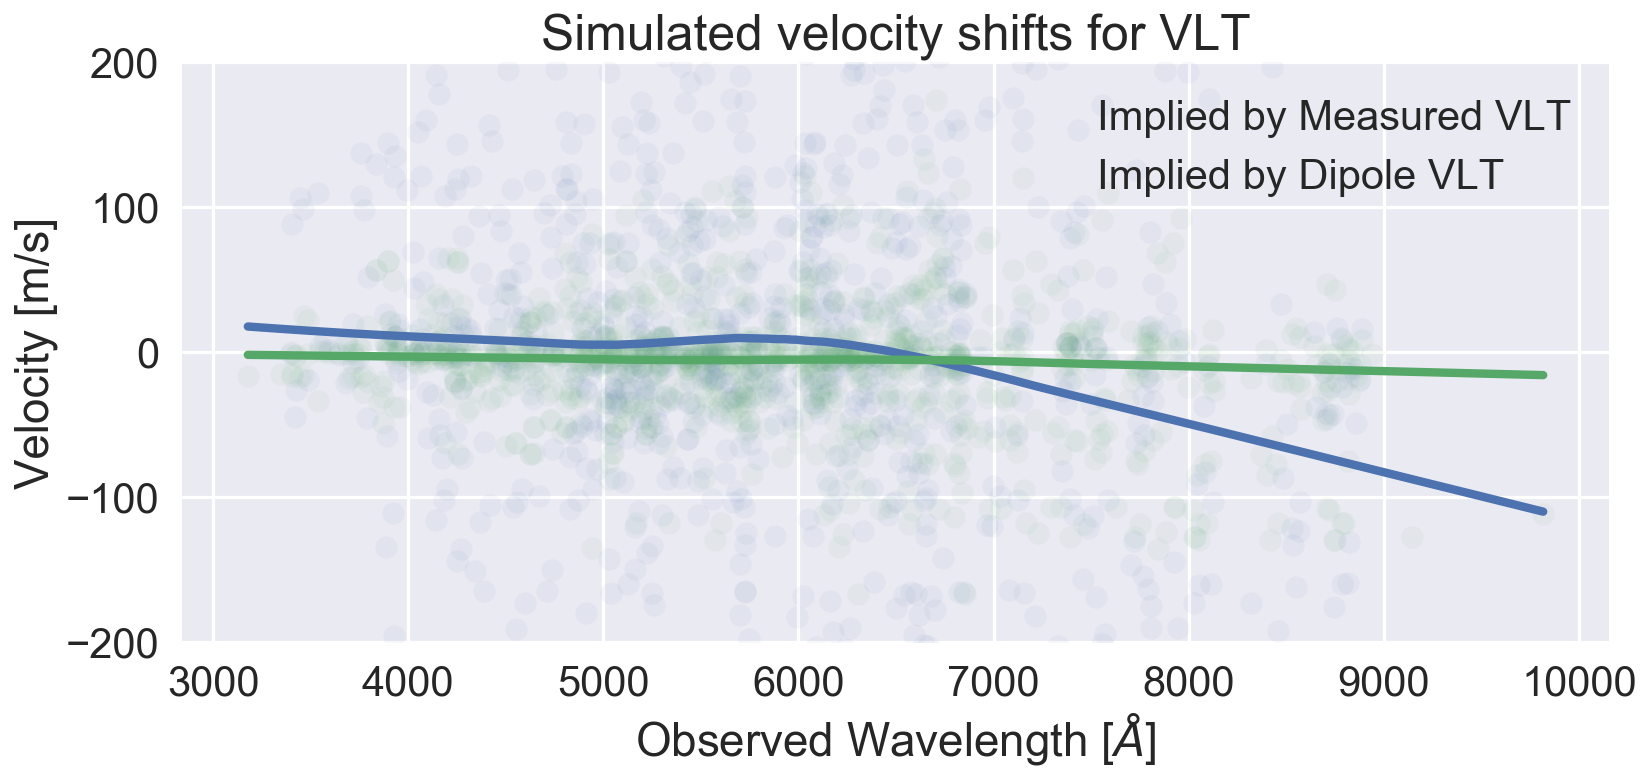

In [75]:
plot_sim()

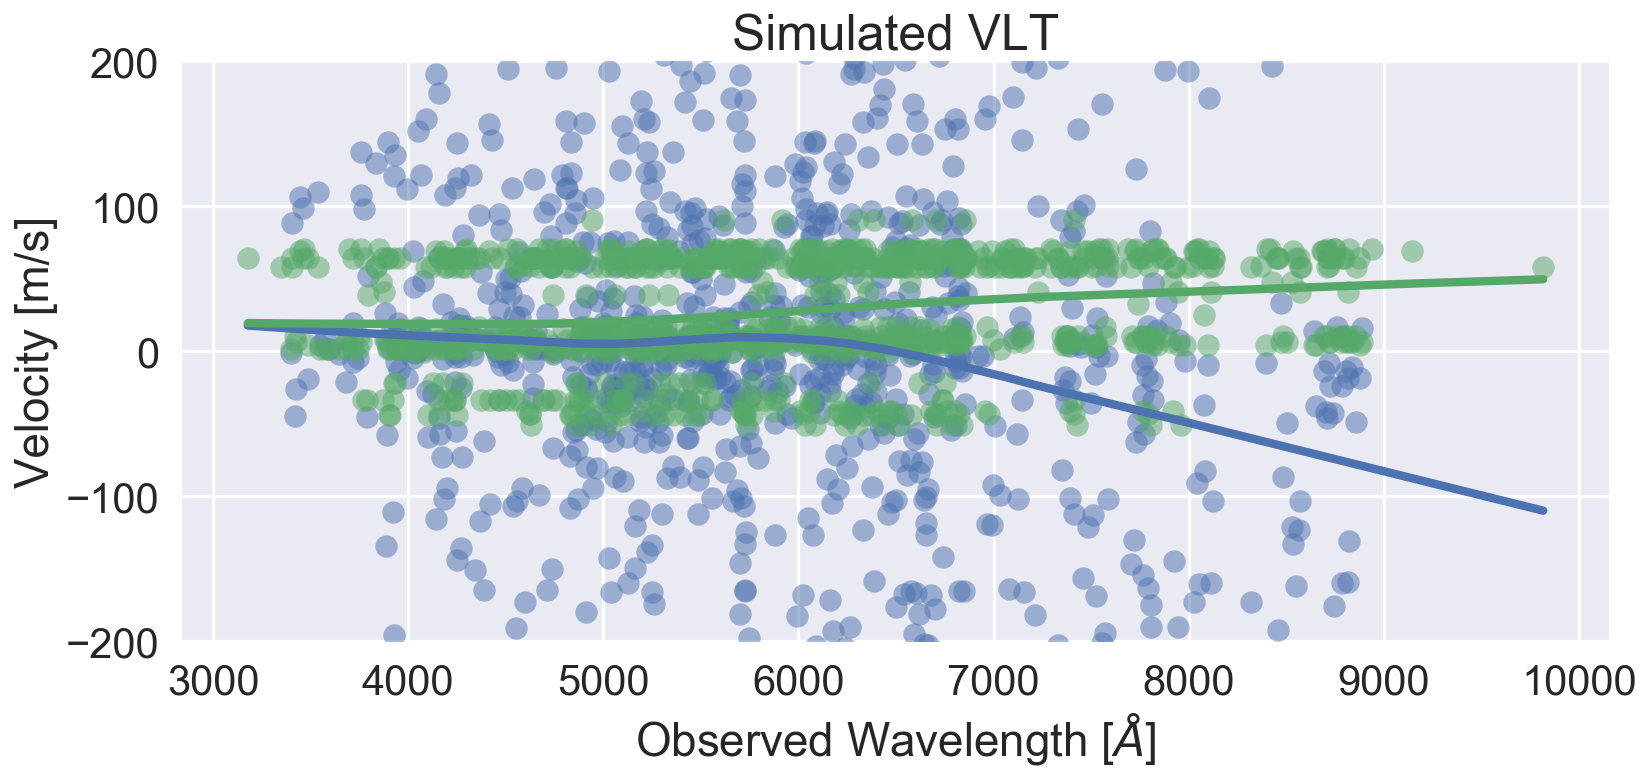

In [69]:
def simulated_shifts(telescope='VLT', use_dipole=True):
    waves = []
    shifts = []
    for index, row in all_systems[all_systems.source.eq(telescope)].iterrows():
        for tran in row['transitions'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
#             da = row.delta_alpha
            if use_dipole:
                da = row['dipole_delta_alpha']
            else:
                da = -3.0
            shifts.append(shifted_velocity(da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

plot_sim(use_dipole=False)

## Hypothesis test

I think that a non-parametric test for $\alpha$ would be to fit for all velocity shifts as independent shifts. 

The general procedure would be thus:

 - fit velocity shifts per wavelength region (with errors). 

#J2000   zem    zabs    da   eda sample source  sigflag  \
152  J004131-493611  3.24  2.2485 -12.3  6.72      D    VLT        3   

     imrotator                                         transition  
152          0  j1 j2 j3 j6 j7 j8 c1 d1 d2 e2 h1 h2 h3 l1 l2 k...

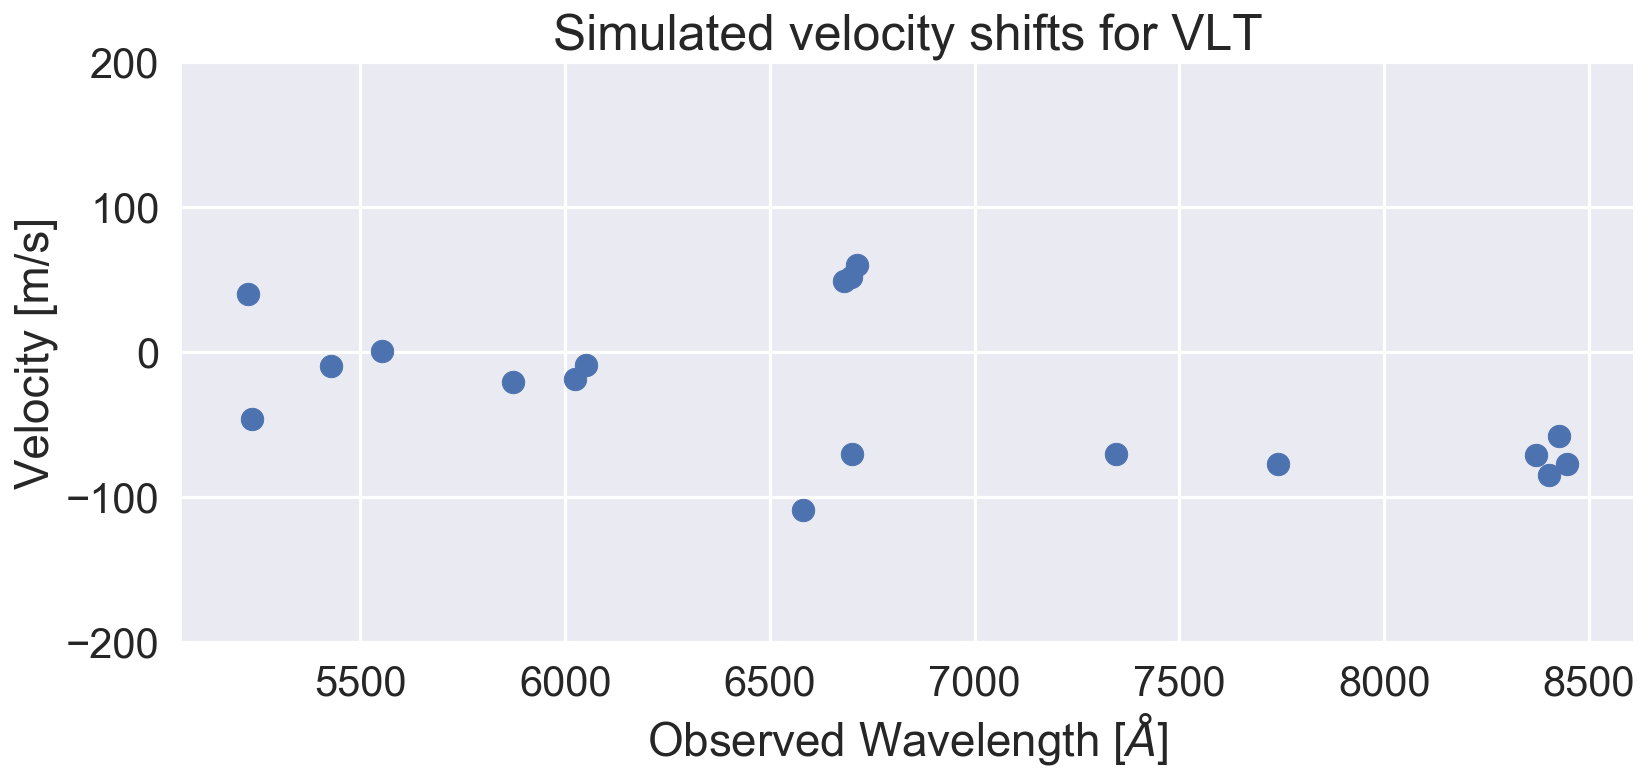

In [99]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope)
fig.tight_layout()

In [ ]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(np.round(da, 2)))
fig.tight_layout()

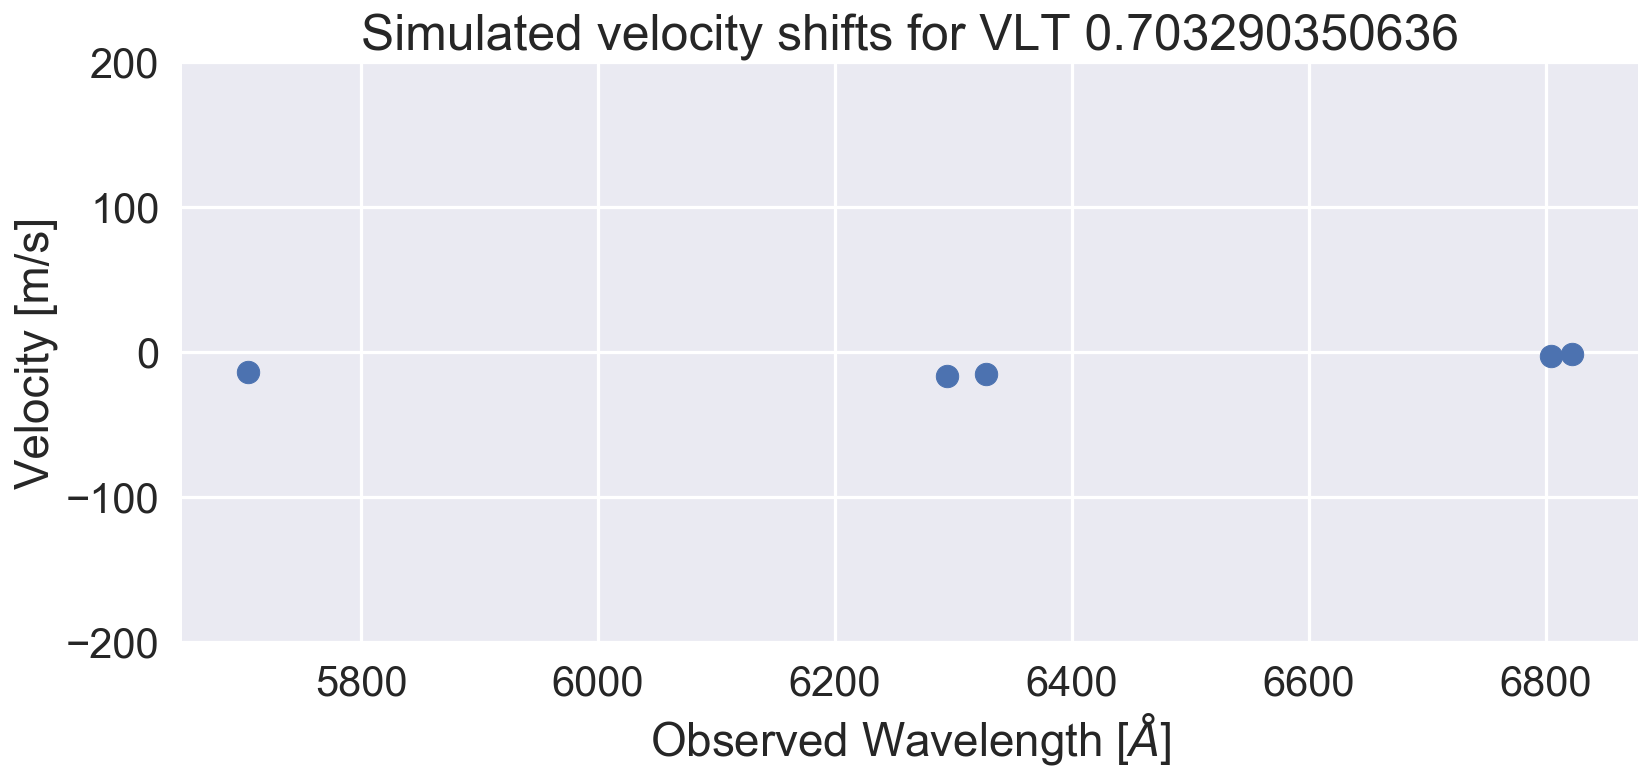

In [113]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=3
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

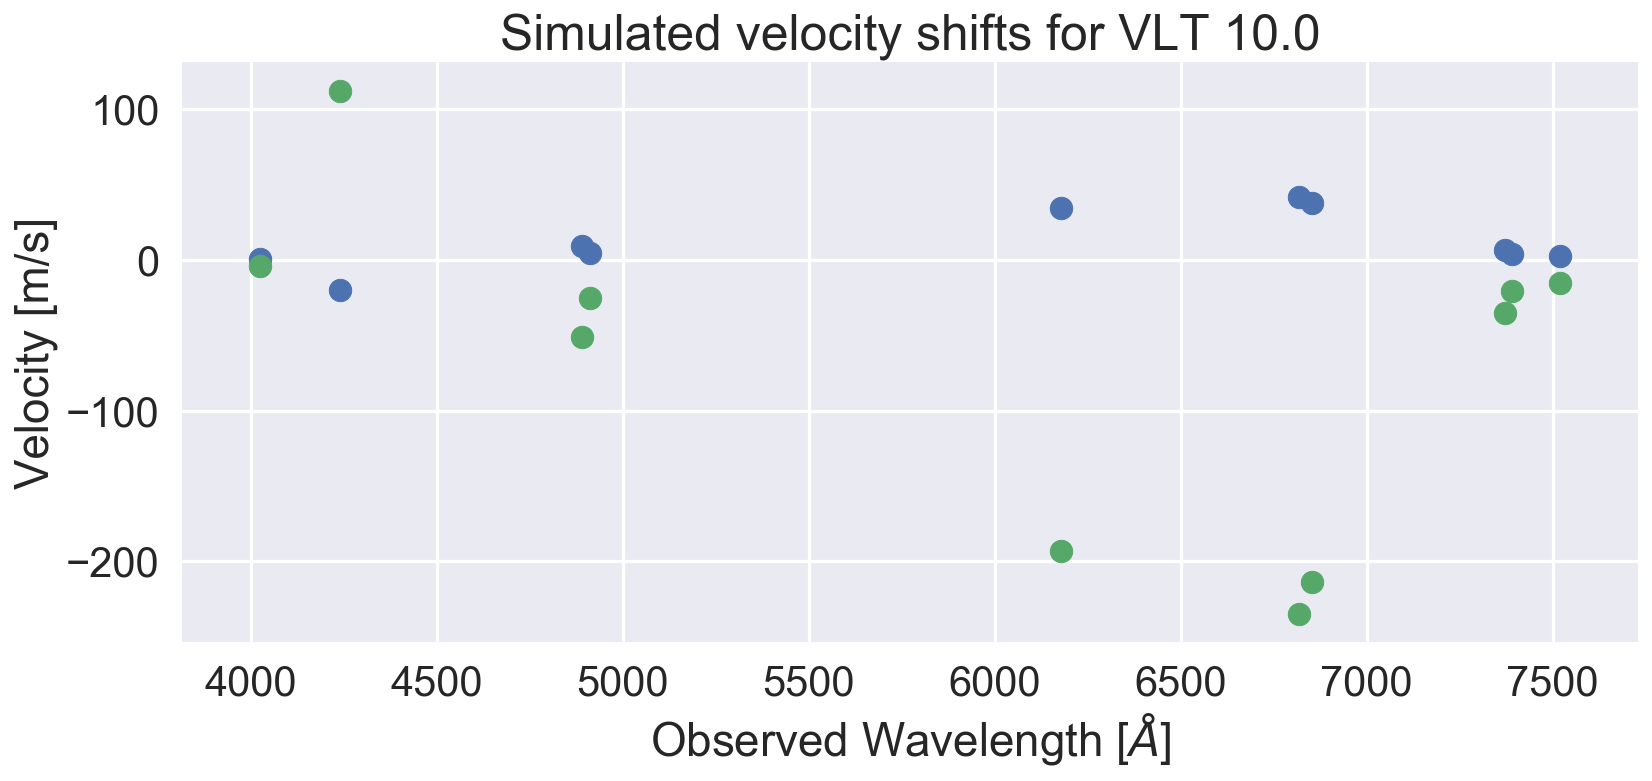

In [112]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=8
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = row['dipole_delta_alpha']
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)

waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = row.delta_alpha
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)

ax.scatter(wav, shift)
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

In [222]:
#  Todo consider including the outliers stripped via the LTS method
# # Outliers http://astronomy.swin.edu.au/~mmurphy/files/KingJ_12a_VLT+Keck.dat
# 127   J194454+770552     3.02    2.8433     -4.959     1.334    C          Keck    1             1
# http://astronomy.swin.edu.au/~mmurphy/MurphyM_09a.dat
# -          -     2.8433  dgl              -4.959 1.334 0.000  0.149 0.000 C

# 145   J000448-415728     2.76    1.5419     -5.270     0.906    D          VLT     3             1
# TableA1 
# b1b2j4j5j6j7j8


# # 
# for trans in vlt[vlt.J2000.str.startswith('J043037')]['transitions']:
#     trans = trans.split()
#     for tran in trans:
#         print(tran, codes.loc[tran].trans)

In [ ]:
# 2017 paper 
# for row in vlt[vlt.J2000.str.startswith('J043037')]:
trans = row.transitions.str.split()
zabs = row.z_absorption
for tran in trans.values[0]:
    print(tran, codes.loc[tran].trans, codes.loc[tran].wavelength * (1.0 + zabs.values[0]))